# ISO/IEC 27002:2022 CONTROL ASSESSMENT - REVISED

**REVISION NOTES:**
- Added ALL 11 ISO controls from thesis Appendix E.4
- Aligned assessment functions with indicator intent from thesis

Analyses 3: Comprehensive assessment of ISO 27002 controls for identified CPSS devices.

Input:
- cpss_all_services_enhanced.csv (from analyses_2)

Output:
- cpss_iso27002_assessment.csv
- cpss_iso27002_heatmap.png
- cpss_iso27002_report.txt

ISO 27002:2022 Controls Assessed (aligned with Thesis Appendix E.4):

**Access Control Domain:**
- A.8.2: Privileged access rights
- A.8.3: Information access restriction
- A.8.5: Secure authentication

**Application Domain:**
- A.8.26: Application security requirements (supplementary)

**Cloud Domain:**
- A.5.23: Information security for use of cloud services

**Configuration Domain:**
- A.8.9: Configuration management

**Cryptography Domain:**
- A.8.24: Use of cryptography

**Network Domain:**
- A.8.20: Network security
- A.8.21: Security of network services
- A.8.22: Segregation of networks

**Patch & Lifecycle Domain:**
- A.8.8: Management of technical vulnerabilities


## Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime, timedelta
import re

# =====================================================================
# CONFIGURATION - ENHANCED
# =====================================================================

# Input/Output paths
INPUT_FILE = Path('./output/2_cpss_identification/cpss_all_services_enhanced.csv')
OUTPUT_DIR = Path('./output/3_iso27002_assessment')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# ISO 27002:2022 Control Definitions
ISO_CONTROLS = {
    # Access Control Domain
    'A.8.2': {
        'name': 'Privileged access rights',
        'description': 'Allocation and use of privileged access rights',
        'domain': 'Access Control',
        'interpretation': 'Privileged access management prevents misuse of administrative credentials in CPSS. Weaknesses allow attackers to escalate privileges, manipulate system configurations, or disable security controls entirely.'
    },
    'A.8.3': {
        'name': 'Information access restriction',
        'description': 'Access to information and other associated assets',
        'domain': 'Access Control',
        'interpretation': 'Information access restrictions protect sensitive CPSS data and configurations. Non-compliance exposes operational data, credentials, and system architecture to unauthorized parties.'
    },
    'A.8.5': {
        'name': 'Secure authentication',
        'description': 'Secure authentication technologies and procedures',
        'domain': 'Access Control',
        'interpretation': 'Secure authentication prevents unauthorized CPSS access through robust credential verification. Weak or default credentials represent the most common attack vector against deployed CPSS infrastructure.'
    },
    # Configuration Domain
    'A.8.9': {
        'name': 'Configuration management',
        'description': 'Configurations including security configurations',
        'domain': 'Configuration',
        'interpretation': 'Configuration management ensures CPSS devices maintain secure baseline settings. Insecure configurations create persistent vulnerabilities that attackers can exploit without requiring sophisticated techniques.'
    },
    # Network Domain
    'A.8.20': {
        'name': 'Network security',
        'description': 'Security of networks and network services',
        'domain': 'Network',
        'interpretation': 'Network security controls protect CPSS communication channels from interception and manipulation. Inadequate network security enables man-in-the-middle attacks and unauthorized network access.'
    },
    'A.8.21': {
        'name': 'Security of network services',
        'description': 'Security mechanisms, service levels, requirements',
        'domain': 'Network',
        'interpretation': 'Network service security ensures CPSS services operate within defined security parameters. Non-compliance indicates services running without adequate protection or monitoring.'
    },
    'A.8.22': {
        'name': 'Segregation of networks',
        'description': 'Groups of information services, users and systems',
        'domain': 'Network',
        'interpretation': 'Network segregation isolates CPSS from general IT networks, limiting lateral movement in security breaches. Lack of segregation allows compromise of CPSS through adjacent systems.'
    },
    # 'A.8.23': {
    #     'name': 'Web filtering',
    #     'description': 'Access to external websites managed',
    #     'domain': 'Network',
    #     'interpretation': 'Web filtering prevents CPSS devices from accessing malicious external resources. Unfiltered access enables command-and-control communication and malware download.'
    # },
    # Cryptography Domain
    'A.8.24': {
        'name': 'Use of cryptography',
        'description': 'Rules for effective use of cryptography',
        'domain': 'Cryptography',
        'interpretation': 'Cryptographic controls protect CPSS data confidentiality and integrity. Weak or absent encryption exposes sensitive operational data and enables undetected manipulation.'
    },
    # Patch & Lifecycle Domain
    'A.8.8': {
        'name': 'Management of technical vulnerabilities',
        'description': 'Information about technical vulnerabilities',
        'domain': 'Patch & Lifecycle',
        'interpretation': 'Vulnerability management ensures CPSS software remains patched against known exploits. Unpatched systems are prime targets for automated attacks and ransomware deployment.'
    },
    # # Logging Domain
    # 'A.8.16': {
    #     'name': 'Monitoring activities',
    #     'description': 'Networks, systems and applications monitored',
    #     'domain': 'Logging',
    #     'interpretation': 'Activity monitoring enables detection of unauthorized CPSS access and anomalous behavior. Absent monitoring prevents incident detection and forensic investigation.'
    # },
    # Cloud Domain
    'A.5.23': {
        'name': 'Information security for use of cloud services',
        'description': 'Processes for acquisition, use, management and exit',
        'domain': 'Cloud',
        'interpretation': 'Cloud security controls govern CPSS services deployed in cloud environments. Non-compliance creates shared responsibility gaps and data sovereignty issues.'
    },
    # Application Domain
    'A.8.26': {
        'name': 'Application security requirements',
        'description': 'Information security requirements for applications',
        'domain': 'Application',
        'interpretation': 'Application security ensures CPSS software is developed and deployed securely. Insecure applications introduce code-level vulnerabilities exploitable through multiple attack vectors.'
    }
}

# CPSS Type-Specific Risk Scenario Mapping (Impact Indicator)
SCENARIO_CONTROLS = {
    'EACS': ['A.8.2', 'A.8.5', 'A.8.9', 'A.8.22', 'A.8.20'],
    'VSS': ['A.8.24', 'A.8.21', 'A.8.8', 'A.8.5', 'A.8.9'],
    'IHAS': ['A.8.5', 'A.8.8', 'A.8.22', 'A.8.20', 'A.8.24', 'A.8.21']
}

# Risk scoring thresholds
RISK_THRESHOLDS = {
    'critical': 8.0,
    'high': 6.0,
    'medium': 4.0,
    'low': 0.0
}

# Risk level determination criteria
RISK_LEVELS = {
    'Low': {'noncompliance_pct': (0, 20), 'kev_required': False, 'description': '<20% non-compliance, no KEV CVEs'},
    'Medium': {'noncompliance_pct': (20, 50), 'kev_required': False, 'description': '20-50% non-compliance or isolated KEV CVEs'},
    'High': {'noncompliance_pct': (50, 100), 'kev_required': True, 'description': '>50% non-compliance + KEV CVEs + scenario relevance'}
}

# Color scheme - UPDATED
COLORS = {
    'primary': '#A02B93',      # Primary color for charts
    'critical': '#DC2626',      # Red
    'high': '#EA580C',          # Orange  
    'medium': '#F59E0B',        # Amber
    'low': '#10B981',           # Green
    'compliant': '#059669',     # Dark green
    'background': '#FFFFFF',    # White background
}

# Known default credential vendors (from thesis research)
DEFAULT_CRED_VENDORS = ['hikvision', 'dahua', 'axis', 'mobotix', 'hanwha', 'geovision', 'nedap', 'paxton', 'genetec', 'salto', 'assa', 'ajax', 'vanderbilt', 'honeywell', 'bosch']

# Cloud providers (for A.5.23)
CLOUD_PROVIDERS = ['aws', 'amazon', 'azure', 'microsoft', 'google', 'cloudflare', 'digitalocean', 'linode', 'ovh']

# Management ports (for A.8.20)
MANAGEMENT_PORTS = [22, 23, 3389, 5900, 5800]  # SSH, Telnet, RDP, VNC

# CPSS specific ports
RTSP_PORTS = [554, 8554]  # VSS
ACCESS_CONTROL_PORTS = [80, 443, 502, 4840]  # EACS (HTTP, HTTPS, Modbus, OPC-UA)
IAS_PORTS = [80, 443, 8080, 9000]  # IHAS

print("Enhanced configuration loaded")
print(f"Controls defined: {len(ISO_CONTROLS)}")
print(f"CPSS types with scenario mapping: {list(SCENARIO_CONTROLS.keys())}")


Enhanced configuration loaded
Controls defined: 11
CPSS types with scenario mapping: ['EACS', 'VSS', 'IHAS']


## Assessment Functions

#### A.5.23: Information security for use of cloud services

In [2]:

def assess_A_5_23(row):
    """
    A.5.23: Information security for use of cloud services

    Focus: Cloud-hosted CPSS with inadequate security controls
    Philosophy: Cloud hosting is legitimate, but requires STRONGER security.
    Only flag cloud-hosted CPSS that have security weaknesses.

    CWE Coverage:
    - CWE-922: Insecure Storage of Sensitive Information
    - CWE-284: Improper Access Control
    - CWE-319: Cleartext Transmission of Sensitive Information
    - CWE-326: Inadequate Encryption Strength
    - CWE-295: Improper Certificate Validation
    - CWE-308: Use of Single-factor Authentication
    - CWE-798: Use of Hard-coded Credentials

    Returns:
    - A.5.23_noncompliant: Boolean
    - A.5.23_details: String with semicolon-separated findings
    """
    findings = []

# =====================================================================
    # EXTRACT ALL RELEVANT FIELDS
# =====================================================================


    org = str(row.get('asn.org', '')).lower()
    port = row.get('service.port', 0)
    banner = str(row.get('service.banner', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    http_headers = str(row.get('service.http.headers', '')).lower()

    # TLS fields
    tls_versions = str(row.get('service.tls.supported_versions', '')).lower()
    is_self_signed = row.get('service.tls.is_self_signed', None)
    is_valid = row.get('service.tls.is_valid', None)
    is_trusted = row.get('service.tls.is_trusted', None)

    # Vendor info
    vendor = str(row.get('service.fingerprints.vendor', '')).lower()
    product = str(row.get('service.fingerprints.service.product', '')).lower()

# =====================================================================
    # CHECK 1: CLOUD PROVIDER DETECTION (COMPREHENSIVE)
# =====================================================================


    # Major cloud providers (hyperscalers)
    major_cloud_providers = [
        # Amazon Web Services
        'amazon', 'aws', 'amazonaws',
        # Microsoft Azure
        'microsoft', 'azure', 'azurewebsites',
        # Google Cloud Platform
        'google', 'gcp', 'googleusercontent',
        # Oracle Cloud
        'oracle cloud', 'oci', 'oraclecloud',
        # IBM Cloud
        'ibm cloud', 'softlayer', 'bluemix',
        # Alibaba Cloud
        'alibaba', 'aliyun', 'alibabacloud',
        # Tencent Cloud
        'tencent', 'tencentcloud',
    ]

    # Cloud hosting/IaaS providers
    cloud_hosting_providers = [
        'cloudflare',
        'digitalocean',
        'linode', 'akamai',
        'ovh', 'ovhcloud',
        'hetzner',
        'vultr',
        'scaleway',
        'rackspace',
        'ionos',
        'contabo',
        'profitbricks',
        'upcloud',
        'packet',
    ]

    # Cloud CDN providers (may host cloud services)
    cloud_cdn_providers = [
        'cloudfront',
        'fastly',
        'bunnycdn',
        'stackpath',
    ]

    # Combine all cloud providers
    all_cloud_providers = major_cloud_providers + cloud_hosting_providers + cloud_cdn_providers

    # Check if hosted on cloud
    is_cloud = any(provider in org for provider in all_cloud_providers)

    if not is_cloud:
        # Not cloud-hosted - no cloud security requirements apply
        return pd.Series({
            'A.5.23_noncompliant': False,
            'A.5.23_details': ''
        })

    # Device IS cloud-hosted - identify which provider
    cloud_provider = next((p for p in all_cloud_providers if p in org), org)

# =====================================================================
    # CHECK 2: CLOUD WITHOUT ENCRYPTION (CRITICAL)
# =====================================================================

    # HTTP without HTTPS on cloud is critical (data in transit exposure)
    if port in [80, 8080, 8000, 8888]:
        findings.append(f"Cloud-hosted ({cloud_provider}) without HTTPS - data exposed in transit (CWE-319)")

    # Unencrypted RTSP streams on cloud (VSS specific)
    if port in [554, 8554]:
        findings.append(f"Cloud video streaming without encryption (RTSP port {port}) - {cloud_provider} (CWE-319)")

    # Unencrypted protocols on cloud
    cleartext_protocols = {
        21: 'FTP',
        23: 'Telnet',
        69: 'TFTP',
        161: 'SNMP',
    }

    if port in cleartext_protocols:
        protocol = cleartext_protocols[port]
        findings.append(f"{protocol} protocol on cloud ({cloud_provider}) - no encryption (CWE-319)")

# =====================================================================
    # CHECK 3: CLOUD WITH WEAK TLS (HIGH RISK)
# =====================================================================

    if tls_versions:
        # Weak TLS versions (cloud should use TLS 1.2+)
        weak_tls = ['tlsv1.0', 'tlsv1.1', 'sslv2', 'sslv3']
        if any(weak in tls_versions for weak in weak_tls):
            findings.append(f"Cloud service with weak TLS: {tls_versions[:40]} (require TLS 1.2+) (CWE-326)")

    # Certificate issues on cloud (unprofessional/insecure)
    if is_self_signed:
        findings.append(f"Self-signed certificate on cloud service ({cloud_provider}) (CWE-295)")

    if is_valid is False:
        findings.append(f"Invalid/expired TLS certificate on cloud service (CWE-297)")

    if is_trusted is False:
        findings.append(f"Certificate not from trusted CA on cloud service (CWE-295)")

# =====================================================================
    # CHECK 4: CLOUD WITHOUT MFA (ADMIN ACCESS)
# =====================================================================

    # Admin interfaces on cloud should definitely have MFA
    admin_indicators = [
        'admin', 'administrator', 'administration',
        'configuration', 'config',
        'management', 'manager',
        'control panel', 'dashboard'
    ]

    is_admin = any(ind in http_title for ind in admin_indicators)

    if is_admin:
        # Check for MFA indicators
        mfa_indicators = [
            'mfa', '2fa', 'two-factor', 'multi-factor',
            'otp', 'totp', 'hotp',
            'authenticator', 'duo', 'authy', 'okta',
            'yubikey', 'fido', 'security key'
        ]

        searchable = f"{http_body} {banner} {http_headers}"
        has_mfa = any(ind in searchable for ind in mfa_indicators)

        if not has_mfa:
            findings.append(f"Cloud admin interface without MFA on {cloud_provider} (CWE-308)")

# =====================================================================
    # CHECK 5: CLOUD WITH DEFAULT CREDENTIALS RISK
# =====================================================================

    # Vendors known for default credentials - HIGHER risk on cloud
    # (cloud amplifies the attack surface)
    default_cred_vendors = [
        # VSS vendors (from Appendix C)
        'hikvision', 'dahua', 'axis', 'mobotix', 'hanwha', 'geovision',
        'avigilon', 'pelco', 'vivotek', 'foscam',
        # EACS vendors
        'nedap', 'paxton', 'salto', 'assa', 'zkteco', 'genetec',
        'honeywell', 'gallagher',
        # IHAS vendors
        'ajax', 'vanderbilt', 'risco', 'jablotron', 'satel',
    ]

    vendor_at_risk = any(v in vendor or v in product for v in default_cred_vendors)

    if vendor_at_risk:
        findings.append(f"Cloud-hosted {vendor or product} - known for default credentials on {cloud_provider} (CWE-798)")

# =====================================================================
    # CHECK 6: VSAAS-SPECIFIC INDICATORS (Video Surveillance as a Service)
# =====================================================================

    # VSaaS platforms and indicators
    vsaas_indicators = [
        # Platform terms
        'video surveillance', 'vms cloud', 'cloud nvr', 'cloud dvr',
        'video storage', 'cloud recording', 'video management',
        'surveillance as a service', 'camera cloud',
        # VSaaS-specific brands
        'eagle eye', 'verkada', 'rhombus', 'cloudastructure',
        'ivideon', 'camio', 'arcules'
    ]

    is_vsaas = any(ind in http_title or ind in http_body for ind in vsaas_indicators)

    if is_vsaas:
        # VSaaS MUST have strong encryption (storing/transmitting sensitive video)
        if port in [80, 554, 8080]:  # HTTP or unencrypted RTSP
            findings.append(f"VSaaS platform without encryption on {cloud_provider} (CWE-922)")

        # VSaaS should have proper certificates (not self-signed)
        if is_self_signed:
            findings.append(f"VSaaS platform with self-signed certificate on {cloud_provider} (CWE-295)")

# =====================================================================
    # CHECK 7: CLOUD DATA EXPOSURE
# =====================================================================

    # Exposed cloud storage endpoints (potential data leaks)
    cloud_storage_patterns = [
        # AWS S3
        's3.amazonaws.com', 's3-', '.s3.',
        # Azure Blob Storage
        'blob.core.windows.net', 'blob.core.chinacloudapi.cn',
        # Google Cloud Storage
        'storage.googleapis.com', 'storage.cloud.google.com',
        # CloudFront (CDN)
        'cloudfront.net',
        # Generic cloud storage terms
        'cloudstorage', 'objectstorage',
    ]

    searchable_text = f"{http_body} {banner} {http_headers}"

    for pattern in cloud_storage_patterns:
        if pattern in searchable_text:
            findings.append(f"Cloud storage endpoint exposed: {pattern} (potential data leak) (CWE-922)")
            break  # Only report once

    # Public access indicators (if detectable in responses)
    public_access_patterns = [
        'public access',
        'everyone',
        'allusers',
        'allauthorizedusers',
        'anonymoususer',
    ]

    if any(pattern in searchable_text for pattern in public_access_patterns):
        findings.append(f"Potentially public cloud access configuration detected (CWE-284)")

# =====================================================================
    # CHECK 8: CLOUD API EXPOSURE WITHOUT AUTHENTICATION
# =====================================================================

    # Cloud APIs should require authentication
    api_indicators = ['/api/', '/rest/', '/graphql', '/v1/', '/v2/']

    has_api = any(api in http_body or api in http_headers for api in api_indicators)

    if has_api and port in [80, 8080]:
        # API on HTTP without HTTPS
        findings.append(f"Cloud API endpoint without HTTPS on {cloud_provider} (CWE-319)")

# =====================================================================
    # CHECK 9: CLOUD-HOSTED DEVELOPMENT/DEBUG INSTANCES
# =====================================================================

    # Development/staging instances on cloud (should not be public)
    dev_indicators = [
        'dev', 'development', 'staging', 'test', 'demo',
        'debug', 'sandbox', 'qa', 'uat'
    ]

    # Check in subdomain or title
    for ind in dev_indicators:
        if ind in org or ind in http_title:
            findings.append(f"Development/test instance on cloud ({cloud_provider}) - should not be public (CWE-489)")
            break

# =====================================================================
    # FINAL ASSESSMENT
# =====================================================================

    # Only noncompliant if cloud-hosted AND has security weaknesses
    # Cloud hosting alone is not noncompliance
    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.5.23_noncompliant': noncompliant,
        'A.5.23_details': details
    })


# =====================================================================
# TESTING EXAMPLES
# =====================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Cloud with HTTP (should flag)',
            'asn.org': 'Amazon Web Services',
            'service.port': 80,
            'service.http.title': 'IP Camera Login',
        },
        {
            'name': 'Cloud with HTTPS and valid TLS (should NOT flag)',
            'test_row': {
                'asn.org': 'Microsoft Corporation',
                'service.port': 443,
                'service.http.title': 'Admin Panel',
                'service.http.body': 'Enter OTP code from authenticator app',  # ← ADD MFA INDICATOR!
                'service.tls.is_valid': True,
            },
            'expected': False,  # Should be compliant
        },
        {
            'name': 'Non-cloud device (should NOT flag)',
            'asn.org': 'AT&T Internet Services',
            'service.port': 80,
        },
        {
            'name': 'VSaaS without encryption (should flag)',
            'asn.org': 'Google Cloud',
            'service.port': 554,
            'service.http.body': 'Eagle Eye cloud video surveillance',
        },
        {
            'name': 'Cloud admin without MFA (should flag)',
            'asn.org': 'DigitalOcean',
            'service.port': 443,
            'service.http.title': 'Administrator Login',
            'service.http.body': 'username password login',
        },
        {
            'name': 'Cloud with default credential vendor (should flag)',
            'asn.org': 'AWS',
            'service.port': 443,
            'service.fingerprints.vendor': 'Hikvision',
        }
    ]

    print("Testing A.5.23 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_5_23(row)
        print(f"Noncompliant: {result['A.5.23_noncompliant']}")
        if result['A.5.23_noncompliant']:
            print(f"Details: {result['A.5.23_details']}")
        else:
            print("✓ Compliant (cloud with adequate security OR not cloud)")
        print("-"*80)

Testing A.5.23 Assessment Function


Test: Cloud with HTTP (should flag)
Noncompliant: True
Details: Cloud-hosted (amazon) without HTTPS - data exposed in transit (CWE-319)
--------------------------------------------------------------------------------

Test: Cloud with HTTPS and valid TLS (should NOT flag)
Noncompliant: False
✓ Compliant (cloud with adequate security OR not cloud)
--------------------------------------------------------------------------------

Test: Non-cloud device (should NOT flag)
Noncompliant: False
✓ Compliant (cloud with adequate security OR not cloud)
--------------------------------------------------------------------------------

Test: VSaaS without encryption (should flag)
Noncompliant: True
Details: Cloud video streaming without encryption (RTSP port 554) - google (CWE-319); VSaaS platform without encryption on google (CWE-922)
--------------------------------------------------------------------------------

Test: Cloud admin without MFA (should flag)
Non

#### A.8.2: Privileged access rights

In [3]:
def assess_A_8_2(row):
    """
    A.8.2: Privileged access rights

    Focus: Multi-factor authentication for privileged/administrative access
    Scope: Admin interfaces, management consoles, privileged service access

    Admin interfaces without MFA indicators
    CWE-308: Use of Single-factor Authentication
    CWE-269: Improper Privilege Management
    CWE-284: Improper Access Control
    CWE-200: Exposure of Sensitive Information

    Returns:
    - A.8.2_noncompliant: Boolean
    - A.8.2_details: String with semicolon-separated findings
    """
    findings = []

# ============================================================
    # EXTRACT ALL RELEVANT FIELDS
# ============================================================

    port = row.get('service.port', 0)
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    http_headers = str(row.get('service.http.headers', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()

    # Combine searchable text for comprehensive pattern matching
    searchable_text = f"{http_title} {http_body} {banner} {http_headers}".lower()

# ============================================================
    # CHECK 1: ADMINISTRATIVE INTERFACES (ENHANCED)
# ============================================================

    # HTTP-based admin interfaces - comprehensive keyword list
    admin_indicators = [
        'admin', 'administrator', 'administration',
        'configuration', 'config', 'settings',
        'management', 'manager', 'control panel',
        'setup', 'system settings', 'device settings',
        'advanced settings', 'dashboard',
        'web interface', 'web console', 'remote access'
    ]

    is_http_admin = any(ind in http_title for ind in admin_indicators)

    # CPSS-specific admin paths (often in URLs/forms)
    cpss_admin_paths = [
        '/admin', '/administrator', '/config', '/configuration',
        '/management', '/manager', '/setup', '/system',
        '/settings', '/control', '/panel', '/console',
        '/cgi-bin/admin', '/cgi-bin/config', '/cgi-bin/manager'
    ]

    has_admin_path = any(path in searchable_text for path in cpss_admin_paths)

    # CPSS-specific management interfaces
    cpss_mgmt_indicators = [
        'dvr configuration', 'nvr settings', 'camera settings',
        'access control admin', 'door controller config',
        'alarm panel', 'security console', 'video management',
        'surveillance admin', 'recorder settings'
    ]

    is_cpss_admin = any(ind in searchable_text for ind in cpss_mgmt_indicators)

    # Determine if this is an administrative interface
    is_admin_interface = is_http_admin or has_admin_path or is_cpss_admin

# ============================================================
    # CHECK 2: MFA DETECTION (COMPREHENSIVE - 30+ INDICATORS)
# ============================================================


    if is_admin_interface:
        # Software-based MFA (OTP/TOTP apps)
        mfa_software = [
            'mfa', '2fa', 'two-factor', 'multi-factor', 'two factor', 'multi factor',
            'otp', 'totp', 'hotp', 'one-time password', 'one time password',
            'authenticator', 'authentication app',
            'google authenticator', 'microsoft authenticator',
            'authy', 'duo', 'okta', 'ping identity'
        ]

        # Hardware token MFA (physical devices)
        mfa_hardware = [
            'yubikey', 'yubico',
            'fido', 'fido2', 'u2f', 'webauthn',
            'security key', 'hardware token', 'usb token',
            'smart card', 'piv', 'cac'
        ]

        # Certificate-based authentication
        mfa_certificate = [
            'client certificate', 'certificate authentication',
            'mutual tls', 'mtls', 'x.509', 'client cert'
        ]

        # Biometric MFA (common in EACS/physical security integration)
        mfa_biometric = [
            'fingerprint', 'biometric', 'facial recognition',
            'iris scan', 'palm scan', 'retina scan',
            'fingerprint authentication'
        ]

        # Check for ANY MFA indicator
        has_mfa = any(
            ind in searchable_text for ind in
            (mfa_software + mfa_hardware + mfa_certificate + mfa_biometric)
        )

        if not has_mfa:
            findings.append(f"Admin interface without MFA protection: '{http_title[:50]}' (CWE-308)")

# ============================================================
    # CHECK 3: CPSS-SPECIFIC PRIVILEGED PROTOCOLS
# ============================================================


    # ONVIF (IP camera device management - VSS specific)
    if 'onvif' in tags or 'onvif' in searchable_text:
        # ONVIF supports WS-Security (WSSE), Digest, OAuth
        onvif_strong_auth = any(
            term in searchable_text for term in
            ['wsse', 'ws-security', 'oauth', 'saml']
        )

        if not onvif_strong_auth:
            findings.append("ONVIF device management without strong authentication (CWE-308)")

    # Industrial/Building Automation protocols (EACS specific)
    # These protocols often lack built-in strong authentication
    industrial_protocols = {
        502: 'Modbus',      # EACS controllers, PLCs
        4840: 'OPC-UA',     # Building automation, industrial control
        47808: 'BACnet',    # Building automation, HVAC
    }

    if port in industrial_protocols:
        protocol_name = industrial_protocols[port]
        findings.append(f"{protocol_name} protocol on port {port} - typically lacks MFA (CWE-308)")

    # MQTT (IoT/Alarm systems - IHAS specific)
    # Port 1883 = unencrypted, 8883 = encrypted
    if port == 1883:
        # Unencrypted MQTT suggests weak privileged access
        findings.append("MQTT on port 1883 (unencrypted) - lacks strong authentication (CWE-308)")
    elif port == 8883:
        # Even encrypted MQTT often uses simple username/password
        mqtt_strong_auth = any(
            term in searchable_text for term in
            ['certificate', 'x.509', 'tls client auth', 'mutual tls']
        )
        if not mqtt_strong_auth:
            findings.append("MQTT without certificate-based authentication (CWE-308)")

# ============================================================
    # CHECK 4: PRIVILEGED USER ENUMERATION (CWE-200)
# ============================================================


    # Admin/root user disclosure in forms or error messages
    privileged_users = [
        'admin', 'administrator', 'root', 'supervisor',
        'super user', 'superuser', 'sa', 'sysadmin', 'system',
        'operator', 'engineer', 'installer', 'maintainer',
        'master', 'owner'
    ]

    # Check for privileged username disclosure
    # Common patterns: "Username: admin", "User: root", "Login as: administrator"
    username_patterns = [
        f'username: {privileged_users}', f'user: {privileged_users}', f'login: {privileged_users}',
        f'login as: {privileged_users}', f'default user: {privileged_users}', f'account: {privileged_users}'
    ]

    for user in privileged_users:
        if any(pattern.format(user=user) in searchable_text for pattern in
               [f'username: {user}', f'user: {user}', f'login: {user}',
                f'default user: {user}', f'account: {user}']):
            findings.append(f"Privileged username disclosed: '{user}' (CWE-200)")
            break  # Only flag once

# ============================================================
    # CHECK 5: SHARED/GENERIC ADMIN ACCOUNTS (CWE-284)
# ============================================================

    # Generic admin account indicators
    generic_accounts = [
        'default administrator', 'generic admin', 'shared account',
        'common account', 'all users', 'everyone',
        'guest admin', 'demo admin', 'test admin',
        'shared credentials', 'common login'
    ]

    if any(term in searchable_text for term in generic_accounts):
        findings.append("Shared/generic admin account detected (CWE-284)")

# ============================================================
    # CHECK 6: PRIVILEGE MANAGEMENT FUNCTIONS (CWE-269)
# ============================================================

    # Functions that allow privilege escalation or user management
    privilege_mgmt_indicators = [
        'add user', 'create user', 'user management', 'manage users',
        'add admin', 'create admin', 'add administrator',
        'grant permission', 'assign permission', 'set permission',
        'role assignment', 'assign role', 'user roles',
        'privilege', 'privileges', 'sudo', 'runas', 'elevate',
        'access rights', 'grant access', 'permissions'
    ]

    has_privilege_mgmt = any(ind in searchable_text for ind in privilege_mgmt_indicators)

    if has_privilege_mgmt and is_admin_interface:
        # Privilege management functions should definitely have MFA
        has_mfa = any(
            ind in searchable_text for ind in
            (mfa_software + mfa_hardware + mfa_certificate + mfa_biometric)
        )

        if not has_mfa:
            findings.append("Privilege management functions without MFA (CWE-269)")

# ============================================================
    # CHECK 7: PRIVILEGED SESSION MANAGEMENT (CWE-613)
# ============================================================

    if is_admin_interface:
        # Check for session timeout indicators
        timeout_indicators = [
            'session timeout', 'idle timeout', 'auto logout',
            'automatic logout', 'session expiry', 'timeout'
        ]

        has_timeout = any(ind in searchable_text for ind in timeout_indicators)

        # Extract timeout value if present (looking for numbers)
        import re
        timeout_match = re.search(r'timeout[:\s]+(\d+)\s*(minute|min|second|sec|hour)',
                                 searchable_text, re.IGNORECASE)

        if timeout_match:
            timeout_value = int(timeout_match.group(1))
            timeout_unit = timeout_match.group(2).lower()

            # Convert to minutes
            if 'hour' in timeout_unit:
                timeout_minutes = timeout_value * 60
            elif 'sec' in timeout_unit:
                timeout_minutes = timeout_value / 60
            else:  # minutes
                timeout_minutes = timeout_value

            # Flag if timeout is too long (>30 minutes for privileged sessions)
            if timeout_minutes > 30:
                findings.append(f"Excessive admin session timeout: {timeout_value} {timeout_unit} (should be ≤30 min) (CWE-613)")
        elif is_admin_interface and not has_timeout:
            # Admin interface with no visible timeout configuration
            findings.append("No session timeout visible for admin interface (CWE-613)")

# ============================================================
    # FINAL ASSESSMENT
# ============================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.2_noncompliant': noncompliant,
        'A.8.2_details': details
    })


# ============================================================
# TESTING EXAMPLES
# ============================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Admin panel without MFA (should flag)',
            'test_row': {
                'service.port': 443,
                'service.http.title': 'Administrator Login',
                'service.http.body': 'username password login',
                'service.banner': '',
                'service.http.headers': '',
                'service.fingerprints.tags': '',
            },
            'expected': True,
        },
        {
            'name': 'Admin with MFA (should NOT flag)',
            'test_row': {
                'service.http.title': 'Administrator Control Panel',
                'service.http.body': 'Enter OTP from your authenticator app. Session timeout: 15 minutes',  # ← Added timeout
                'service.port': 443,
                'service.banner': '',
                'service.http.headers': '',
                'service.fingerprints.tags': '',
            },
            'expected': False,
        },
        {
            'name': 'ONVIF camera management (should flag)',
            'test_row': {
                'service.port': 80,
                'service.fingerprints.tags': 'onvif camera',
                'service.http.title': 'IP Camera',
                'service.http.body': 'device management',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Modbus EACS controller (should flag)',
            'test_row': {
                'service.port': 502,
                'service.protocol': 'modbus',
                'service.banner': 'Modbus/TCP',
                'service.http.title': '',
                'service.http.body': '',
                'service.http.headers': '',
                'service.fingerprints.tags': '',
            },
            'expected': True,
        },
        {
            'name': 'MQTT alarm system unencrypted (should flag)',
            'test_row': {
                'service.port': 1883,
                'service.protocol': 'mqtt',
                'service.banner': 'MQTT broker',
                'service.http.title': '',
                'service.http.body': '',
                'service.http.headers': '',
                'service.fingerprints.tags': '',
            },
            'expected': True,
        }
    ]

    print("Testing A.8.2 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test['test_row'])  # ← FIX: Use test['test_row']
        result = assess_A_8_2(row)
        expected = test.get('expected', None)
        actual = result['A.8.2_noncompliant']

        print(f"Noncompliant: {actual}")
        print(f"Details: {result['A.8.2_details']}")

        if expected is not None:
            status = "PASS" if actual == expected else "FAIL"
            print(f"Expected: {expected} | {status}")

        print("-"*80)

Testing A.8.2 Assessment Function


Test: Admin panel without MFA (should flag)
Noncompliant: True
Details: Admin interface without MFA protection: 'administrator login' (CWE-308); No session timeout visible for admin interface (CWE-613)
Expected: True | PASS
--------------------------------------------------------------------------------

Test: Admin with MFA (should NOT flag)
Noncompliant: False
Details: 
Expected: False | PASS
--------------------------------------------------------------------------------

Test: ONVIF camera management (should flag)
Noncompliant: True
Details: ONVIF device management without strong authentication (CWE-308)
Expected: True | PASS
--------------------------------------------------------------------------------

Test: Modbus EACS controller (should flag)
Noncompliant: True
Details: Modbus protocol on port 502 - typically lacks MFA (CWE-308)
Expected: True | PASS
--------------------------------------------------------------------------------

Test: MQT

#### A.8.3: Information access restriction

In [4]:
def assess_A_8_3(row):
    """
    A.8.3: Information access restriction

    Focus: ACTUAL unauthorized information exposure (high confidence only)
    Scope: Directory listings, file exposure, excessive disclosure, credential leaks

    CWE Coverage:
    - CWE-548: Directory Indexing
    - CWE-22: Path Traversal
    - CWE-552: Files or Directories Accessible to External Parties
    - CWE-200: Exposure of Sensitive Information
    - CWE-209: Information Exposure Through Error Messages
    - CWE-522: Insufficiently Protected Credentials

    Returns:
    - A.8.3_noncompliant: Boolean
    - A.8.3_details: String with semicolon-separated findings
    """
    findings = []

# ================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ================================================================

    banner = str(row.get('service.banner', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    http_headers = str(row.get('service.http.headers', '')).lower()
    http_status = row.get('service.http.status_code', 0)

# ================================================================
    # CHECK 1: DIRECTORY LISTING ENABLED (HIGH CONFIDENCE)
# ================================================================

    # Strong indicators that directory listing is actually enabled
    # These are very specific patterns that rarely cause false positives
    dir_listing_indicators = [
        'index of /',
        'index of \\',
        'directory listing for',
        'parent directory',
        '[to parent directory]',
        '[dir] ',  # Space after to avoid matching "[directory]" in text
        '<title>index of',
    ]

    # Check in title first (most reliable)
    if any(ind in http_title for ind in dir_listing_indicators):
        findings.append("Directory listing enabled - file structure exposed (CWE-548)")
    # Check in body only for very specific patterns
    elif any(ind in http_body for ind in dir_listing_indicators[:4]):  # Only first 4 patterns
        findings.append("Directory listing enabled - file structure exposed (CWE-548)")

# ================================================================
    # CHECK 2: DIRECTORY TRAVERSAL VULNERABILITY INDICATORS
# ================================================================

    # Path traversal patterns that indicate vulnerability
    # Only flag if these appear in error messages or unexpected contexts
    traversal_indicators = [
        'file not found: ../',
        'path: ../',
        'directory: ../',
        'error: ../',
        'failed to open ../',
        'cannot access ../',
        # Encoded traversal in URLs
        '%2e%2e%2f',
        '%2e%2e/',
        # Absolute path disclosure in errors
        'file not found: c:',
        'file not found: /etc',
        'file not found: /var',
        'file not found: /usr',
    ]

    if any(pattern in http_body for pattern in traversal_indicators):
        findings.append("Path traversal vulnerability indicators detected (CWE-22)")

# ================================================================
    # CHECK 3: ACTUAL SENSITIVE FILE EXPOSURE (DOWNLOADABLE FILES ONLY)
# ================================================================

    # Only flag if file is actually being DOWNLOADED
    # Indicated by Content-Disposition or download-related headers
    is_file_download = (
        'content-disposition: attachment' in http_headers or
        'content-disposition:attachment' in http_headers or
        'application/octet-stream' in http_headers or
        'content-type: application/x-download' in http_headers or
        'content-type:application/x-download' in http_headers
    )

    if is_file_download:
        # Sensitive file extensions that should not be downloadable
        sensitive_extensions = [
            '.bak', '.backup', '.old', '.orig', '.save', '.tmp',
            '.conf', '.config', '.cfg', '.ini', '.properties',
            '.log', '.sql', '.db', '.sqlite', '.mdb',
            '.env', '.git', '.svn',
            'web.config', '.htaccess', '.htpasswd',
            'id_rsa', 'id_dsa',  # SSH keys
            '.key', '.pem', '.crt',  # Certificate files
        ]

        # Check if sensitive extension appears in Content-Disposition filename
        # or in headers (actual file being served)
        for ext in sensitive_extensions:
            if ext in http_headers:
                findings.append(f"Sensitive file available for download: {ext} (CWE-552)")
                break

# ================================================================
    # CHECK 4: EXCESSIVE TECHNICAL INFORMATION DISCLOSURE
    # Only flag EXCESSIVE disclosure, not standard protocol headers
# ================================================================

    # Internal/development version indicators in banners
    excessive_patterns = [
        # Internal builds
        (r'server:.*?(internal|build \d+|snapshot)', "Internal build version"),
        (r'x-powered-by:.*?(internal|build \d+)', "Internal framework build"),

        # Development environment
        (r'server:.*?(dev|development|debug|test|localhost)', "Development environment"),
        (r'x-powered-by:.*?(dev|development|debug)', "Development framework"),

        # Overly detailed version strings (4+ version components)
        (r'server:.*?\d+\.\d+\.\d+\.\d+', "Excessive version detail"),
        (r'x-powered-by:.*?\d+\.\d+\.\d+\.\d+', "Excessive version detail"),

        # Custom/proprietary server identifiers with version
        (r'server:.*?custom.*?\d+', "Custom server version disclosed"),
    ]

    for pattern, description in excessive_patterns:
        if re.search(pattern, banner, re.IGNORECASE):
            findings.append(f"Excessive technical disclosure: {description} (CWE-200)")
            break  # Only report once

# ================================================================
    # CHECK 5: CREDENTIAL/API KEY EXPOSURE IN RESPONSES
# ================================================================

    # Look for actual credentials with values (not just field names)
    # Very specific patterns to avoid false positives
    credential_exposure_patterns = [
        # API keys with actual values
        r'["\'](api_key|apikey|api-key)["\']?\s*[:=]\s*["\']([a-zA-Z0-9]{20,})["\']',

        # Passwords with actual values (not placeholders)
        r'["\'](password|passwd|pwd)["\']?\s*[:=]\s*["\']([^*]{6,})["\']',

        # Tokens with actual values
        r'["\'](access_token|auth_token|bearer)["\']?\s*[:=]\s*["\']([a-zA-Z0-9_-]{20,})["\']',

        # Private keys (actual key content)
        r'-----BEGIN (RSA |DSA |EC |OPENSSH )?PRIVATE KEY-----',

        # AWS credentials
        r'(AKIA|ASIA)[A-Z0-9]{16}',  # AWS Access Key ID pattern

        # Database connection strings
        r'(mysql|postgresql|mongodb)://[^:]+:[^@]+@',
    ]

    for pattern in credential_exposure_patterns:
        if re.search(pattern, http_body, re.IGNORECASE):
            findings.append("Credential or API key exposure detected (CWE-522)")
            break  # Only report once

# ================================================================
    # CHECK 6: INTERNAL NETWORK INFORMATION DISCLOSURE
# ================================================================

    # Internal IP addresses in responses (RFC 1918)
    internal_ip_pattern = r'\b(10\.\d{1,3}\.\d{1,3}\.\d{1,3}|172\.(1[6-9]|2\d|3[01])\.\d{1,3}\.\d{1,3}|192\.168\.\d{1,3}\.\d{1,3})\b'

    # Only flag if appears in context suggesting internal infrastructure
    if re.search(internal_ip_pattern, http_body):
        # Check if it's in a meaningful context (not just random numbers)
        context_indicators = ['server:', 'host:', 'backend:', 'proxy:', 'database:', 'connect:', 'ip:']
        if any(ind in http_body for ind in context_indicators):
            findings.append("Internal IP address disclosed in response (CWE-200)")

    # Internal hostname patterns
    internal_hostname_patterns = [
        r'\b[a-z0-9-]+\.local\b',
        r'\b[a-z0-9-]+\.internal\b',
        r'\b[a-z0-9-]+\.corp\b',
        r'\b[a-z0-9-]+\.lan\b',
    ]

    for pattern in internal_hostname_patterns:
        if re.search(pattern, http_body, re.IGNORECASE):
            findings.append("Internal hostname disclosed in response (CWE-200)")
            break

# ================================================================
    # CHECK 7: DETAILED ERROR MESSAGES WITH SYSTEM INFORMATION
    # Only flag errors that expose actual system paths or technical details
# ================================================================

    # Stack traces and detailed errors
    detailed_error_patterns = [
        # Stack traces
        r'stack trace:',
        r'traceback \(most recent',
        r'at [a-z0-9_]+\.[a-z0-9_]+\(',  # Python/Java stack trace format

        # Database errors with details
        r'(mysql|postgresql|mssql|oracle) error:.*?at line \d+',
        r'sql (syntax )?error.*?near',

        # File path disclosure in errors
        r'(error|warning|exception).*?[c-z]:\\[^<>\s]+',  # Windows paths
        r'(error|warning|exception).*?/etc/[^<>\s]+',     # Unix config paths
        r'(error|warning|exception).*?/var/[^<>\s]+',     # Unix var paths
        r'(error|warning|exception).*?/usr/[^<>\s]+',     # Unix usr paths

        # PHP errors
        r'(fatal error|warning|parse error).*?in /[^ ]+ on line \d+',

        # ASP.NET errors
        r'server error in.*?application',
        r'exception details:.*?at ',
    ]

    for pattern in detailed_error_patterns:
        if re.search(pattern, http_body, re.IGNORECASE):
            findings.append("Detailed error messages exposing system information (CWE-209)")
            break  # Only report once

# ================================================================
    # CHECK 8: BACKUP/TEMPORARY FILE INDICATORS
    # Look for evidence of backup files being served (not just mentioned)
# ================================================================

    # Only flag if we see evidence of actual backup file serving
    # Check for file listings or directory structures showing backup files
    backup_file_indicators = [
        r'\.bak\s+\d+',      # .bak files with size (directory listing)
        r'\.backup\s+\d+',   # .backup files with size
        r'\.old\s+\d+',      # .old files with size
        r'~\s+\d+',          # Emacs backup files (~) with size
        r'\.swp\s+\d+',      # Vim swap files with size
    ]

    for pattern in backup_file_indicators:
        if re.search(pattern, http_body):
            findings.append("Backup files visible in directory listing (CWE-552)")
            break

# ================================================================
    # CHECK 9: CONFIGURATION FILE CONTENT EXPOSURE
    # Detect if configuration file CONTENTS are visible (not just references)
# ================================================================

    # Configuration file content patterns
    # These indicate actual config file contents are being displayed
    config_content_patterns = [
        r'\[database\]',
        r'\[connection\]',
        r'database\s*=\s*[^\s]+',
        r'username\s*=\s*[^\s]+',
        r'db_host\s*=',
        r'db_user\s*=',
        r'db_password\s*=',
        # Only in title (strong indicator)
    ]

    # Only check title for config file names (very specific)
    if any(ext in http_title for ext in ['.ini', '.conf', '.config', 'web.config', '.env']):
        findings.append("Configuration file displayed in browser (CWE-552)")

    # Or check body for actual config content structure
    elif sum(1 for pattern in config_content_patterns if re.search(pattern, http_body, re.IGNORECASE)) >= 2:
        # Require at least 2 patterns to match to reduce false positives
        findings.append("Configuration file content exposed (CWE-552)")

# ================================================================
    # CHECK 10: VENDOR/PRODUCT DISCLOSURE (MOVED FROM A.5.19)
    # Complete vendor fingerprints aid targeted attacks and exploit selection
# ================================================================

    vendor = str(row.get('service.fingerprints.vendor', '')).lower()
    product = str(row.get('service.fingerprints.service.product', '')).lower()
    version = str(row.get('service.fingerprints.service.version', '')).lower()

    # Check if vendor/product/version are all disclosed
    has_vendor = vendor and str(vendor) != 'nan' and vendor not in ['unknown', 'generic', '']
    has_product = product and str(product) != 'nan' and product not in ['unknown', 'generic', '']
    has_version = version and str(version) != 'nan' and version not in ['unknown', '']

    # Complete fingerprint enables targeted attacks
    if has_vendor and has_product and has_version:
        # Only flag for CPSS vendors (reduces false positives for generic web servers)
        cpss_vendors = [
            # VSS vendors (from Appendix C)
            'hikvision', 'dahua', 'axis', 'mobotix', 'hanwha', 'bosch', 'geovision',
            'avigilon', 'pelco', 'vivotek', 'foscam', 'milestone', 'genetec',
            # EACS vendors
            'nedap', 'paxton', 'salto', 'assa', 'zkteco', 'honeywell', 'gallagher',
            'lenel', 'suprema', 'tyco', 'johnson controls',
            # IHAS vendors
            'ajax', 'vanderbilt', 'risco', 'jablotron', 'satel', 'paradox',
        ]

        is_cpss_vendor = any(v in vendor for v in cpss_vendors)

        if is_cpss_vendor:
            findings.append(f"Complete CPSS fingerprint disclosed: {vendor} {product} {version} - aids targeted attacks (CWE-200)")

    # Build numbers in banners (very specific, high value for attackers)
    build_match = re.search(r'build[:\s#]+(\d{4,})', banner, re.IGNORECASE)
    if build_match:
        build_num = build_match.group(1)
        findings.append(f"Build number disclosed in banner: build {build_num} - aids attack preparation (CWE-200)")

    # Serial numbers in banners (device-specific targeting)
    serial_match = re.search(r'serial[:\s#]+([a-z0-9]{8,})', banner, re.IGNORECASE)
    if serial_match:
        serial_num = serial_match.group(1)[:10]  # Truncate for privacy
        findings.append(f"Serial number disclosed in banner: {serial_num}... - enables device-specific targeting (CWE-200)")

# ================================================================
    # FINAL ASSESSMENT
# ================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.3_noncompliant': noncompliant,
        'A.8.3_details': details
    })

# ================================================================
# TESTING EXAMPLES
# ================================================================

# Replace the A.8.3 test section with this:

# Replace the A.8.3 test section with this:

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Directory listing (should flag)',
            'test_row': {
                'service.http.title': 'index of /admin',
                'service.http.body': 'parent directory files listing',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Secure site (should NOT flag)',
            'test_row': {
                'service.http.title': 'Secure Portal',
                'service.http.body': 'Please login to continue',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': False,
        },
        {
            'name': 'Normal nginx server (should NOT flag)',
            'test_row': {
                'service.http.title': 'Welcome',
                'service.http.body': 'Welcome to our website',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': False,
        },
        {
            'name': 'Development server (should flag)',
            'test_row': {
                'service.http.title': 'Server',
                'service.http.body': 'content here',
                'service.banner': 'server: apache/2.4.1 (development)',  # ← Matches regex pattern
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Downloadable config file (should flag)',
            'test_row': {
                'service.http.body': 'content here',
                'service.http.title': '',
                'service.banner': '',
                'service.http.headers': 'content-disposition: attachment; filename="database.conf"',  # ← Matches sensitive file check
            },
            'expected': True,
        },
        {
            'name': 'API key in response (should flag)',
            'test_row': {
                'service.http.body': '{"api_key": "aklive1234567890abcdefghijklmnopqrstuvwxyz", "status": "ok"}',  # ← NO underscores
                'service.http.title': '',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Internal IP disclosure (should flag)',
            'test_row': {
                'service.http.body': 'Connecting to database server: 192.168.1.50',
                'service.http.title': '',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Stack trace error (should flag)',
            'test_row': {
                'service.http.body': 'Stack trace: at Database.connect(/var/www/app/db.php:45)',
                'service.http.title': '',
                'service.banner': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
    ]

    print("Testing A.8.3 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test['test_row'])
        result = assess_A_8_3(row)
        expected = test.get('expected', None)
        actual = result['A.8.3_noncompliant']

        print(f"Noncompliant: {actual}")
        print(f"Details: {result['A.8.3_details']}")

        if expected is not None:
            status = "✅ PASS" if actual == expected else "❌ FAIL"
            print(f"Expected: {expected} | {status}")

        print("-"*80)

Testing A.8.3 Assessment Function


Test: Directory listing (should flag)
Noncompliant: True
Details: Directory listing enabled - file structure exposed (CWE-548)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: Secure site (should NOT flag)
Noncompliant: False
Details: 
Expected: False | ✅ PASS
--------------------------------------------------------------------------------

Test: Normal nginx server (should NOT flag)
Noncompliant: False
Details: 
Expected: False | ✅ PASS
--------------------------------------------------------------------------------

Test: Development server (should flag)
Noncompliant: True
Details: Excessive technical disclosure: Development environment (CWE-200)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: Downloadable config file (should flag)
Noncompliant: True
Details: Sensitive file available for download: .conf (CWE-552)
Expected: 

#### A.8.5: Secure authentication

In [5]:
def assess_A_8_5(row):
    """
    A.8.5: Secure authentication

    Comprehensive authentication security assessment using all available Modat fields.
    Combines authentication bypass detection, default credential risks, weak mechanisms,
    and cleartext protocol vulnerabilities.

    Available fields from Modat Service API:
    - service.port, service.protocol
    - service.banner
    - service.http.title, service.http.body, service.http.status_code
    - service.http.headers (if available)
    - service.fingerprints.vendor, service.fingerprints.service.product
    - service.fingerprints.service.version
    - service.fingerprints.tags
    - service.tls.* (various TLS fields)

    Returns:
    - A.8.5_noncompliant: Boolean
    - A.8.5_details: String with semicolon-separated findings
    """
    findings = []

# ====================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ====================================================================

    # Basic service info
    port = row.get('service.port', 0)
    protocol = str(row.get('service.protocol', '')).lower()
    banner = str(row.get('service.banner', '')).lower()

    # HTTP fields
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    http_status = row.get('service.http.status_code', 0)
    http_headers = str(row.get('service.http.headers', '')).lower()  # May not always be present

    # Fingerprint fields
    vendor = str(row.get('service.fingerprints.vendor', '')).lower()
    product = str(row.get('service.fingerprints.service.product', '')).lower()
    version = str(row.get('service.fingerprints.service.version', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()

    # Combine searchable text
    searchable_text = f"{banner} {http_body} {http_headers}".lower()

# ====================================================================
    # CHECK 1: AUTHENTICATION BYPASS (CWE-306)
    # Systems that should require authentication but don't
# ====================================================================

    # CPSS-specific interface indicators
    cpss_indicators = [
        'dvr', 'nvr', 'camera', 'surveillance', 'video', 'recorder',
        'access control', 'door', 'reader', 'badge', 'card',
        'alarm', 'intrusion', 'security', 'sensor', 'panel',
        'monitoring', 'cctv', 'ipcam', 'webcam'
    ]

    is_cpss_interface = any(ind in http_title for ind in cpss_indicators)

    # Check if interface is accessible without authentication
    if is_cpss_interface and http_status == 200:
        # Look for authentication indicators
        auth_required = any(indicator in searchable_text for indicator in [
            '401', '403', 'unauthorized', 'forbidden',
            'www-authenticate', 'authentication required',
            'login required', 'access denied'
        ])

        if not auth_required:
            findings.append(f"CPSS interface accessible without authentication: '{http_title[:50]}' (CWE-306)")

    # Administrative/configuration interfaces without auth
    admin_indicators = ['admin', 'administrator', 'configuration', 'setup',
                       'config', 'settings', 'management', 'control panel']

    is_admin = any(ind in http_title for ind in admin_indicators)

    if is_admin and http_status == 200:
        auth_required = any(indicator in searchable_text for indicator in [
            '401', '403', 'unauthorized', 'login', 'password', 'authenticate'
        ])

        if not auth_required:
            findings.append(f"Admin interface without authentication requirement: '{http_title[:50]}' (CWE-306)")

    # Login bypass patterns in body
    bypass_patterns = [
        'guest access', 'anonymous login', 'skip login',
        'continue without', 'no password required'
    ]

    if any(pattern in searchable_text for pattern in bypass_patterns):
        findings.append("Authentication bypass option available (CWE-306)")

# ====================================================================
    # CHECK 2: DEFAULT CREDENTIALS (CWE-798, CWE-1391)
    # Vendors/products known for default credentials
# ====================================================================

    # Comprehensive CPSS vendor list with known default credentials
    # Source: Thesis Appendix C - Market Research Tables 26, 28, 30
    default_cred_vendors = [
        # VSS vendors (Table 28 - Top tier: 4+ mentions)
        'hikvision', 'dahua', 'axis', 'mobotix', 'hanwha', 'bosch',
        'avtech', 'd-link', 'milestone',
        # VSS vendors (Second tier: 2-3 mentions)
        'netwave', 'abus', 'foscam', 'genetec', 'geovision',
        'truvision', 'reolink',
        # VSS vendors (Known for default creds - single mention)
        'vivotek', 'pelco', 'avigilon', 'panasonic', 'sony',

        # EACS vendors (Table 26 - Top tier: 3+ mentions)
        'nedap', 'paxton', 'assa abloy', 'assa', 'genetec', 'lenels2',
        'salto', 'zkteco',
        # EACS vendors (Second tier: 2-3 mentions)
        'honeywell', 'allegion', 'suprema',
        # EACS vendors (Known for defaults)
        'gallagher', 'tyco', 'johnson controls', 'mercury', 'amag',

        # IHAS vendors (Table 30 - Top tier: 3+ mentions)
        'ajax', 'vanderbilt', 'dahua', 'hikvision',
        # IHAS vendors (Second tier: 2 mentions)
        'lenels2', 'risco', 'jablotron', 'satel',
        # IHAS vendors (Known for defaults)
        'paradox', 'chubb', 'texecom', 'honeywell'
    ]

    vendor_identified = any(v in vendor or v in product for v in default_cred_vendors)

    if vendor_identified:
        findings.append(f"Vendor ({vendor or product}) known for default credentials (CWE-798)")

    # Default interface patterns (suggests default config retained)
    default_interface_patterns = [
        'default login', 'default page', 'welcome to', 'initial setup',
        'web service', 'network camera login', 'dvr login', 'nvr login',
        'admin login', 'administrator login', 'ip camera'
    ]

    if any(pattern in http_title for pattern in default_interface_patterns):
        findings.append(f"Default login interface title: '{http_title[:50]}' (CWE-1188)")

    # Product-specific default banners
    if 'dvr' in banner or 'ipcam' in banner or 'netcam' in banner:
        findings.append("Default product banner detected (CWE-1188)")

# ====================================================================
    # CHECK 3: WEAK AUTHENTICATION MECHANISMS (CWE-287, CWE-522)
    # Insecure authentication methods
# ====================================================================

    # HTTP Basic Authentication (base64 encoded, easily decoded)
    if 'www-authenticate: basic' in searchable_text or 'basic realm' in searchable_text:
        findings.append("HTTP Basic Authentication - credentials in cleartext (base64) (CWE-522)")

    # HTTP Digest Authentication (weak MD5 hashing)
    if 'www-authenticate: digest' in searchable_text or 'digest realm' in searchable_text:
        findings.append("HTTP Digest Authentication - weak MD5 hashing (CWE-522)")

    # Form-based auth with GET method (credentials in URL)
    if 'method="get"' in http_body and any(field in http_body for field in ['password', 'passwd', 'pwd']):
        findings.append("Form uses GET method for password - credentials in URL/logs (CWE-598)")

    # Credentials in URL parameters (already visible)
    credential_params = ['password=', 'pwd=', 'pass=', 'passwd=', 'login=', 'username=']
    if any(param in http_body for param in credential_params):
        findings.append("Credential parameters exposed in URL/body (CWE-598)")

# ====================================================================
    # CHECK 4: CLEARTEXT AUTHENTICATION PROTOCOLS (CWE-319)
    # Protocols that transmit credentials without encryption
# ====================================================================

    cleartext_protocols = {
        21: 'FTP',
        23: 'Telnet',
        80: 'HTTP',
        8080: 'HTTP-Alt',
        8000: 'HTTP-Alt',
        8888: 'HTTP-Alt',
        554: 'RTSP',
        5900: 'VNC',
        5800: 'VNC-HTTP'
    }

    if port in cleartext_protocols:
        protocol_name = cleartext_protocols[port]

        # Check if authentication is happening over this cleartext protocol
        auth_indicators = ['login', 'password', 'auth', 'credential', 'username', 'passwd']
        has_auth = any(ind in searchable_text for ind in auth_indicators)

        if has_auth:
            findings.append(f"{protocol_name} on port {port} - authentication over unencrypted channel (CWE-319)")
        elif port in [21, 23]:  # FTP and Telnet are always cleartext auth
            findings.append(f"{protocol_name} protocol - inherently cleartext authentication (CWE-319)")

# ====================================================================
    # CHECK 5: WEAK PASSWORD POLICIES (CWE-521)
    # Disclosed password requirements that are too weak
# ====================================================================

    # Extract password policy from error messages or help text
    policy_patterns = [
        r'password.*?(\d+).*?character',
        r'minimum.*?(\d+).*?character',
        r'at least.*?(\d+).*?character',
        r'(\d+).*?character.*?minimum'
    ]

    for pattern in policy_patterns:
        match = re.search(pattern, searchable_text, re.IGNORECASE)
        if match:
            min_length = int(match.group(1))
            if min_length < 8:
                findings.append(f"Very weak password policy: minimum {min_length} characters (requires ≥12) (CWE-521)")
                break
            elif min_length < 12:
                findings.append(f"Weak password policy: minimum {min_length} characters (should be ≥12) (CWE-521)")
                break

    # No complexity requirements mentioned
    if 'password' in searchable_text:
        complexity_indicators = ['uppercase', 'lowercase', 'number', 'digit', 'special', 'symbol']
        has_complexity = any(ind in searchable_text for ind in complexity_indicators)

        if not has_complexity and any(msg in searchable_text for msg in ['password policy', 'password requirements']):
            findings.append("No password complexity requirements detected (CWE-521)")

# ====================================================================
    # CHECK 6: SINGLE-FACTOR AUTHENTICATION (CWE-308)
    # Admin interfaces without MFA
# ====================================================================

    if is_admin:
        # Look for MFA/2FA indicators
        mfa_indicators = [
            'mfa', '2fa', 'two-factor', 'multi-factor', 'two factor', 'multi factor',
            'otp', 'totp', 'hotp', 'one-time', 'one time',
            'authenticator', 'google authenticator', 'microsoft authenticator',
            'duo', 'authy', 'yubikey', 'fido', 'u2f'
        ]

        has_mfa = any(ind in searchable_text for ind in mfa_indicators)

        if not has_mfa:
            findings.append(f"Admin interface without MFA: '{http_title[:50]}' (CWE-308)")

# ====================================================================
    # CHECK 7: SESSION MANAGEMENT WEAKNESSES (CWE-384, CWE-598)
    # Insecure session handling
# ====================================================================

    # Session tokens in URLs
    session_patterns = ['sessionid=', 'session=', 'sid=', 'token=', 'jsessionid=']
    if any(pattern in http_body for pattern in session_patterns):
        findings.append("Session token in URL - session fixation/hijacking risk (CWE-598)")

# ====================================================================
    # CHECK 8: AUTHENTICATION ERROR INFORMATION DISCLOSURE (CWE-209)
    # Overly detailed error messages
# ====================================================================

    detailed_errors = [
        'username not found', 'user does not exist', 'invalid username',
        'password incorrect', 'wrong password', 'account locked',
        'too many attempts'
    ]

    if any(err in searchable_text for err in detailed_errors):
        findings.append("Detailed authentication error messages - username enumeration risk (CWE-209)")

# ====================================================================
    # CHECK 9: VENDOR/VERSION DISCLOSURE IN AUTH INTERFACES (CWE-200)
    # Makes targeted attacks easier
# ====================================================================

    if is_cpss_interface or is_admin:
        # Check for version disclosure
        if version and str(version) != 'nan' and version != '':
            findings.append(f"Software version disclosed on auth interface: {product} {version} (CWE-200)")

        # Detailed vendor banners
        if any(vendor_name in banner for vendor_name in default_cred_vendors):
            findings.append(f"Vendor banner on auth interface enables targeted attacks (CWE-200)")

# ====================================================================
# FINAL ASSESSMENT
# ====================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.5_noncompliant': noncompliant,
        'A.8.5_details': details
    })


# ====================================================================
# TESTING EXAMPLES
# ====================================================================

if __name__ == "__main__":
    # Example test cases
    test_cases = [
        {
            'name': 'Hikvision DVR with default interface',
            'service.port': 80,
            'service.http.title': 'DVR Login',
            'service.http.status_code': 200,
            'service.fingerprints.vendor': 'Hikvision',
            'service.banner': 'HTTP/1.1 200 OK',
            'service.http.body': 'username password login',
        },
        {
            'name': 'Admin panel with HTTP Basic Auth',
            'service.port': 80,
            'service.http.title': 'Admin Configuration',
            'service.http.status_code': 200,
            'service.banner': 'WWW-Authenticate: Basic realm="Admin"',
            'service.http.body': '',
        },
        {
            'name': 'Telnet service',
            'service.port': 23,
            'service.protocol': 'telnet',
            'service.banner': 'login: ',
        }
    ]

    print("Testing A.8.5 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_5(row)
        print(f"Noncompliant: {result['A.8.5_noncompliant']}")
        print(f"Details: {result['A.8.5_details']}")
        print("-"*80)

Testing A.8.5 Assessment Function


Test: Hikvision DVR with default interface
Noncompliant: True
Details: CPSS interface accessible without authentication: 'dvr login' (CWE-306); Vendor (hikvision) known for default credentials (CWE-798); Default login interface title: 'dvr login' (CWE-1188); HTTP on port 80 - authentication over unencrypted channel (CWE-319)
--------------------------------------------------------------------------------

Test: Admin panel with HTTP Basic Auth
Noncompliant: True
Details: HTTP Basic Authentication - credentials in cleartext (base64) (CWE-522); HTTP on port 80 - authentication over unencrypted channel (CWE-319); Admin interface without MFA: 'admin configuration' (CWE-308)
--------------------------------------------------------------------------------

Test: Telnet service
Noncompliant: True
Details: Telnet on port 23 - authentication over unencrypted channel (CWE-319)
--------------------------------------------------------------------------------


#### A.8.8: Management of technical vulnerabilities

In [6]:
def assess_A_8_8(row):
    """
    A.8.8: Management of technical vulnerabilities

    Focus: Actual known vulnerabilities and unpatched systems

    Categories:
    1. Known CVEs
    2. KEV presence (actively exploited - CRITICAL)
    3. End-of-life operating systems (expanded)
    4. End-of-life application software (new)
    5. Severely outdated major versions (new)

    CWE Coverage:
    - CWE-1104: Use of Unmaintained Third Party Components
    - CWE-1395: Dependency on Vulnerable Third-Party Component

    Returns:
    - A.8.8_noncompliant: Boolean
    - A.8.8_details: String with semicolon-separated findings
    """
    findings = []


# ================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ================================================================

    # CVE fields
    cves = str(row.get('service.cves', ''))
    cve_count = row.get('service.cves_count', 0)
    is_kev = row.get('is_kev', False)

    # Software/OS version fields
    os_product = str(row.get('service.fingerprints.os.product', '')).lower()
    os_version = str(row.get('service.fingerprints.os.version', '')).lower()
    product = str(row.get('service.fingerprints.service.product', '')).lower()
    version = str(row.get('service.fingerprints.service.version', '')).lower()

    # Get all necessary fields
    banner = str(row.get('service.banner', '')).lower()
    port = row.get('service.port', 0)
    tls_versions = str(row.get('service.tls.supported_versions', '')).lower()


# ================================================================
    # CHECK 1: KNOWN CVEs
    # Actual vulnerabilities with CVE identifiers
# ================================================================

    if cve_count and cve_count > 0:
        # Truncate long CVE lists for readability
        cve_display = cves[:80] + '...' if len(cves) > 80 else cves
        findings.append(f"{cve_count} known CVE(s) identified: {cve_display} (CWE-1104)")

# ================================================================
    # CHECK 2: KEV (Known Exploited Vulnerabilities) - CRITICAL
    # CVEs actively being exploited in the wild per CISA
# ================================================================

    if is_kev:
        findings.append(" CRITICAL: Contains CVE(s) in CISA KEV catalog - actively exploited in the wild (CWE-1395)")

# ================================================================
    # CHECK 3: END-OF-LIFE OPERATING SYSTEMS (ENHANCED)
    # OS versions no longer receiving security patches
# ================================================================

    # Expanded EOL OS list with end-of-life years
    eol_os_list = {
        # Windows (consumer)
        'windows xp': '2014',
        'windows vista': '2017',
        'windows 7': '2020',
        'windows 8': '2016',
        'windows 8.1': '2023',

        # Windows Server
        'windows 2003': '2015',
        'windows 2008 ': '2020',  # Space important to not match 2008 R2
        'windows 2008r2': '2020',
        'windows 2012 ': '2023',  # 2012 non-R2

        # Ubuntu LTS versions
        'ubuntu 14.04': '2019',
        'ubuntu 16.04': '2021',
        'ubuntu 18.04': '2023',

        # Debian
        'debian 7': '2018',
        'debian 8': '2020',
        'debian 9': '2022',

        # CentOS/RHEL
        'centos 6': '2020',
        'centos 7': '2024',
    }

    if os_product and os_product != 'nan':
        os_full = f"{os_product} {os_version}".lower()

        for eol_os, eol_year in eol_os_list.items():
            if eol_os in os_full:
                findings.append(f"End-of-life OS: {os_product} {os_version} (EOL {eol_year}) - no security patches available (CWE-1104)")
                break  # Only report once

# ================================================================
    # CHECK 4: END-OF-LIFE APPLICATION SOFTWARE (NEW - Q4)
    # Common web servers, languages, and CPSS software that are EOL
# ================================================================

    eol_software = {
        # Web servers
        'iis 6.0': 'IIS 6.0 (Windows 2003) - EOL 2015',
        'iis 7.0': 'IIS 7.0 (Windows 2008) - EOL 2020',
        'iis 7.5': 'IIS 7.5 (Windows 2008 R2) - EOL 2020',
        'apache 2.2': 'Apache 2.2 - EOL 2017',
        'apache 2.0': 'Apache 2.0 - EOL 2013',
        'apache 1.': 'Apache 1.x - EOL 2010',

        # Languages
        'php 5.6': 'PHP 5.6 - EOL 2019',
        'php 5.5': 'PHP 5.5 - EOL 2016',
        'php 5.4': 'PHP 5.4 - EOL 2015',
        'php 5.3': 'PHP 5.3 - EOL 2014',
        'php 5.2': 'PHP 5.2 - EOL 2011',

        # Python (less common on CPSS but possible)
        'python 2.7': 'Python 2.7 - EOL 2020',
        'python 2.6': 'Python 2.6 - EOL 2013',

        # Other web tech
        'nginx 1.0': 'Nginx 1.0 - EOL, very outdated',
        'nginx 0.': 'Nginx 0.x - EOL, extremely outdated',
    }

    if product and product != 'nan' and version and version != 'nan':
        software_full = f"{product} {version}".lower()

        for eol_pattern, eol_desc in eol_software.items():
            if eol_pattern in software_full:
                findings.append(f"End-of-life software: {eol_desc} - no security patches (CWE-1104)")
                break  # Only report once

# ================================================================
    # CHECK 5: SEVERELY OUTDATED MAJOR VERSIONS
    # Software that is multiple major versions behind current
    # Only flag if no CVEs already detected (avoid double-flagging)
# ================================================================

    if cve_count == 0 and product and product != 'nan' and version and version != 'nan':
        # Patterns indicating extremely outdated software
        # These are so old they're likely to have undetected vulnerabilities
        outdated_patterns = {
            # Web servers (ancient versions)
            'apache 1.': 'Apache 1.x - released 1990s, extremely outdated',
            'nginx 0.': 'Nginx 0.x - pre-1.0, extremely outdated',

            # SSL/TLS libraries (critical security component)
            'openssl 0.9': 'OpenSSL 0.9.x - extremely outdated, likely vulnerable',
            'openssl 1.0.0': 'OpenSSL 1.0.0 - very outdated, EOL 2015',
            'openssl 1.0.1': 'OpenSSL 1.0.1 - outdated, EOL 2016',

            # SSH (common on CPSS management)
            'ssh-1': 'SSH protocol 1 - critically outdated, broken cryptography',
            'openssh 5.': 'OpenSSH 5.x - very outdated (2008-2010 era)',
            'openssh 4.': 'OpenSSH 4.x - extremely outdated (2005-2008 era)',

            # PHP (if not already caught in EOL)
            'php 4.': 'PHP 4.x - EOL 2008, extremely outdated',

            # Databases
            'mysql 5.0': 'MySQL 5.0 - EOL 2012, very outdated',
            'mysql 4.': 'MySQL 4.x - EOL 2008, extremely outdated',
            'postgresql 8.': 'PostgreSQL 8.x - EOL, very outdated',
            'postgresql 7.': 'PostgreSQL 7.x - EOL, extremely outdated',
        }

        software_full = f"{product} {version}".lower()

        for pattern, desc in outdated_patterns.items():
            if pattern in software_full:
                findings.append(f"Severely outdated version: {desc} (CWE-1104)")
                break  # Only report once

# ========================================
# CHECK 6: DEPRECATED PROTOCOLS
# ========================================

    # SSH Protocol 1 - CHECK MULTIPLE FIELDS
    if port == 22 or 'ssh' in banner or 'ssh' in product:
        # Check banner
        if any(indicator in banner for indicator in ['protocol 1', 'ssh-1', 'sshv1', 'ssh1']):
            findings.append(" CRITICAL: SSH Protocol 1 detected in banner (severely outdated, CWE-327)")
        # Check version
        elif 'ssh' in product and any(v in version for v in ['1.', '1.0', '1.1', '1.2', '1.3', '1.4', '1.5']):
            findings.append(" CRITICAL: SSH Protocol 1.x detected (severely outdated, CWE-327)")
        # Check if explicitly SSH-1 service
        elif 'ssh-1' in product or 'sshv1' in product:
            findings.append(" CRITICAL: SSH Protocol 1 service detected (severely outdated, CWE-327)")

    # SSLv2/SSLv3
    if any(v in banner for v in ['sslv2', 'sslv3', 'ssl v2', 'ssl v3']):
        findings.append("SSLv2/SSLv3 detected (deprecated encryption, CWE-327)")

    # TLS 1.0/1.1 only
    if tls_versions:
        if 'tlsv1.0' in tls_versions and 'tlsv1.2' not in tls_versions and 'tlsv1.3' not in tls_versions:
            findings.append("Only TLS 1.0 supported (deprecated, upgrade to TLS 1.2+, CWE-327)")
        elif 'tlsv1.1' in tls_versions and 'tlsv1.2' not in tls_versions and 'tlsv1.3' not in tls_versions:
            findings.append("Only TLS 1.1 supported (deprecated, upgrade to TLS 1.2+, CWE-327)")

    # SMBv1
    if port == 445 or 'smb' in banner:
        if any(v in banner for v in ['smbv1', 'smb 1.0', 'smb1']):
            findings.append("SMBv1 detected (WannaCry vulnerability, CWE-1395)")


# ================================================================
    # FINAL ASSESSMENT
# ================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.8_noncompliant': noncompliant,
        'A.8.8_details': details
    })


# ================================================================
# TESTING EXAMPLES
# ================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Device with CVEs (should flag)',
            'service.cves_count': 3,
            'service.cves': 'CVE-2023-1234, CVE-2023-5678, CVE-2023-9012',
        },
        {
            'name': 'Device with KEV (should flag - CRITICAL)',
            'service.cves_count': 1,
            'service.cves': 'CVE-2023-1234',
            'is_kev': True,
        },
        {
            'name': 'Windows XP (should flag - EOL)',
            'service.fingerprints.os.product': 'Windows XP',
            'service.fingerprints.os.version': 'SP3',
        },
        {
            'name': 'Ubuntu 16.04 (should flag - EOL)',
            'service.fingerprints.os.product': 'Ubuntu',
            'service.fingerprints.os.version': '16.04',
        },
        {
            'name': 'PHP 5.6 (should flag - EOL software)',
            'service.fingerprints.service.product': 'PHP',
            'service.fingerprints.service.version': '5.6.40',
        },
        {
            'name': 'Apache 2.2 (should flag - EOL software)',
            'service.fingerprints.service.product': 'Apache',
            'service.fingerprints.service.version': '2.2.34',
        },
        {
            'name': 'OpenSSL 0.9.8 (should flag - severely outdated)',
            'service.fingerprints.service.product': 'OpenSSL',
            'service.fingerprints.service.version': '0.9.8',
            'service.cves_count': 0,  # No CVEs detected, but still flag as outdated
        },
        {
            'name': 'SSH protocol 1 (should flag - severely outdated)',
            'service.fingerprints.service.product': 'SSH',
            'service.fingerprints.service.version': '1.99',
            'service.cves_count': 0,
        },
        {
            'name': 'Modern nginx with version shown (should NOT flag)',
            'service.fingerprints.service.product': 'nginx',
            'service.fingerprints.service.version': '1.20.1',
            'service.cves_count': 0,
        },
        {
            'name': 'Apache 2.4 current (should NOT flag)',
            'service.fingerprints.service.product': 'Apache',
            'service.fingerprints.service.version': '2.4.54',
            'service.cves_count': 0,
        },
        {
            'name': 'Modern Windows 11 (should NOT flag)',
            'service.fingerprints.os.product': 'Windows',
            'service.fingerprints.os.version': '11',
        },
    ]

    print("Testing A.8.8 Assessment Function\n")
    print("="*80)
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_8(row)
        print(f"Noncompliant: {result['A.8.8_noncompliant']}")
        if result['A.8.8_noncompliant']:
            print(f"Details: {result['A.8.8_details']}")
        else:
            print("✓ Compliant (no known vulnerabilities)")
        print("-"*80)

Testing A.8.8 Assessment Function


Test: Device with CVEs (should flag)
Noncompliant: True
Details: 3 known CVE(s) identified: CVE-2023-1234, CVE-2023-5678, CVE-2023-9012 (CWE-1104)
--------------------------------------------------------------------------------

Test: Device with KEV (should flag - CRITICAL)
Noncompliant: True
Details: 1 known CVE(s) identified: CVE-2023-1234 (CWE-1104);  CRITICAL: Contains CVE(s) in CISA KEV catalog - actively exploited in the wild (CWE-1395)
--------------------------------------------------------------------------------

Test: Windows XP (should flag - EOL)
Noncompliant: True
Details: End-of-life OS: windows xp sp3 (EOL 2014) - no security patches available (CWE-1104)
--------------------------------------------------------------------------------

Test: Ubuntu 16.04 (should flag - EOL)
Noncompliant: True
Details: End-of-life OS: ubuntu 16.04 (EOL 2021) - no security patches available (CWE-1104)
----------------------------------------------------

#### A.8.9: Configuration management

In [7]:
def assess_A_8_9(row):
    """
    A.8.9: Configuration management

    Focus: Secure baseline configuration assessment

    Categories:
    1. Default/unconfigured systems
    2. Debug/development features
    3. Unnecessary services
    4. Missing security hardening (headers)
    5. Insecure HTTP methods
    6. Default port configurations
    7. Example/test content

    CWE Coverage:
    - CWE-1188: Insecure Default Initialization of Resource
    - CWE-453: Insecure Default Variable Initialization
    - CWE-489: Active Debug Code
    - CWE-215: Insertion of Sensitive Information Into Debugging Code
    - CWE-16: Configuration
    - CWE-200: Exposure of Sensitive Information to an Unauthorized Actor

    Returns:
    - A.8.9_noncompliant: Boolean
    - A.8.9_details: String with semicolon-separated findings
    """
    findings = []

# ===================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ===================================================================

    banner = str(row.get('service.banner', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    http_headers = str(row.get('service.http.headers', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()
    port = row.get('service.port', 0)
    vendor = str(row.get('service.fingerprints.vendor', '')).lower()
    product = str(row.get('service.fingerprints.service.product', '')).lower()

# ===================================================================
    # CHECK 1: DEFAULT CONFIGURATION INDICATORS (ENHANCED)
# ===================================================================

    # Default interface patterns (expanded from 5 to 15+)
    default_interface_patterns = [
        # Generic defaults
        'default', 'default page', 'default login', 'default password',
        'welcome', 'welcome page', 'welcome to',

        # Setup/installation
        'setup', 'setup wizard', 'initial setup', 'first time setup',
        'installation', 'install wizard', 'configure', 'configuration wizard',

        # CPSS-specific defaults
        'dvr login', 'nvr login', 'ip camera login',
        'network camera', 'web service', 'web server',
        'camera login', 'device login', 'system login',

        # Factory defaults
        'factory default', 'unconfigured', 'not configured', 'needs configuration',
    ]

    if any(pattern in http_title for pattern in default_interface_patterns):
        findings.append(f"Default configuration interface: '{http_title[:50]}' (CWE-1188)")

    # Default welcome messages in body (indicates unconfigured system)
    welcome_patterns = [
        'welcome to your new', 'thank you for purchasing',
        'please configure', 'setup required', 'configuration required'
    ]

    if any(pattern in http_body for pattern in welcome_patterns):
        findings.append("Default welcome message - device not hardened (CWE-1188)")

# ===================================================================
    # CHECK 2: DEBUG/DEVELOPMENT FEATURES (ENHANCED)
# ===================================================================

    # Debug mode indicators
    debug_patterns = [
        'debug', 'debug mode', 'debugging enabled',
        'trace', 'traceback', 'stack trace',
        'verbose', 'verbose mode', 'verbose logging',
        'x-debug', 'x-trace', 'x-powered-by-plesk-debug',
    ]

    searchable = f"{banner} {http_body} {http_headers}"

    if any(pattern in searchable for pattern in debug_patterns):
        findings.append("Debug features enabled - should be disabled in production (CWE-489)")

    # Development/test mode indicators
    dev_patterns = [
        'development mode', 'dev mode',
        'test mode', 'testing mode', 'test environment',
        'demo mode', 'demonstration mode',
        'sandbox mode',
    ]

    if any(pattern in searchable for pattern in dev_patterns):
        findings.append("Development/test mode enabled (CWE-489)")

    # Detailed error messages (configuration issue - should be generic in production)
    detailed_error_indicators = [
        'error on line', 'error at line',
        'exception at', 'exception in',
        'file not found:', 'path not found:',
        'traceback:', 'call stack:',
    ]

    if any(pattern in http_body for pattern in detailed_error_indicators):
        findings.append("Detailed error messages enabled - configuration issue (CWE-215)")

# ===================================================================
    # CHECK 3: UNNECESSARY SERVICES (ENHANCED)
# ===================================================================

    # Discovery protocols (rarely needed, increase attack surface)
    # These should be disabled unless specifically required
    discovery_services = ['upnp', 'mdns', 'ssdp', 'llmnr', 'bonjour', 'ws-discovery']

    for svc in discovery_services:
        if svc in tags:
            findings.append(f"Unnecessary discovery service: {svc.upper()} - increases attack surface (CWE-453)")
            break  # Only report once

    # Legacy/insecure management protocols (should be disabled)
    legacy_protocols = {
        21: 'FTP',
        23: 'Telnet',
        69: 'TFTP',
        161: 'SNMP',
        512: 'rexec',
        513: 'rlogin',
        514: 'rsh',
    }

    if port in legacy_protocols:
        protocol = legacy_protocols[port]
        findings.append(f"Legacy insecure protocol enabled: {protocol} on port {port} (CWE-16)")

    # Unnecessary HTTP services on non-standard ports (approved Q3)
    # Multiple HTTP ports suggest configuration sprawl
    standard_http_ports = [80, 443]
    additional_http_ports = [81, 82, 83, 8000, 8001, 8008, 8081, 8082, 8888, 9000, 9090]

    if port in additional_http_ports:
        findings.append(f"HTTP service on non-standard port {port} - configuration sprawl (CWE-16)")

# ===================================================================
    # CHECK 4: MISSING SECURITY HARDENING - HEADERS (APPROVED Q1)
# ===================================================================

    if http_headers:
        # Critical security headers that should be present
        security_headers = {
            'x-frame-options': 'Clickjacking protection',
            'x-content-type-options': 'MIME type sniffing protection',
            'x-xss-protection': 'XSS protection',
            'strict-transport-security': 'HSTS',
            'content-security-policy': 'CSP',
        }

        missing_headers = []
        for header, description in security_headers.items():
            if header not in http_headers:
                missing_headers.append(description)

        # Flag if 3+ security headers missing (indicates poor hardening)
        if len(missing_headers) >= 3:
            findings.append(f"Missing {len(missing_headers)}/5 security headers - poor hardening (CWE-16)")

# ===================================================================
    # CHECK 5: SERVER BANNER DISCLOSURE (APPROVED Q2)
# ===================================================================

    # Server banner should be suppressed or genericized in hardened configs
    if 'server:' in banner:
        server_match = re.search(r'server:\s*([^\r\n]+)', banner, re.IGNORECASE)
        if server_match:
            server_value = server_match.group(1).strip()

            # Flag if detailed (has version numbers or build info)
            if re.search(r'\d+\.\d+', server_value) or 'build' in server_value.lower():
                findings.append(f"Server banner not suppressed: {server_value[:40]} - configuration issue (CWE-200)")

    # X-Powered-By header should also be suppressed
    if 'x-powered-by:' in http_headers:
        powered_match = re.search(r'x-powered-by:\s*([^\r\n]+)', http_headers, re.IGNORECASE)
        if powered_match:
            powered_value = powered_match.group(1).strip()
            if powered_value and powered_value.lower() not in ['', 'none']:
                findings.append(f"X-Powered-By header not suppressed: {powered_value[:30]} (CWE-200)")

# ===================================================================
    # CHECK 6: INSECURE HTTP METHODS
# ===================================================================

    # Dangerous HTTP methods that should be disabled
    dangerous_methods = ['put', 'delete', 'trace', 'connect', 'options']

    # Check Allow header
    if 'allow:' in http_headers:
        allow_match = re.search(r'allow:\s*([^\r\n]+)', http_headers, re.IGNORECASE)
        if allow_match:
            methods = allow_match.group(1).lower()
            enabled_dangerous = [m.upper() for m in dangerous_methods if m in methods]
            if enabled_dangerous:
                findings.append(f"Dangerous HTTP methods enabled: {', '.join(enabled_dangerous)} (CWE-16)")

    # Check Access-Control-Allow-Methods
    if 'access-control-allow-methods:' in http_headers:
        cors_match = re.search(r'access-control-allow-methods:\s*([^\r\n]+)', http_headers, re.IGNORECASE)
        if cors_match:
            methods = cors_match.group(1).lower()
            enabled_dangerous = [m.upper() for m in dangerous_methods if m in methods]
            if enabled_dangerous:
                findings.append(f"Dangerous methods in CORS: {', '.join(enabled_dangerous)} (CWE-16)")

# ===================================================================
    # CHECK 7: DEFAULT PORT CONFIGURATIONS (APPROVED Q4)
# ===================================================================

    # CPSS-specific default ports (indicates default configuration)
    cpss_default_ports = {
        554: 'RTSP (default for IP cameras)',
        8000: 'HTTP-Alt (common CPSS default)',
        8080: 'HTTP-Alt (common default)',
        8888: 'HTTP-Alt (common default)',
        37777: 'Dahua DVR/NVR default port',
        34567: 'Hikvision default port',
        9000: 'Common management default',
    }

    # Identify if this is a CPSS device
    cpss_indicators = [
        'camera', 'dvr', 'nvr', 'surveillance', 'video',
        'recorder', 'cctv', 'ipcam'
    ]

    # Check in title, body, vendor, or product
    searchable_cpss = f"{http_title} {http_body} {vendor} {product}"
    is_cpss = any(ind in searchable_cpss for ind in cpss_indicators)

    if is_cpss and port in cpss_default_ports:
        port_description = cpss_default_ports[port]
        findings.append(f"CPSS on default port: {port_description} (CWE-1188)")

    # Vendor-specific default ports
    vendor_default_ports = {
        'dahua': [37777, 37778],
        'hikvision': [8000, 554],
        'axis': [80],
    }

    for vendor_name, default_ports in vendor_default_ports.items():
        if vendor_name in vendor or vendor_name in product:
            if port in default_ports:
                findings.append(f"{vendor_name.capitalize()} on default port {port} - default configuration (CWE-1188)")

# ===================================================================
    # CHECK 8: EXAMPLE/TEST CONTENT (CONFIGURATION ISSUE)
# ===================================================================

    # Example/test content that should be removed in production
    example_patterns = [
        'example.com', 'example.org', 'test.com',
        'lorem ipsum', 'ipsum lorem',
        'placeholder', 'sample text',
        'this is a test', 'test page',
        'dummy data', 'dummy content',
    ]

    if any(pattern in http_body for pattern in example_patterns):
        findings.append("Example/test content present - incomplete configuration (CWE-1188)")

    # Default documentation/readme files accessible
    default_docs = [
        'readme.md', 'readme.txt', 'readme.html',
        'install.txt', 'install.html',
        'todo.txt', 'changelog.txt',
    ]

    if any(doc in http_body.lower() for doc in default_docs):
        findings.append("Default documentation files accessible (CWE-552)")

# ===================================================================
    # CHECK 9: INSECURE DEFAULT CREDENTIALS INTERFACE
# ===================================================================

    # Login pages that suggest default credentials
    default_cred_indicators = [
        'default username', 'default password',
        'admin/admin', 'user/user',
        'username: admin', 'password: admin',
    ]

    if any(pattern in http_body for pattern in default_cred_indicators):
        findings.append("Default credential information visible - insecure configuration (CWE-798)")

# ===================================================================
    # CHECK 10: MISCONFIGURED CORS (CONFIGURATION ISSUE)
# ===================================================================


    # Overly permissive CORS (Access-Control-Allow-Origin: *)
    if 'access-control-allow-origin: *' in http_headers:
        findings.append("Wildcard CORS policy - insecure configuration (CWE-942)")

# ===================================================================
    # FINAL ASSESSMENT
# ===================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.9_noncompliant': noncompliant,
        'A.8.9_details': details
    })


# ===================================================================
# TESTING EXAMPLES
# ===================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Default DVR login (should flag)',
            'service.http.title': 'DVR Login',
            'service.port': 80,
        },
        {
            'name': 'Debug mode enabled (should flag)',
            'service.http.body': 'Debug mode: enabled',
            'service.port': 80,
        },
        {
            'name': 'UPnP discovery service (should flag)',
            'service.fingerprints.tags': 'upnp ssdp',
            'service.port': 1900,
        },
        {
            'name': 'Missing security headers (should flag)',
            'service.http.headers': 'content-type: text/html',
            'service.port': 443,
        },
        {
            'name': 'Server banner with version (should flag)',
            'service.banner': 'Server: nginx/1.18.0',
            'service.port': 80,
        },
        {
            'name': 'Hikvision on default port (should flag)',
            'service.fingerprints.vendor': 'Hikvision',
            'service.port': 8000,
            'service.http.title': 'IP Camera',
        },
        {
            'name': 'Hardened system (should NOT flag)',
            'service.http.title': 'Login',
            'service.http.headers': 'x-frame-options: DENY; x-content-type-options: nosniff; strict-transport-security: max-age=31536000',
            'service.port': 443,
        },
        {
            'name': 'Dangerous HTTP methods (should flag)',
            'service.http.headers': 'Allow: GET, POST, PUT, DELETE',
            'service.port': 80,
        },
    ]

    print("Testing A.8.9 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_9(row)
        print(f"Noncompliant: {result['A.8.9_noncompliant']}")
        if result['A.8.9_noncompliant']:
            print(f"Details: {result['A.8.9_details']}")
        else:
            print("✓ Compliant (properly configured)")
        print("-"*80)

Testing A.8.9 Assessment Function


Test: Default DVR login (should flag)
Noncompliant: True
Details: Default configuration interface: 'dvr login' (CWE-1188)
--------------------------------------------------------------------------------

Test: Debug mode enabled (should flag)
Noncompliant: True
Details: Debug features enabled - should be disabled in production (CWE-489)
--------------------------------------------------------------------------------

Test: UPnP discovery service (should flag)
Noncompliant: True
Details: Unnecessary discovery service: UPNP - increases attack surface (CWE-453)
--------------------------------------------------------------------------------

Test: Missing security headers (should flag)
Noncompliant: True
Details: Missing 5/5 security headers - poor hardening (CWE-16)
--------------------------------------------------------------------------------

Test: Server banner with version (should flag)
Noncompliant: True
Details: Server banner not suppressed: ng

#### A.8.20: Network security

In [8]:
def assess_A_8_20(row):
    """
    A.8.20: Network security

    Focus: Network protocol security and management service exposure

    Categories:
    1. Legacy insecure protocols
    2. Management service exposure (from A.8.2)
    3. Unencrypted HTTP (expanded)
    4. CPSS-specific cleartext protocols
    5. Database exposure (critical)
    6. Protocol version issues
    7. Broadcast protocols
    8. Unnecessary external services

    CWE Coverage:
    - CWE-319: Cleartext Transmission of Sensitive Information
    - CWE-1288: Improper Validation of Consistency within Input
    - CWE-284: Improper Access Control
    - CWE-327: Use of a Broken or Risky Cryptographic Algorithm

    Returns:
    - A.8.20_noncompliant: Boolean
    - A.8.20_details: String with semicolon-separated findings
    """
    findings = []

# ================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ================================================================

    port = row.get('service.port', 0)
    protocol = str(row.get('service.protocol', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()

# ================================================================
    # CHECK 1: LEGACY INSECURE PROTOCOLS (ENHANCED)
    # Protocols with no encryption or weak security
# ================================================================

    legacy_insecure_protocols = {
        21: 'FTP - cleartext file transfer',
        23: 'Telnet - cleartext remote access',
        69: 'TFTP - trivial file transfer (no authentication)',
        161: 'SNMP v1/v2 - cleartext monitoring',
        512: 'rexec - cleartext remote execution',
        513: 'rlogin - cleartext remote login',
        514: 'rsh - cleartext remote shell',
    }

    if port in legacy_insecure_protocols:
        protocol_desc = legacy_insecure_protocols[port]
        findings.append(f"{protocol_desc} - inherently insecure protocol (CWE-1288)")

# ================================================================
    # CHECK 2: MANAGEMENT SERVICE EXPOSURE (FROM A.8.2 - Q1 APPROVED)
    # Management protocols should be on isolated management network
 # ================================================================

    management_protocols = {
        22: 'SSH - remote management',
        3389: 'RDP - Windows remote desktop management',
        5900: 'VNC - remote desktop access',
        5800: 'VNC-HTTP - VNC over HTTP',
    }

    if port in management_protocols:
        protocol_desc = management_protocols[port]
        findings.append(f"{protocol_desc} exposed - should be on isolated management network (CWE-284)")

    # Note: Telnet (23) already covered in legacy insecure protocols above

# ================================================================
    # CHECK 3: UNENCRYPTED HTTP (ENHANCED - Q2 APPROVED)
    # All HTTP ports transmit data in cleartext
# ================================================================

    # Comprehensive HTTP port list
    http_ports = [
        80,    # Standard HTTP
        8080,  # Common HTTP alternate
        8000,  # Common development/alternate
        8888,  # Common alternate
        8008,  # Common alternate
        8001,  # Alternate
        8081,  # Alternate
        8082,  # Alternate
    ]

    if port in http_ports:
        findings.append(f"Unencrypted HTTP on port {port} - data transmitted in cleartext (CWE-319)")

# ================================================================
    # CHECK 4: CPSS-SPECIFIC CLEARTEXT PROTOCOLS (Q3 APPROVED)
    # Protocols commonly used by CPSS that lack encryption
 # ================================================================

    # RTSP - Real-Time Streaming Protocol (VSS - video streaming)
    if port in [554, 8554]:
        findings.append(f"RTSP on port {port} - unencrypted video streaming (CWE-319)")

    # MQTT - Message Queue Telemetry Transport (IHAS - alarm/IoT)
    if port == 1883:
        findings.append("MQTT on port 1883 (unencrypted) - alarm/IoT data in cleartext (CWE-319)")
    # Note: Port 8883 is MQTT over TLS (encrypted) - acceptable

    # Modbus TCP - Industrial protocol (EACS controllers)
    if port == 502:
        findings.append("Modbus TCP on port 502 - unencrypted industrial protocol for EACS (CWE-319)")

    # OPC-UA - Building automation (EACS integration)
    if port == 4840:
        findings.append("OPC-UA on port 4840 - unencrypted building automation protocol (CWE-319)")

    # BACnet - Building automation (HVAC, access control)
    if port == 47808:
        findings.append("BACnet on port 47808 - unencrypted building automation (CWE-319)")

# ================================================================
    # CHECK 5: DATABASE PROTOCOL EXPOSURE (Q4 APPROVED - CRITICAL)
    # Databases should NEVER be accessible from external networks
# ================================================================

    database_ports = {
        3306: 'MySQL database',
        5432: 'PostgreSQL database',
        1433: 'Microsoft SQL Server',
        1521: 'Oracle database',
        27017: 'MongoDB database',
        6379: 'Redis database',
    }

    if port in database_ports:
        db_name = database_ports[port]
        findings.append(f"{db_name} on port {port} - CRITICAL: should not be externally accessible (CWE-284)")

# ================================================================
    # CHECK 6: PROTOCOL VERSION VULNERABILITIES
    # Older protocol versions with known security issues
# ================================================================

    # SSH version 1 is vulnerable (only v2 is secure)
    if port == 22 and banner:
        if 'ssh-1' in banner or 'sshv1' in banner or 'protocol 1' in banner:
            findings.append("SSHv1 detected - vulnerable, use SSHv2 only (CWE-327)")

    # SNMP v1/v2c are insecure (only v3 has encryption)
    if port == 161 and banner:
        if 'snmpv1' in banner or 'snmpv2c' in banner or 'community' in banner:
            findings.append("SNMPv1/v2c detected - cleartext, use SNMPv3 with encryption (CWE-319)")

# ================================================================
    # CHECK 7: BROADCAST/MULTICAST PROTOCOLS
    # These protocols increase attack surface and enable reconnaissance
# ================================================================

    broadcast_protocols = {
        67: 'DHCP server',
        68: 'DHCP client',
        137: 'NetBIOS Name Service',
        138: 'NetBIOS Datagram Service',
        139: 'NetBIOS Session Service',
    }

    if port in broadcast_protocols:
        protocol_name = broadcast_protocols[port]
        findings.append(f"{protocol_name} on port {port} - broadcast/NetBIOS exposure (CWE-284)")

# ================================================================
    # CHECK 8: UNNECESSARY EXTERNAL SERVICE EXPOSURE
    # Services that should only be on internal networks
# ================================================================

    unnecessary_external_services = {
        139: 'SMB - Windows file sharing',
        445: 'SMB over TCP - Windows file sharing',
        135: 'RPC endpoint mapper - Windows RPC',
        111: 'RPC portmapper - Unix RPC',
        2049: 'NFS - Network File System',
    }

    if port in unnecessary_external_services:
        service_name = unnecessary_external_services[port]
        findings.append(f"{service_name} exposed externally - should be internal network only (CWE-284)")

# ================================================================
    # CHECK 9: ADDITIONAL RISKY PROTOCOLS
    # Other protocols that pose security risks
# ================================================================

    risky_protocols = {
        53: 'DNS - potential DNS amplification/tunneling',
        123: 'NTP - potential amplification attacks',
        1900: 'UPnP - device discovery/exploitation',
    }

    # Only flag if on non-standard network contexts
    # (DNS/NTP are legitimate services but risky if misconfigured)
    if port in [1900]:  # UPnP is generally unnecessary
        findings.append(f"UPnP on port 1900 - unnecessary network exposure (CWE-284)")

# ================================================================
    # FINAL ASSESSMENT
# ================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.20_noncompliant': noncompliant,
        'A.8.20_details': details
    })


# ================================================================
# TESTING EXAMPLES
# ================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Telnet service (should flag)',
            'service.port': 23,
            'service.protocol': 'telnet',
        },
        {
            'name': 'SSH management exposed (should flag - from A.8.2)',
            'service.port': 22,
            'service.protocol': 'ssh',
            'service.banner': 'SSH-2.0-OpenSSH_7.4',
        },
        {
            'name': 'RDP exposed (should flag - from A.8.2)',
            'service.port': 3389,
        },
        {
            'name': 'HTTP on port 80 (should flag)',
            'service.port': 80,
        },
        {
            'name': 'HTTP on port 8888 (should flag)',
            'service.port': 8888,
        },
        {
            'name': 'RTSP video streaming (should flag)',
            'service.port': 554,
        },
        {
            'name': 'MQTT unencrypted (should flag)',
            'service.port': 1883,
        },
        {
            'name': 'Modbus for EACS (should flag)',
            'service.port': 502,
        },
        {
            'name': 'MySQL database exposed (should flag - CRITICAL)',
            'service.port': 3306,
        },
        {
            'name': 'SSHv1 vulnerable (should flag)',
            'service.port': 22,
            'service.banner': 'SSH-1.5-OpenSSH',
        },
        {
            'name': 'HTTPS on 443 (should NOT flag)',
            'service.port': 443,
        },
        {
            'name': 'MQTT encrypted (should NOT flag)',
            'service.port': 8883,
        },
    ]

    print("Testing A.8.20 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_20(row)
        print(f"Noncompliant: {result['A.8.20_noncompliant']}")
        if result['A.8.20_noncompliant']:
            print(f"Details: {result['A.8.20_details']}")
        else:
            print("✓ Compliant (secure network protocol)")
        print("-"*80)

Testing A.8.20 Assessment Function


Test: Telnet service (should flag)
Noncompliant: True
Details: Telnet - cleartext remote access - inherently insecure protocol (CWE-1288)
--------------------------------------------------------------------------------

Test: SSH management exposed (should flag - from A.8.2)
Noncompliant: True
Details: SSH - remote management exposed - should be on isolated management network (CWE-284)
--------------------------------------------------------------------------------

Test: RDP exposed (should flag - from A.8.2)
Noncompliant: True
Details: RDP - Windows remote desktop management exposed - should be on isolated management network (CWE-284)
--------------------------------------------------------------------------------

Test: HTTP on port 80 (should flag)
Noncompliant: True
Details: Unencrypted HTTP on port 80 - data transmitted in cleartext (CWE-319)
--------------------------------------------------------------------------------

Test: HTTP on port 8

#### A.8.21: Security of network services

In [9]:

def assess_A_8_21(row):
    """
    A.8.21: Security of network services

    Focus: CPSS-specific network service security

    Categories:
    1. Video streaming services (RTSP, HLS, MJPEG)
    2. Device management services (ONVIF, PSIA, vendor APIs)
    3. Cloud/P2P connectivity services
    4. Recording/storage services
    5. Mobile/remote access services

    CWE Coverage:
    - CWE-319: Cleartext Transmission of Sensitive Information
    - CWE-284: Improper Access Control
    - CWE-306: Missing Authentication for Critical Function
    - CWE-923: Improper Restriction of Communication Channel to Intended Endpoints

    Returns:
    - A.8.21_noncompliant: Boolean
    - A.8.21_details: String with semicolon-separated findings
    """
    findings = []

# ====================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ====================================================================

    port = row.get('service.port', 0)
    protocol = str(row.get('service.protocol', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    http_headers = str(row.get('service.http.headers', '')).lower()
    http_status = row.get('service.http.status_code', 0)
    tags = str(row.get('service.fingerprints.tags', '')).lower()
    http_path = str(row.get('service.http.path', '')).lower()
    vendor = str(row.get('service.fingerprints.vendor', '')).lower()

# ====================================================================
    # CHECK 1: VIDEO STREAMING SERVICES (VSS)
    # Real-time video streaming protocols and services
# ====================================================================

    # RTSP - Real-Time Streaming Protocol (unencrypted)
    if port in [554, 8554]:
        findings.append(f"RTSP video streaming on port {port} - unencrypted video transmission (CWE-319)")

    # RTSPS (encrypted RTSP) would typically be on 322 or 8322 - acceptable

    # HLS - HTTP Live Streaming (Apple)
    hls_indicators = ['.m3u8', '/hls/', 'application/vnd.apple.mpegurl', 'video/m3u8']

    if any(ind in http_body or ind in http_headers for ind in hls_indicators):
        if port in [80, 8080, 8000, 8888]:  # HTTP not HTTPS
            findings.append("HLS video streaming over HTTP - unencrypted video service (CWE-319)")

    # DASH - Dynamic Adaptive Streaming over HTTP
    dash_indicators = ['.mpd', '/dash/', 'application/dash+xml']

    if any(ind in http_body or ind in http_headers for ind in dash_indicators):
        if port in [80, 8080, 8000]:
            findings.append("DASH video streaming over HTTP - unencrypted (CWE-319)")

    # MJPEG - Motion JPEG streaming
    mjpeg_indicators = ['multipart/x-mixed-replace', 'mjpeg', 'motion-jpeg', '/mjpg/', '/mjpeg/']

    if any(ind in http_headers or ind in http_body for ind in mjpeg_indicators):
        if port in [80, 8080]:
            findings.append("MJPEG video streaming over HTTP - unencrypted (CWE-319)")

    # WebRTC signaling (video conferencing/streaming)
    webrtc_indicators = ['webrtc', 'rtcpeerconnection', 'ice candidate']

    if any(ind in http_body for ind in webrtc_indicators):
        if port in [80, 8080]:
            findings.append("WebRTC signaling over HTTP - potential security issue (CWE-319)")

# ====================================================================
    # CHECK 2: DEVICE MANAGEMENT SERVICES (VSS/EACS)
    # Camera and device management protocols/APIs
# ====================================================================

    # ONVIF - Open Network Video Interface Forum (camera management)
    onvif_indicators = ['onvif', 'www.onvif.org', '/onvif/device_service']

    if any(ind in tags or ind in http_body for ind in onvif_indicators):
        # Check if accessible without authentication
        if http_status == 200 or 'unauthorized' not in banner.lower():
            findings.append("ONVIF device management service exposed - lacks proper authentication (CWE-306)")
        else:
            # Even with auth, check if encrypted
            if port in [80, 8080]:
                findings.append("ONVIF device management over HTTP - unencrypted (CWE-319)")

    # PSIA - Physical Security Interoperability Alliance
    psia_indicators = ['psia', '/psia/', 'physical security']

    if any(ind in tags or ind in http_body for ind in psia_indicators):
        findings.append("PSIA device management service exposed (CWE-284)")

    # Vendor-specific management APIs (CGI-based legacy)
    vendor_apis = {
        '/cgi-bin/': 'CGI management interface',
        '/axis-cgi/': 'Axis camera API',
        '/ISAPI/': 'Hikvision ISAPI',
        '/cgi-bin/hi3510/': 'Dahua CGI',
        '/api/': 'REST API management',
        '/admin/': 'Administrative interface',
    }

    for api_path, description in vendor_apis.items():
        if api_path in http_body or api_path in http_title.lower():
            if port in [80, 8080, 8000]:  # HTTP
                findings.append(f"{description} over HTTP - unencrypted management (CWE-319)")
                break  # Only report once per device

    # ActiveX controls (legacy camera viewing)
    if 'activex' in http_body or 'clsid:' in http_body:
        findings.append("ActiveX-based camera control - legacy insecure technology (CWE-327)")

# ========================================
# NEW: 3. VENDOR-SPECIFIC INSECURE APIs
# ========================================

    # Hikvision ISAPI
    if 'isapi' in http_path or 'isapi' in http_body or ('hikvision' in vendor and '/api' in http_path):
        if port in [80, 8080]:  # Over HTTP
            findings.append("Hikvision ISAPI exposed over HTTP without encryption (CWE-319)")
        else:
            findings.append("Hikvision ISAPI management interface exposed (CWE-284)")

    # Dahua API
    if 'dahua' in vendor and '/cgi-bin/' in http_path:
        if port in [80, 8080]:
            findings.append("Dahua CGI API exposed over HTTP without encryption (CWE-319)")

    # PSIA (Physical Security Interoperability Alliance)
    if 'psia' in http_path or 'psia' in http_body:
        if port in [80, 8080]:
            findings.append("PSIA API exposed over HTTP without encryption (CWE-319)")

    # Generic camera APIs over HTTP
    camera_api_paths = ['/api/', '/cgi-bin/', '/webapi/', '/restapi/']
    is_camera_api = any(path in http_path for path in camera_api_paths)
    is_camera = 'camera' in vendor or 'dvr' in vendor or 'nvr' in vendor

    if is_camera and is_camera_api and port in [80, 8080]:
        findings.append("Camera management API exposed over HTTP without encryption (CWE-319)")

    # 4. Security through obscurity (high ports)
    if port > 10000 and port not in [10443]:  # Exclude common secure high ports
        findings.append(f"Service on non-standard high port {port} (security through obscurity, CWE-656)")
# ====================================================================
    # CHECK 3: CLOUD/P2P CONNECTIVITY SERVICES
    # Remote access and cloud connectivity
# ====================================================================

    # P2P services (direct camera-to-app connection)
    p2p_indicators = [
        'p2p', 'peer-to-peer', 'peer to peer',
        'p2p id', 'p2p connection', 'p2pcam',
        'relay server', 'nat traversal',
        'uid:', 'cloud id'
    ]

    if any(ind in http_body or ind in banner for ind in p2p_indicators):
        findings.append("P2P/relay connectivity service - potential bypass of network security (CWE-923)")

    # Cloud connectivity services
    cloud_connectivity_indicators = [
        'cloud connect', 'cloud service', 'cloud server',
        'remote access enabled', 'remote view',
        'cloud recording', 'cloud storage'
    ]

    if any(ind in http_body or ind in http_title for ind in cloud_connectivity_indicators):
        if port in [80, 8080]:
            findings.append("Cloud connectivity service over HTTP - unencrypted (CWE-319)")

    # DDNS (Dynamic DNS) service integration
    ddns_indicators = ['ddns', 'dyndns', 'no-ip', 'dynamic dns']

    if any(ind in http_body for ind in ddns_indicators):
        # DDNS itself isn't insecure, but indicates remote access setup
        findings.append("DDNS configured - ensure proper remote access security (CWE-284)")

# ====================================================================
    # CHECK 4: RECORDING/STORAGE SERVICES
    # Video recording and file storage services
# ====================================================================

    # SMB/CIFS for video storage (should be secured)
    if port in [139, 445]:
        findings.append("SMB file sharing service - potential unauthorized video access (CWE-284)")

    # FTP for video/image transfer (unencrypted)
    if port == 21:
        findings.append("FTP service for video transfer - unencrypted and lacks integrity (CWE-319)")

    # WebDAV for storage access
    if 'webdav' in http_headers or port == 5005 or 'dav' in http_headers:
        if port in [80, 5005]:  # Not HTTPS
            findings.append("WebDAV storage service over HTTP - unencrypted (CWE-319)")

    # NFS (Network File System)
    if port == 2049:
        findings.append("NFS file service exposed - potential unauthorized video access (CWE-284)")

    # Cloud storage integration indicators
    cloud_storage_indicators = [
        'dropbox', 'google drive', 'onedrive',
        'ftp upload', 'email snapshot', 'upload to cloud'
    ]

    if any(ind in http_body for ind in cloud_storage_indicators):
        # Check if credentials are visible or stored insecurely
        if 'password' in http_body or 'credentials' in http_body:
            findings.append("Cloud storage credentials potentially exposed in configuration (CWE-522)")

# ====================================================================
    # CHECK 5: MOBILE/REMOTE ACCESS SERVICES
    # Mobile app and remote viewing services
# ====================================================================

    # Mobile app API endpoints
    mobile_indicators = [
        'mobile app', 'ios app', 'android app',
        '/mobile/', '/app/', 'app.json',
        'mobile api', 'app api', 'mobile/api', 'app/api'
    ]

    if any(ind in http_body or ind in http_title or ind in http_path for ind in mobile_indicators):
        if port in [80, 8080, 8000]:
            findings.append("Mobile app API over HTTP - unencrypted mobile access (CWE-319)")

    # Remote viewing/monitoring services
    remote_viewing_indicators = [
        'remote view', 'remote access', 'remote monitor',
        'web viewer', 'live view', 'video viewer'
    ]

    if any(ind in http_title or ind in http_body for ind in remote_viewing_indicators):
        if port in [80, 8080]:
            findings.append("Remote viewing service over HTTP - unencrypted video access (CWE-319)")

    # QR code setup (mobile app pairing)
    if 'qr code' in http_body or 'scan qr' in http_body:
        # QR codes often used for quick setup - check if secure
        if port in [80, 8080]:
            findings.append("Mobile QR code setup over HTTP - potential credential exposure (CWE-319)")

    noncompliant = len(findings) > 0
    details = '' if not noncompliant else '; '.join(findings)
    return pd.Series({'A.8.21_noncompliant': noncompliant, 'A.8.21_details': details})
# ====================================================================
    # CHECK 6: ALARM/NOTIFICATION SERVICES (IHAS)
    # Alarm system notification and monitoring services
# ====================================================================

    # Email notification services
    email_indicators = ['smtp', 'email notification', 'email alert', 'send email']

    if any(ind in http_body for ind in email_indicators):
        # Check if using secure email (SMTPS port 465/587)
        if port == 25 or ('port 25' in http_body and 'smtp' in http_body):
            findings.append("Unencrypted SMTP for alarm notifications (CWE-319)")

    # Webhook/HTTP POST notifications
    webhook_indicators = ['webhook', 'http post', 'notification url', 'callback url']

    if any(ind in http_body for ind in webhook_indicators):
        if 'http://' in http_body:  # HTTP URL found
            findings.append("HTTP webhook for notifications - unencrypted alarm data (CWE-319)")

    # Push notification services
    push_indicators = ['push notification', 'fcm', 'firebase', 'apns']

    if any(ind in http_body for ind in push_indicators):
        # Push notifications themselves are usually secure, but check API
        if port in [80, 8080]:
            findings.append("Push notification service over HTTP - potential exposure (CWE-319)")

# ====================================================================
    # CHECK 7: INTEGRATION SERVICES (EACS)
    # Building automation and access control integration
# ====================================================================

    # Building automation integration
    building_auto_indicators = [
        'building automation', 'hvac control', 'lighting control',
        'bacnet', 'modbus', 'opc-ua'
    ]

    if any(ind in http_body for ind in building_auto_indicators):
        findings.append("Building automation integration service - verify secure configuration (CWE-284)")

    # Access control integration APIs
    access_control_indicators = [
        'access control', 'door control', 'card reader',
        'badge system', 'credential management'
    ]

    if any(ind in http_body for ind in access_control_indicators):
        if port in [80, 8080]:
            findings.append("Access control integration over HTTP - unencrypted (CWE-319)")

# ====================================================================
    # FINAL ASSESSMENT
# ====================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.21_noncompliant': noncompliant,
        'A.8.21_details': details
    })


# ====================================================================
# TESTING EXAMPLES
# ====================================================================

# Replace the entire test section in A.8.21 (Cell 20):

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'RTSP streaming (should flag)',
            'test_row': {
                'service.port': 554,
                'service.protocol': 'rtsp',
                'service.banner': '',
                'service.http.body': '',
                'service.http.title': '',
                'service.http.path': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'HLS over HTTP (should flag)',
            'test_row': {
                'service.port': 8080,
                'service.http.body': 'video stream playlist.m3u8',
                'service.http.headers': 'content-type: application/vnd.apple.mpegurl',
                'service.banner': '',
                'service.http.title': '',
                'service.http.path': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
            },
            'expected': True,
        },
        {
            'name': 'ONVIF exposed (should flag)',
            'test_row': {
                'service.port': 8080,
                'service.fingerprints.tags': 'onvif',
                'service.http.body': 'onvif device service',
                'service.banner': '',
                'service.http.title': '',
                'service.http.path': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Hikvision ISAPI over HTTP (should flag)',
            'test_row': {
                'service.port': 80,
                'service.http.path': '/ISAPI/System/deviceInfo',
                'service.fingerprints.vendor': 'hikvision',
                'service.http.body': '',
                'service.banner': '',
                'service.http.title': '',
                'service.fingerprints.tags': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'P2P service (should flag)',
            'test_row': {
                'service.port': 34567,
                'service.http.body': 'p2p connection enabled for remote access',  # ← lowercase
                'service.banner': 'hikvision p2p service',  # ← lowercase
                'service.http.title': '',
                'service.http.path': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Mobile app API over HTTP (should flag)',
            'test_row': {
                'service.port': 8080,
                'service.http.body': 'mobile app api endpoint',  # ← lowercase
                'service.http.title': '',
                'service.http.path': '',
                'service.banner': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'Remote viewing over HTTP (should flag)',
            'test_row': {
                'service.port': 80,
                'service.http.title': 'remote view live camera',  # ← lowercase
                'service.http.body': '',
                'service.http.path': '',
                'service.banner': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': True,
        },
        {
            'name': 'HTTPS camera (should NOT flag)',
            'test_row': {
                'service.port': 443,
                'service.http.title': 'IP Camera Login',
                'service.http.body': '',
                'service.http.path': '',
                'service.banner': '',
                'service.fingerprints.tags': '',
                'service.fingerprints.vendor': '',
                'service.protocol': '',
                'service.http.headers': '',
            },
            'expected': False,
        },
    ]

    print("Testing A.8.21 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test['test_row'])
        result = assess_A_8_21(row)
        expected = test.get('expected', None)
        actual = result['A.8.21_noncompliant']

        print(f"Noncompliant: {actual}")
        print(f"Details: {result['A.8.21_details']}")

        if expected is not None:
            status = "✅ PASS" if actual == expected else "❌ FAIL"
            print(f"Expected: {expected} | {status}")

        print("-"*80)

Testing A.8.21 Assessment Function


Test: RTSP streaming (should flag)
Noncompliant: True
Details: RTSP video streaming on port 554 - unencrypted video transmission (CWE-319)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: HLS over HTTP (should flag)
Noncompliant: True
Details: HLS video streaming over HTTP - unencrypted video service (CWE-319)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: ONVIF exposed (should flag)
Noncompliant: True
Details: ONVIF device management service exposed - lacks proper authentication (CWE-306)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: Hikvision ISAPI over HTTP (should flag)
Noncompliant: True
Details: Hikvision ISAPI exposed over HTTP without encryption (CWE-319)
Expected: True | ✅ PASS
-------------------------------------------------------------------------

#### A.8.22: Segregation of networks

In [10]:
"""
IMPORTANT LIMITATION:
True network segregation (VLANs, subnets, zones, firewall rules) cannot be
assessed from external scans. This function detects PATTERNS that suggest
inadequate segregation, not actual network topology.

Think of this as: "red flags" that indicate possible segregation issues,
not definitive proof of poor segregation.

Overlap with A.8.20 approved - same observables, different context:
- A.8.20: "This protocol/service is insecure"
- A.8.22: "This exposure pattern suggests poor network segregation"

    CRITICAL LIMITATION NOTE:
    External scans cannot assess actual network topology, VLANs, zones, or
    firewall rules. This assessment detects PATTERNS that suggest poor
    segregation, acknowledging this is a proxy measure, not direct assessment.

    What we CANNOT assess (fundamental scan limitations):
    - Internal network topology
    - VLAN configuration
    - Network zone definitions
    - Firewall rules between segments
    - Subnet isolation
    - Network segmentation architecture

    What we CAN detect (proxy indicators):
    - Management services on external network → suggests no dedicated mgmt VLAN
    - Mixed CPSS + IT services on same host → suggests no logical separation
    - Database + application on same host → suggests no multi-tier architecture
    - Internal-only services exposed externally → suggests poor zoning
    - Broadcast services on external network → suggests flat network
    - Dev/test on same network as production → suggests no environment segregation

"""

def assess_A_8_22(row):
    """
    A.8.22: Segregation of networks

    Focus: Observable indicators suggesting inadequate network segregation

    Categories:
    1. Management network segregation (overlaps with A.8.20 - different context)
    2. CPSS vs IT service segregation
    3. Multi-tier architecture segregation
    4. Internal vs external segregation
    5. Broadcast/discovery network exposure
    6. Environment segregation (dev/test/prod)

    CWE Coverage:
    - CWE-923: Improper Restriction of Communication Channel to Intended Endpoints

    Returns:
    - A.8.22_noncompliant: Boolean
    - A.8.22_details: String with semicolon-separated findings
    """
    findings = []

# =====================================================================
    # EXTRACT ALL RELEVANT FIELDS
# =====================================================================

    port = row.get('service.port', 0)
    protocol = str(row.get('service.protocol', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    org = str(row.get('asn.org', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()

# =====================================================================
    # CHECK 1: MANAGEMENT SERVICES ON EXTERNAL NETWORK
    # Indicator: No dedicated management network/VLAN
    #
    # NOTE: This overlaps with A.8.20, but different interpretation:
    # - A.8.20 context: "SSH/RDP/VNC are network security risks"
    # - A.8.22 context: "SSH/RDP/VNC exposure suggests no mgmt network segregation"
    #
    # Both interpretations are valid for the same observable.
# =====================================================================

    # Management protocols that should be on isolated management network
    mgmt_services = {
        22: 'SSH remote management',
        23: 'Telnet management',
        3389: 'RDP remote desktop',
        5900: 'VNC remote desktop',
        5800: 'VNC-HTTP',
    }

    if port in mgmt_services:
        service_name = mgmt_services[port]
        findings.append(f"{service_name} on external network - suggests no dedicated management VLAN/network (CWE-923)")

# =====================================================================
    # CHECK 2: MIXED CPSS + IT SERVICES ON SAME HOST
    # Indicator: CPSS not segregated from general IT infrastructure
    #
    # CPSS devices should be isolated from general IT services to:
    # - Limit lateral movement from IT to CPSS compromise
    # - Separate security zones (CPSS often has different security posture)
    # - Meet compliance requirements for physical security systems
# =====================================================================

    # Identify if this is a CPSS device
    cpss_indicators = [
        'camera', 'dvr', 'nvr', 'surveillance', 'video', 'cctv',
        'access control', 'alarm', 'intrusion',
        'onvif', 'rtsp', 'psia'
    ]

    is_cpss = any(ind in http_title or ind in http_body or ind in banner
                  for ind in cpss_indicators)

    # IT services that should NOT be on CPSS devices
    it_services_on_cpss = {
        3306: 'MySQL database',
        5432: 'PostgreSQL database',
        1433: 'Microsoft SQL Server',
        27017: 'MongoDB database',
        139: 'SMB/Windows file sharing',
        445: 'SMB over TCP',
        389: 'LDAP directory service',
        636: 'LDAPS',
        25: 'SMTP mail server',
        587: 'SMTP submission',
        110: 'POP3 mail',
        143: 'IMAP mail',
    }

    if is_cpss and port in it_services_on_cpss:
        service_name = it_services_on_cpss[port]
        findings.append(f"CPSS device running {service_name} - poor segregation of CPSS from IT infrastructure (CWE-923)")

# =====================================================================
    # CHECK 3: DATABASE + APPLICATION ON SAME HOST
    # Indicator: No multi-tier architecture segregation
    #
    # Best practice: Separate presentation, application, and data tiers
    # Database on same host as web server suggests flat, non-segregated architecture
# =====================================================================

    database_ports = [3306, 5432, 1433, 27017, 6379, 1521]

    if port in database_ports:
        # Check if this host also serves HTTP (has web service)
        # This is imperfect (single row view) but indicates mixed tiers
        has_web_service = bool(http_title or http_body or 'http' in protocol)

        if has_web_service:
            findings.append(f"Database (port {port}) and web service on same host - no multi-tier segregation (CWE-923)")

# =====================================================================
    # CHECK 4: INTERNAL-ONLY SERVICES EXPOSED EXTERNALLY
    # Indicator: No internal vs external network segregation
    #
    # These services should NEVER be accessible from external networks
    # Their presence suggests:
    # - No DMZ/perimeter segregation
    # - Internal network exposed to internet
    # - Flat network architecture
 # =====================================================================

    internal_only_services = {
        # Windows/Active Directory internal services
        135: 'RPC Endpoint Mapper (Windows internal)',
        137: 'NetBIOS Name Service (Windows internal)',
        138: 'NetBIOS Datagram Service (Windows internal)',
        139: 'NetBIOS Session/SMB (file sharing)',
        445: 'SMB over TCP (file sharing)',
        389: 'LDAP (directory services)',
        636: 'LDAPS (secure directory)',
        3268: 'Global Catalog (Active Directory)',
        3269: 'Global Catalog SSL',
        88: 'Kerberos authentication',
        464: 'Kerberos password change',

        # Network infrastructure
        53: 'DNS (unless public authoritative DNS)',
        67: 'DHCP server (internal only)',
        68: 'DHCP client (internal only)',

        # Unix/Linux internal services
        111: 'RPC portmapper (Unix/NFS)',
        2049: 'NFS file sharing',

        # Printing
        631: 'IPP/CUPS printing',
        9100: 'HP JetDirect printing',
    }

    if port in internal_only_services:
        service_name = internal_only_services[port]
        findings.append(f"{service_name} exposed externally - should be internal network only (CWE-923)")

# =====================================================================
    # CHECK 5: BROADCAST/DISCOVERY SERVICES ON EXTERNAL NETWORK
    # Indicator: Flat network, no proper zoning
    #
    # Broadcast and discovery protocols should be limited to local networks
    # Their presence on external network suggests:
    # - No network zoning
    # - Broadcast domains too large
    # - Lack of VLAN segmentation
# =====================================================================

    broadcast_discovery_services = {
        1900: 'UPnP/SSDP discovery',
        5353: 'mDNS/Bonjour discovery',
        5355: 'LLMNR name resolution',
        # DHCP already covered in internal-only above
    }

    if port in broadcast_discovery_services:
        service_name = broadcast_discovery_services[port]
        findings.append(f"{service_name} on external network - suggests flat network without proper zoning (CWE-923)")

    # Also check service tags for discovery protocols
    discovery_protocols = ['upnp', 'ssdp', 'mdns', 'bonjour', 'llmnr']

    for proto in discovery_protocols:
        if proto in tags:
            findings.append(f"{proto.upper()} discovery protocol exposed - suggests no network segmentation (CWE-923)")
            break  # Only report once

# =====================================================================
    # CHECK 6: DEVELOPMENT/STAGING ON SAME NETWORK AS PRODUCTION
    # Indicator: No environment segregation
    #
    # Development, testing, and staging should be on separate networks from
    # production to:
    # - Prevent production compromise via dev systems
    # - Isolate testing activities
    # - Meet compliance requirements
# =====================================================================

    dev_test_indicators = [
        'dev', 'development', 'developer',
        'staging', 'stage',
        'test', 'testing', 'qa',
        'demo', 'demonstration',
        'sandbox', 'lab',
        'preprod', 'pre-prod'
    ]

    # Check in various fields
    searchable = f"{http_title} {org} {banner}"

    for indicator in dev_test_indicators:
        if indicator in searchable:
            findings.append(f"Development/test system on external network - no environment segregation (CWE-923)")
            break  # Only report once

# =====================================================================
    # CHECK 7: GUEST/PUBLIC NETWORK INDICATORS WITH CPSS
    # Indicator: CPSS on guest network (should be isolated)
    #
    # CPSS should NEVER be on guest/public networks
    # This is extremely poor segregation
# =====================================================================

    guest_network_indicators = ['guest', 'visitor', 'public wifi', 'public network']

    if is_cpss:
        for indicator in guest_network_indicators:
            if indicator in org or indicator in banner:
                findings.append(f"CPSS on guest/public network - critical segregation failure (CWE-923)")
                break

# =====================================================================
    # CHECK 8: MULTIPLE HIGH-RISK SERVICES ON SAME HOST
    # Indicator: Lack of service-level segregation
    #
    # Note: This is difficult to assess from single-row view
    # We can only check for obvious combinations in single service response
    # Ideally would aggregate all ports per host, but that's beyond row-based assessment
# =====================================================================

    # We can detect some patterns even from single port
    # For example, if HTTP response mentions other services

    service_mix_patterns = [
        ('database', 'mysql|postgresql|mssql|mongodb'),
        ('mail server', 'smtp|postfix|sendmail'),
        ('file server', 'smb|cifs|samba|nfs'),
        ('dns server', 'bind|dns server'),
    ]

    # Only check if this is a CPSS device
    if is_cpss:
        for service_name, pattern in service_mix_patterns:
            if re.search(pattern, http_body + banner, re.IGNORECASE):
                findings.append(f"CPSS device also running {service_name} - poor service segregation (CWE-923)")
                break  # Only report once

# =====================================================================
    # FINAL ASSESSMENT
# =====================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.22_noncompliant': noncompliant,
        'A.8.22_details': details
    })


# =====================================================================# TESTING EXAMPLES
# =====================================================================

if __name__ == "__main__":
    import re  # Import here for testing

    test_cases = [
        {
            'name': 'SSH on external network (should flag - mgmt segregation)',
            'service.port': 22,
            'service.protocol': 'ssh',
        },
        {
            'name': 'CPSS with MySQL (should flag - CPSS/IT mixing)',
            'service.port': 3306,
            'service.http.title': 'IP Camera Database',
            'service.http.body': 'surveillance video storage',
        },
        {
            'name': 'SMB file sharing external (should flag - internal service)',
            'service.port': 445,
        },
        {
            'name': 'UPnP discovery external (should flag - broadcast)',
            'service.port': 1900,
        },
        {
            'name': 'Development camera (should flag - environment)',
            'service.port': 80,
            'service.http.title': 'Test Camera - Development',
        },
        {
            'name': 'Database + web on same host (should flag - multi-tier)',
            'service.port': 3306,
            'service.protocol': 'mysql',
            'service.http.title': 'Web Application',
            'service.http.body': 'database connection active',
        },
        {
            'name': 'Normal HTTPS camera (should NOT flag)',
            'service.port': 443,
            'service.http.title': 'IP Camera',
        },
    ]

    print("Testing A.8.22 Assessment Function\n")
    print("="*80)
    print("\nIMPORTANT: This assesses INDICATORS of poor segregation,")
    print("not actual network topology (which cannot be assessed from external scans)\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_22(row)
        print(f"Noncompliant: {result['A.8.22_noncompliant']}")
        if result['A.8.22_noncompliant']:
            print(f"Details: {result['A.8.22_details']}")
        else:
            print("✓ Compliant (no segregation indicators detected)")
        print("-"*80)

    print("\n" + "="*80)
    print("LIMITATION REMINDER:")
    print("These are PROXY INDICATORS suggesting poor segregation,")
    print("not definitive proof of actual network architecture.")
    print("="*80)

Testing A.8.22 Assessment Function


IMPORTANT: This assesses INDICATORS of poor segregation,
not actual network topology (which cannot be assessed from external scans)


Test: SSH on external network (should flag - mgmt segregation)
Noncompliant: True
Details: SSH remote management on external network - suggests no dedicated management VLAN/network (CWE-923)
--------------------------------------------------------------------------------

Test: CPSS with MySQL (should flag - CPSS/IT mixing)
Noncompliant: True
Details: CPSS device running MySQL database - poor segregation of CPSS from IT infrastructure (CWE-923); Database (port 3306) and web service on same host - no multi-tier segregation (CWE-923)
--------------------------------------------------------------------------------

Test: SMB file sharing external (should flag - internal service)
Noncompliant: True
Details: SMB over TCP (file sharing) exposed externally - should be internal network only (CWE-923)
-------------------------

#### A.8.24: Use of cryptography

In [11]:
def assess_A_8_24(row):
    """
    A.8.24: Use of cryptography

    Focus: Proper and effective use of cryptography

    Overlap note:
    Some cleartext protocols overlap with A.8.20, but different context:
    - A.8.20: General network protocol security
    - A.8.24: Cryptographic requirements and implementation
    This is acceptable - complementary perspectives.

    Categories:
    1. Cleartext protocols (no encryption)
    2. Weak TLS/SSL versions
    3. Weak cipher suites
    4. Certificate validation issues
    5. Certificate expiration
    6. Weak certificate algorithms
    7. Short cryptographic key lengths
    8. Certificate configuration issues
    9. CPSS-specific encryption

    CWE Coverage:
    - CWE-319: Cleartext Transmission of Sensitive Information
    - CWE-326: Inadequate Encryption Strength
    - CWE-327: Use of a Broken or Risky Cryptographic Algorithm
    - CWE-295: Improper Certificate Validation
    - CWE-297: Improper Validation of Certificate with Host Mismatch

    Returns:
    - A.8.24_noncompliant: Boolean
    - A.8.24_details: String with semicolon-separated findings
    """
    findings = []

# =================================================================
    # EXTRACT ALL RELEVANT FIELDS
# =================================================================

    port = row.get('service.port', 0)
    protocol = str(row.get('service.protocol', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    http_body = str(row.get('service.http.body', '')).lower()
    tags = str(row.get('service.fingerprints.tags', '')).lower()

    # TLS/Certificate fields
    tls_versions = str(row.get('service.tls.supported_versions', '')).lower()
    cipher_suites = str(row.get('service.tls.cipher_suites', '')).lower()
    is_self_signed = row.get('service.tls.is_self_signed', None)
    is_valid = row.get('service.tls.is_valid', None)
    is_trusted = row.get('service.tls.is_trusted', None)
    expires_at = row.get('service.tls.expires_at', '')
    sig_algorithm = str(row.get('service.tls.signature_algorithm', '')).lower()
    key_length = row.get('service.tls.key_length', 0)
    key_type = str(row.get('service.tls.key_type', '')).lower()
    common_name = str(row.get('service.tls.common_name', '')).lower()
    hostname_match = row.get('service.tls.hostname_match', None)

# =================================================================
    # CHECK 1: CLEARTEXT PROTOCOLS (ENHANCED)
    # No encryption at all - most critical crypto failure
# =================================================================

    cleartext_ports = {
        21: 'FTP - file transfer',
        23: 'Telnet - remote access',
        80: 'HTTP - web',
        8080: 'HTTP-Alt - web alternate',
        8000: 'HTTP-Alt - web alternate',
        8888: 'HTTP-Alt - web alternate',
        554: 'RTSP - video streaming',
        8554: 'RTSP-Alt - video streaming',
        1883: 'MQTT - IoT/alarm messaging',
    }

    if port in cleartext_ports:
        protocol_name = cleartext_ports[port]
        findings.append(f"{protocol_name} on port {port} - no encryption (CWE-319)")

# =================================================================
    # CHECK 2: WEAK TLS/SSL VERSIONS (ENHANCED)
    # Deprecated or broken protocol versions
# =================================================================

    if tls_versions:
        # SSLv2/SSLv3 - completely broken (POODLE, DROWN attacks)
        if 'sslv2' in tls_versions or 'sslv3' in tls_versions:
            findings.append("SSLv2/SSLv3 detected - critically insecure, broken by design (CWE-327)")

        # TLS 1.0/1.1 - deprecated (no longer PCI-DSS compliant)
        elif 'tlsv1.0' in tls_versions or 'tlsv1.1' in tls_versions:
            findings.append("TLS 1.0/1.1 detected - deprecated, require TLS 1.2+ (CWE-326)")

# =================================================================
    # CHECK 3: WEAK CIPHER SUITES (NEW - Q2 APPROVED)
    # Weak, broken, or deliberately weakened ciphers
# =================================================================

    if cipher_suites:
        weak_ciphers = {
            'des': 'DES cipher - 56-bit key, broken',
            '3des': '3DES cipher - deprecated, slow',
            'rc4': 'RC4 stream cipher - biased, broken',
            'md5': 'MD5 hash in cipher - collision attacks',
            'null': 'NULL cipher - no encryption at all',
            'export': 'Export cipher - intentionally weakened (40-bit)',
            'anon': 'Anonymous cipher - no authentication',
        }

        for cipher_name, description in weak_ciphers.items():
            if cipher_name in cipher_suites:
                findings.append(f"Weak cipher suite: {description} (CWE-327)")
                break  # Only report once per device

# =================================================================
    # CHECK 4: CERTIFICATE VALIDATION (CURRENT - KEEP)
    # Fundamental certificate trust issues
# =================================================================

    # Invalid certificate (various reasons: expired, wrong host, bad signature, etc.)
    if is_valid is False:
        findings.append("Invalid TLS certificate - not trusted by clients (CWE-297)")

    # Self-signed certificate (no third-party CA validation)
    if is_self_signed is True:
        findings.append("Self-signed certificate - no third-party validation (CWE-295)")

    # Not trusted by standard CA bundle (but not self-signed)
    if is_trusted is False and is_self_signed is not True:
        findings.append("Certificate not from trusted CA - may be private/internal CA (CWE-295)")

# =================================================================
    # CHECK 5: CERTIFICATE EXPIRATION (CURRENT - KEEP)
    # Expired certificates indicate poor certificate management
# =================================================================

    if expires_at:
        try:
            exp_date = pd.to_datetime(expires_at)
            if exp_date < pd.Timestamp.now():
                findings.append("Expired TLS certificate - indicates poor certificate management (CWE-297)")
        except:
            pass

# =================================================================
    # CHECK 6: WEAK CERTIFICATE SIGNATURE ALGORITHMS (NEW - Q4 APPROVED)
    # Deprecated or broken signature algorithms
# =================================================================

    if sig_algorithm:
        # MD5 signature - critically weak (collision attacks)
        if 'md5' in sig_algorithm:
            findings.append("Certificate using MD5 signature - critically weak, collision attacks (CWE-327)")

        # SHA-1 signature - deprecated (collision demonstrated in 2017)
        elif 'sha1' in sig_algorithm or 'sha-1' in sig_algorithm:
            findings.append("Certificate using SHA-1 signature - deprecated, use SHA-256+ (CWE-327)")

# =================================================================
    # CHECK 7: SHORT CRYPTOGRAPHIC KEY LENGTHS (NEW - Q4 APPROVED)
    # Insufficient key length for modern security
# =================================================================

    if key_length > 0:  # Only check if we have key length data
        # RSA keys
        if 'rsa' in key_type:
            if key_length < 2048:
                findings.append(f"Weak RSA key: {key_length} bits (require 2048+ bits) (CWE-326)")

        # ECDSA/ECC keys
        elif 'ecdsa' in key_type or 'ecc' in key_type or 'elliptic' in key_type:
            if key_length < 256:
                findings.append(f"Weak ECDSA key: {key_length} bits (require 256+ bits) (CWE-326)")

        # DSA keys (less common)
        elif 'dsa' in key_type:
            if key_length < 2048:
                findings.append(f"Weak DSA key: {key_length} bits (require 2048+ bits) (CWE-326)")

# =================================================================
    # CHECK 8: CERTIFICATE CONFIGURATION ISSUES (NEW - Q4 APPROVED)
    # Certificate misconfigurations that create security risks
# =================================================================

    # Wildcard certificates (broader attack surface)
    if common_name and common_name.startswith('*.'):
        findings.append("Wildcard certificate - broader exposure if compromised (CWE-295)")

    # Certificate hostname mismatch (potential MITM)
    if hostname_match is False:
        findings.append("Certificate hostname mismatch - man-in-the-middle risk (CWE-297)")

# =================================================================
    # CHECK 9: CPSS-SPECIFIC ENCRYPTION (NEW - Q3 APPROVED)
    # CPSS protocols that should use encryption but don't
# =================================================================

    # ONVIF without WS-Security encryption
    if 'onvif' in tags or 'onvif' in http_body:
        # Check for WS-Security indicators
        if 'ws-security' not in http_body and 'wsse' not in http_body and 'wssecurity' not in http_body:
            findings.append("ONVIF device management without WS-Security encryption (CWE-319)")

    # RTSP without SRTP encryption (video streaming)
    if port in [554, 8554]:
        # Check if encrypted RTSP (RTSPS or SRTP) is mentioned
        if 'rtsps' not in banner and 'srtp' not in banner and 'secure' not in banner:
            findings.append("RTSP video streaming without SRTP/RTSPS encryption (CWE-319)")

    # MQTT unencrypted (already covered in cleartext, but add context)
    # Port 1883 is unencrypted MQTT, 8883 is encrypted
    if port == 1883:
        # Already flagged in cleartext, but this provides CPSS context
        # Don't double-flag, cleartext check already covers it
        pass

# =================================================================
    # CHECK 10: ADDITIONAL CRYPTO INDICATORS
    # Other cryptographic issues detectable from banners/responses
# =================================================================

    # Compression enabled (CRIME attack vector for TLS)
    if cipher_suites and 'compression' in cipher_suites:
        findings.append("TLS compression enabled - vulnerable to CRIME attack (CWE-327)")

    # Weak Diffie-Hellman parameters
    if cipher_suites and ('dh' in cipher_suites or 'dhe' in cipher_suites):
        # Check for export-grade DH
        if 'export' in cipher_suites and 'dh' in cipher_suites:
            findings.append("Export-grade Diffie-Hellman - Logjam attack vulnerability (CWE-327)")

# =================================================================
    # FINAL ASSESSMENT
# =================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.24_noncompliant': noncompliant,
        'A.8.24_details': details
    })


# =================================================================
# TESTING EXAMPLES
# =================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'HTTP cleartext (should flag)',
            'service.port': 80,
        },
        {
            'name': 'SSLv3 (should flag - critical)',
            'service.port': 443,
            'service.tls.supported_versions': 'sslv3, tlsv1.0',
        },
        {
            'name': 'TLS 1.0 (should flag - deprecated)',
            'service.port': 443,
            'service.tls.supported_versions': 'tlsv1.0, tlsv1.1',
        },
        {
            'name': 'Weak cipher RC4 (should flag)',
            'service.port': 443,
            'service.tls.cipher_suites': 'TLS_RSA_WITH_RC4_128_SHA',
        },
        {
            'name': 'Self-signed certificate (should flag)',
            'service.port': 443,
            'service.tls.is_self_signed': True,
        },
        {
            'name': 'Expired certificate (should flag)',
            'service.port': 443,
            'service.tls.expires_at': '2020-01-01',
        },
        {
            'name': 'SHA-1 signature (should flag)',
            'service.port': 443,
            'service.tls.signature_algorithm': 'sha1WithRSAEncryption',
        },
        {
            'name': 'Weak RSA 1024-bit key (should flag)',
            'service.port': 443,
            'service.tls.key_type': 'RSA',
            'service.tls.key_length': 1024,
        },
        {
            'name': 'Wildcard certificate (should flag)',
            'service.port': 443,
            'service.tls.common_name': '*.example.com',
        },
        {
            'name': 'Hostname mismatch (should flag)',
            'service.port': 443,
            'service.tls.hostname_match': False,
        },
        {
            'name': 'RTSP without SRTP (should flag)',
            'service.port': 554,
            'service.banner': 'RTSP/1.0',
        },
        {
            'name': 'ONVIF without WS-Security (should flag)',
            'service.port': 80,
            'service.http.body': 'onvif device service',
        },
        {
            'name': 'Modern TLS 1.3 (should NOT flag)',
            'service.port': 443,
            'service.tls.supported_versions': 'tlsv1.2, tlsv1.3',
            'service.tls.is_valid': True,
            'service.tls.is_trusted': True,
            'service.tls.key_type': 'RSA',
            'service.tls.key_length': 2048,
        },
    ]

    print("Testing A.8.24 Assessment Function\n")
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test)
        result = assess_A_8_24(row)
        print(f"Noncompliant: {result['A.8.24_noncompliant']}")
        if result['A.8.24_noncompliant']:
            print(f"Details: {result['A.8.24_details']}")
        else:
            print("✓ Compliant (strong cryptography)")
        print("-"*80)

Testing A.8.24 Assessment Function


Test: HTTP cleartext (should flag)
Noncompliant: True
Details: HTTP - web on port 80 - no encryption (CWE-319)
--------------------------------------------------------------------------------

Test: SSLv3 (should flag - critical)
Noncompliant: True
Details: SSLv2/SSLv3 detected - critically insecure, broken by design (CWE-327)
--------------------------------------------------------------------------------

Test: TLS 1.0 (should flag - deprecated)
Noncompliant: True
Details: TLS 1.0/1.1 detected - deprecated, require TLS 1.2+ (CWE-326)
--------------------------------------------------------------------------------

Test: Weak cipher RC4 (should flag)
Noncompliant: True
Details: Weak cipher suite: RC4 stream cipher - biased, broken (CWE-327)
--------------------------------------------------------------------------------

Test: Self-signed certificate (should flag)
Noncompliant: True
Details: Self-signed certificate - no third-party validation (CWE-

#### A.8.26: Application security requirements

In [12]:

def assess_A_8_26(row):
    """
    A.8.26: Application security requirements

    Focus: Actual application security defects detectable from scans

    A.8.26 should focus on ACTUAL application security defects:
    - Verbose error messages
    - Debugging enabled in production
    - Common web vulnerability indicators
    - Insecure application configurations

    Categories:
    1. Verbose error messages (information leakage)
    2. Debugging/development mode enabled
    3. SQL injection error indicators
    4. Path traversal patterns
    5. Default application pages
    6. Directory listing enabled

    CWE Coverage:
    - CWE-209: Generation of Error Message Containing Sensitive Information
    - CWE-489: Active Debug Code
    - CWE-89: SQL Injection
    - CWE-22: Path Traversal
    - CWE-16: Configuration
    - CWE-548: Exposure of Information Through Directory Listing

    Returns:
    - A.8.26_noncompliant: Boolean
    - A.8.26_details: String with semicolon-separated findings
    """
    findings = []

# ==================================================================
    # EXTRACT ALL RELEVANT FIELDS
# ==================================================================

    http_body = str(row.get('service.http.body', '')).lower()
    http_title = str(row.get('service.http.title', '')).lower()
    banner = str(row.get('service.banner', '')).lower()
    http_status = row.get('service.http.status_code', 0)
    http_path = str(row.get('service.http.path', '')).lower()


    # ========================================
    # 1. INFORMATION DISCLOSURE - ENHANCED
    # ========================================

    # phpinfo() exposed - check multiple patterns
    phpinfo_indicators = ['phpinfo()', 'php version', 'build date',
                         'configure command', 'php credits', 'php license']
    if sum(1 for ind in phpinfo_indicators if ind in http_body) >= 2:  # At least 2 indicators
        findings.append("phpinfo() exposed - reveals sensitive configuration (CWE-200)")

    # Stack traces - enhanced patterns
    stack_trace_indicators = [
        'stack trace', 'traceback', 'exception in', 'error on line',
        'fatal error:', 'warning:', 'parse error', 'mysql error',
        'ora-', 'odbc error', 'microsoft ole db', 'call stack',
        'file: /', 'line:', 'undefined', 'failed to', 'could not'
    ]
    stack_trace_count = sum(1 for ind in stack_trace_indicators if ind in http_body)
    if stack_trace_count >= 2:  # Multiple indicators = likely stack trace
        findings.append("Application stack traces/errors exposed (CWE-209)")

    # Database errors
    db_errors = ['sql syntax', 'mysql_fetch', 'ora-', 'postgresql error',
                'sqlite_', 'database error', 'query failed', 'invalid sql']
    if any(err in http_body for err in db_errors):
        findings.append("Database errors exposed - information leakage (CWE-209)")

    # Debug mode
    debug_indicators = ['debug mode', 'debug=true', 'debugmode=1', 'wp_debug',
                       'debugging enabled', '[debug]']
    if any(ind in http_body for ind in debug_indicators):
        findings.append("Debug mode enabled in production (CWE-489)")

# ==================================================================
    # CHECK 1: VERBOSE ERROR MESSAGES (ACTUAL SECURITY DEFECT)
    # Detailed error messages expose application internals and aid attacks
# ==================================================================

    # Stack traces and detailed errors
    verbose_error_patterns = [
        'stack trace', 'traceback', 'call stack',
        'error on line', 'error at line',
        'exception in', 'exception at',
        'fatal error:', 'fatal error in',
        'warning:', 'warning in',
        'parse error:', 'syntax error:',
        'mysql error', 'sql syntax error',
        'odbc error', 'jdbc error',
        'file not found in', 'failed to open stream',
        'undefined variable', 'undefined index',
        'null pointer exception', 'nullpointerexception',
        'array index out of bounds',
    ]

    for pattern in verbose_error_patterns:
        if pattern in http_body:
            findings.append(f"Verbose error messages exposed - reveals application internals (CWE-209)")
            break  # Only report once

# ==================================================================
    # CHECK 2: DEBUGGING/DEVELOPMENT MODE ENABLED
    # Production applications should never have debug mode enabled
# ==================================================================


    debug_indicators = [
        'debug mode', 'debugging enabled', 'debug=true', 'debug=1',
        'development mode', 'dev mode enabled', 'dev mode: on',
        'x-debug-token', 'x-debug-token-link',
        '__debug__', 'debugbar', 'debug toolbar',
        'flask debug', 'django debug', 'rails debug',
        'app_debug', 'app.debug',
    ]

    if any(ind in http_body or ind in banner for ind in debug_indicators):
        findings.append("Debugging/development mode enabled in production - security risk (CWE-489)")

# ==================================================================
    # CHECK 3: SQL INJECTION ERROR INDICATORS
    # SQL errors suggest possible injection vulnerabilities
# ==================================================================

    sql_error_patterns = [
        'mysql_fetch', 'mysql_query', 'mysqli error',
        'odbc_exec', 'odbc error',
        'microsoft sql', 'mssql error',
        'ora-01', 'ora-00',  # Oracle errors
        'pg_query', 'postgresql error',
        'sql syntax', 'syntax error.*sql',
        'sqlite error', 'sqlite3 error',
        'you have an error in your sql syntax',
        'unclosed quotation mark',
        'quoted string not properly terminated',
    ]

    for pattern in sql_error_patterns:
        if re.search(pattern, http_body, re.IGNORECASE):
            findings.append("SQL error messages exposed - possible SQL injection vulnerability (CWE-89)")
            break  # Only report once

# ========================================
# NEW: 4. DANGEROUS FUNCTIONS/FILES
# ========================================

    # File upload without validation
    if 'file upload' in http_body or 'choose file' in http_body:
        if 'accept=' not in http_body and 'allowed extensions' not in http_body:
            findings.append("File upload without client-side validation (CWE-434)")

    # Admin/config files accessible
    dangerous_files = [
        'web.config', 'app.config', '.env', 'config.php',
        'configuration.php', 'settings.php', 'wp-config.php'
    ]
    if any(f in http_body for f in dangerous_files):
        findings.append("Configuration files accessible (CWE-552)")

    # Default pages/examples
    default_pages = [
        'welcome to', 'default page', 'test page',
        'it works!', 'sample page', 'example'
    ]
    if http_status == 200 and any(page in http_title or page in http_body[:500] for page in default_pages):
        findings.append("Default/test pages present - incomplete deployment (CWE-1188)")

    # Test/debug files specifically
    test_file_indicators = [
        'test page', 'test site', 'test.php', 'test.html',
        'test file', 'testing page', 'test environment'
    ]
    
    if any(ind in http_title.lower() or ind in http_path.lower() for ind in test_file_indicators):
        findings.append("Test/debug file accessible - should be removed from production (CWE-489)")

# ==================================================================
    # CHECK 4: PATH TRAVERSAL PATTERNS
    # Directory traversal patterns in error messages
# ==================================================================

    # Path traversal indicators in error messages
    path_traversal_indicators = [
        'c:\\', 'd:\\', '/var/', '/home/', '/usr/', '/etc/',
        'windows\\system32', '..\\', '../', 'directory traversal',
        'file not found: /', 'cannot open: /'
    ]

    if any(ind in http_body for ind in path_traversal_indicators):
        findings.append("Path traversal patterns in error messages - information disclosure (CWE-22, CWE-209)")


# ==================================================================
    # CHECK 5: DEFAULT APPLICATION PAGES
    # Default pages indicate application not properly deployed/secured
# ==================================================================

    # Default Apache page
    apache_defaults = [
        'apache2 ubuntu default page',
        'apache2 debian default page',
        'it works!',
        'test page for the apache',
        'this page is used to test',
        'if you can see this page',
        'default web site page'
    ]

    if any(text in http_body or text in http_title for text in apache_defaults):
        findings.append("Default Apache page present - incomplete deployment (CWE-1188)")

    # Generic default pages
    default_indicators = [
        'welcome to nginx',
        'iis windows server',
        'default server page',
        'coming soon',
        'under construction',
        'placeholder page'
    ]

    if http_status == 200 and any(ind in http_body or ind in http_title for ind in default_indicators):
        findings.append("Default web server page present (CWE-1188)")


# ==================================================================
    # CHECK 6: DIRECTORY LISTING ENABLED
    # Directory listing exposes file structure and potentially sensitive files
# ==================================================================

    directory_indicators = [
        'index of /',
        'parent directory',
        'directory listing',
        '[to parent directory]',
        'name</th>',  # Common in directory listing HTML
        'size</th>',
        'last modified</th>',
        'description</th>'
    ]

    directory_count = sum(1 for ind in directory_indicators if ind in http_body or ind in http_title)
    if directory_count >= 1:  # At least 1 indicator
        findings.append("Directory listing enabled - exposing file structure (CWE-548)")



# ==================================================================
    # CHECK 7: PHPINFO() PAGE EXPOSED
    # phpinfo() exposes extensive system information
# ==================================================================

    if 'phpinfo()' in http_body or 'php version' in http_title:
        # Check if this is actually phpinfo output (very distinctive)
        phpinfo_indicators = ['php version', 'system', 'build date', 'configure command']

        if sum(1 for ind in phpinfo_indicators if ind in http_body) >= 2:
            findings.append("phpinfo() page exposed - reveals extensive system information (CWE-209)")

# ==================================================================
    # CHECK 8: TEST/DEMO FILES ACCESSIBLE
    # Test and demo files should be removed from production
# ==================================================================

    test_indicators = [
        'test page', 'test site', 'testing', 'test.php', 'test.html',
        'phpinfo', 'info.php', 'test.asp', 'debug.', 'temp.',
        'sample page', 'example page', 'demo page'
    ]

    # Check title first (more significant)
    if any(ind in http_title for ind in test_indicators):
        findings.append("Test/debug page in title - should be removed from production (CWE-489)")
    # Or check path
    elif any(ind in http_path for ind in test_indicators):
        findings.append("Test/debug file accessible - should be removed (CWE-489)")

    # ========================================
    # 7. FRAMEWORK DISCLOSURE (existing - keep)
    # ========================================

    framework_patterns = {
        'x-powered-by: php': 'PHP',
        'x-aspnet-version': 'ASP.NET',
        'server: apache': 'Apache',
        'server: nginx': 'Nginx',
    }

    for pattern, fw_name in framework_patterns.items():
        if pattern in banner:
            findings.append(f"Framework disclosed in headers: {fw_name} (CWE-200)")
            break

    # ========================================
    # 8. DANGEROUS FILES (existing - keep)
    # ========================================

    dangerous_files = ['web.config', '.env', 'config.php', 'wp-config.php']
    if any(f in http_body for f in dangerous_files):
        findings.append("Configuration files accessible (CWE-552)")

# ==================================================================
    # CHECK 9: BACKUP FILES EXPOSED
    # Backup files may contain source code or sensitive data
# ==================================================================

    backup_file_patterns = [
        '\\.bak', '\\.backup', '\\.old', '\\.orig',
        '\\.save', '\\.swp', '\\.tmp',
        '~', '\\.backup\\.php',
    ]

    # Check if HTTP body contains references to backup files
    # (Usually in directory listings or error messages)
    for pattern in backup_file_patterns:
        if re.search(pattern, http_body):
            # Verify this is in a file listing context
            if 'index of' in http_body or 'directory' in http_body:
                findings.append("Backup files exposed - may contain source code or credentials (CWE-530)")
                break

# ==================================================================
    # CHECK 10: APPLICATION ERROR CODES
    # Detailed application error codes expose internal logic
# ==================================================================

    # Check for application-specific error codes
    if re.search(r'error code:?\s*\d{4,}', http_body, re.IGNORECASE):
        # Check if these are detailed internal codes (not HTTP status)
        findings.append("Detailed application error codes exposed - information leakage (CWE-209)")

# ==================================================================
    # FINAL ASSESSMENT
# ==================================================================

    noncompliant = len(findings) > 0
    details = "" if not noncompliant else '; '.join(findings)

    return pd.Series({
        'A.8.26_noncompliant': noncompliant,
        'A.8.26_details': details
    })


# ==================================================================
# TESTING EXAMPLES
# ==================================================================

# ==================================================================
# TESTING EXAMPLES
# ==================================================================

if __name__ == "__main__":
    test_cases = [
        {
            'name': 'Verbose error with stack trace (should flag)',
            'test_row': {
                'service.http.body': 'fatal error on line 42: stack trace follows...',
                'service.http.title': '',
                'service.http.status_code': 500,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Debug mode enabled (should flag)',
            'test_row': {
                'service.http.body': 'debug mode: enabled, development environment',
                'service.http.title': '',
                'service.http.status_code': 200,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'SQL error exposed (should flag)',
            'test_row': {
                'service.http.body': 'mysql error: you have an error in your sql syntax',
                'service.http.title': '',
                'service.http.status_code': 500,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Path traversal in error (should flag)',
            'test_row': {
                'service.http.body': 'error: file not found at c:\\inetpub\\wwwroot\\admin\\config.php',
                'service.http.title': 'error 404',
                'service.http.status_code': 404,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Default Apache page (should flag)',
            'test_row': {
                'service.http.title': 'apache2 ubuntu default page',
                'service.http.body': 'it works! this is the default web page.',
                'service.http.status_code': 200,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Directory listing (should flag)',
            'test_row': {
                'service.http.title': 'index of /backup',
                'service.http.body': 'parent directory\n<th>name</th><th>size</th>',
                'service.http.status_code': 200,
                'service.http.path': '',
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Test file in title (should flag)',
            'test_row': {
                'service.http.title': 'test page development',
                'service.http.body': 'this is a test page for debugging',
                'service.http.path': '/test.php',
                'service.http.status_code': 200,
                'service.banner': '',
            },
            'expected': True,
        },
        {
            'name': 'Production app without issues (should NOT flag)',
            'test_row': {
                'service.http.title': 'ip camera login',
                'service.http.body': 'username: password: login',
                'service.http.status_code': 200,
                'service.http.path': '/',
                'service.banner': '',
            },
            'expected': False,
        },
        {
            'name': 'Modern web app (should NOT flag)',
            'test_row': {
                'service.http.title': 'video management system',
                'service.http.body': 'secure login portal',
                'service.http.status_code': 200,
                'service.http.path': '/',
                'service.banner': '',
            },
            'expected': False,
        },
    ]

    print("Testing A.8.26 Assessment Function - THE FINAL CONTROL!\n")
    print("="*80)
    print("="*80)

    for test in test_cases:
        print(f"\nTest: {test['name']}")
        row = pd.Series(test['test_row'])
        result = assess_A_8_26(row)
        expected = test.get('expected', None)
        actual = result['A.8.26_noncompliant']

        print(f"Noncompliant: {actual}")
        print(f"Details: {result['A.8.26_details']}")

        if expected is not None:
            status = "✅ PASS" if actual == expected else "❌ FAIL"
            print(f"Expected: {expected} | {status}")

        print("-"*80)

    print("\n" + "="*80)
    print("🎉 A.8.26 COMPLETE - ALL CONTROLS DONE! 🎉")
    print("="*80)

Testing A.8.26 Assessment Function - THE FINAL CONTROL!


Test: Verbose error with stack trace (should flag)
Noncompliant: True
Details: Application stack traces/errors exposed (CWE-209); Verbose error messages exposed - reveals application internals (CWE-209)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: Debug mode enabled (should flag)
Noncompliant: True
Details: Debug mode enabled in production (CWE-489); Debugging/development mode enabled in production - security risk (CWE-489)
Expected: True | ✅ PASS
--------------------------------------------------------------------------------

Test: SQL error exposed (should flag)
Noncompliant: True
Details: Database errors exposed - information leakage (CWE-209); Verbose error messages exposed - reveals application internals (CWE-209); SQL error messages exposed - possible SQL injection vulnerability (CWE-89)
Expected: True | ✅ PASS
---------------------------------------------

### Test script

In [13]:
# ========================================
# COMPREHENSIVE TEST SUITE
# ========================================

def run_comprehensive_tests():
    """Run all assessment function tests with proper validation"""

    test_results = []

    # A.8.8 Tests
    ssh_test = {
        'name': 'A.8.8: SSH Protocol 1',
        'test_row': pd.Series({
            'service.port': 22,
            'service.banner': 'SSH-1.99-OpenSSH_3.9p1',
            'service.fingerprints.service.product': 'OpenSSH',
            'service.fingerprints.service.version': '3.9',
        }),
        'function': assess_A_8_8,
        'expected': True,
    }

    # A.8.21 Tests
    p2p_test = {
        'name': 'A.8.21: P2P Service',
        'test_row': pd.Series({
            'service.port': 34567,
            'service.http.body': 'p2p connection enabled',
            'service.banner': 'Hikvision P2P',
        }),
        'function': assess_A_8_21,
        'expected': True,
    }

    mobile_api_test = {
        'name': 'A.8.21: Mobile API over HTTP',
        'test_row': pd.Series({
            'service.port': 80,
            'service.http.path': '/mobile/api/login',
            'service.http.body': 'mobile app authentication',
            'service.http.title': '',
            'service.banner': '',
            'service.fingerprints.tags': '',
            'service.fingerprints.vendor': '',
            'service.protocol': '',
            'service.http.headers': '',
        }),
        'function': assess_A_8_21,
        'expected': True,
    }

    remote_view_test = {
        'name': 'A.8.21: Remote viewing over HTTP',
        'test_row': pd.Series({
            'service.port': 80,
            'service.http.title': 'remote view camera',
            'service.http.body': 'remote viewing service',
            'service.http.path': '',
            'service.banner': '',
            'service.fingerprints.tags': '',
            'service.fingerprints.vendor': '',
            'service.protocol': '',
            'service.http.headers': '',
        }),
        'function': assess_A_8_21,
        'expected': True,
    }

    # A.8.26 Tests
    path_traversal_test = {
        'name': 'A.8.26: Path traversal in error',
        'test_row': pd.Series({
            'service.http.body': 'Error: File not found at C:\\inetpub\\wwwroot\\config.php',
            'service.http.status_code': 404,
        }),
        'function': assess_A_8_26,
        'expected': True,
    }

    apache_default_test = {
        'name': 'A.8.26: Default Apache page',
        'test_row': pd.Series({
            'service.http.title': 'Apache2 Ubuntu Default Page',
            'service.http.body': 'It works! This is the default web page',
            'service.http.status_code': 200,
        }),
        'function': assess_A_8_26,
        'expected': True,
    }

    directory_listing_test = {
        'name': 'A.8.26: Directory listing',
        'test_row': pd.Series({
            'service.http.title': 'index of /backup',
            'service.http.body': 'parent directory\n<th>name</th><th>size</th>',
            'service.http.status_code': 200,
            'service.http.path': '',
            'service.banner': '',
        }),
        'function': assess_A_8_26,
        'expected': True,
    }

    test_file_test = {
        'name': 'A.8.26: Test file in title',
        'test_row': pd.Series({
            'service.http.title': 'test page development',
            'service.http.path': '/test.php',
            'service.http.body': '',
            'service.http.status_code': 200,
            'service.banner': '',
        }),
        'function': assess_A_8_26,
        'expected': True,
    }

    # Run all tests
    all_tests = [
        ssh_test, p2p_test, mobile_api_test, remote_view_test,
        path_traversal_test, apache_default_test, directory_listing_test, test_file_test
    ]

    print("="*80)
    print("RUNNING COMPREHENSIVE ASSESSMENT TESTS")
    print("="*80)

    for test in all_tests:
        result = test['function'](test['test_row'])
        actual = result.iloc[0]  # noncompliant status
        expected = test['expected']

        status = "✅ PASS" if actual == expected else "❌ FAIL"
        print(f"\n{test['name']}")
        print(f"  Expected: {'Noncompliant' if expected else 'Compliant'}")
        print(f"  Actual: {'Noncompliant' if actual else 'Compliant'}")
        print(f"  {status}")

        if actual and len(result) > 1:
            print(f"  Details: {result.iloc[1][:100]}")

    print("\n" + "="*80)
    print("TEST SUITE COMPLETE")
    print("="*80)

# Run the tests
run_comprehensive_tests()

RUNNING COMPREHENSIVE ASSESSMENT TESTS

A.8.8: SSH Protocol 1
  Expected: Noncompliant
  Actual: Noncompliant
  ✅ PASS
  Details:  CRITICAL: SSH Protocol 1 detected in banner (severely outdated, CWE-327)

A.8.21: P2P Service
  Expected: Noncompliant
  Actual: Noncompliant
  ✅ PASS
  Details: Service on non-standard high port 34567 (security through obscurity, CWE-656); P2P/relay connectivit

A.8.21: Mobile API over HTTP
  Expected: Noncompliant
  Actual: Noncompliant
  ✅ PASS
  Details: Mobile app API over HTTP - unencrypted mobile access (CWE-319)

A.8.21: Remote viewing over HTTP
  Expected: Noncompliant
  Actual: Noncompliant
  ✅ PASS
  Details: Cloud connectivity service over HTTP - unencrypted (CWE-319); Remote viewing service over HTTP - une

A.8.26: Path traversal in error
  Expected: Noncompliant
  Actual: Noncompliant
  ✅ PASS
  Details: Configuration files accessible (CWE-552); Path traversal patterns in error messages - information di

A.8.26: Default Apache page
  Expected:

### Main assessment orchestration function

In [14]:
# =====================================================================
# MAIN ASSESSMENT ORCHESTRATION FUNCTION
# =====================================================================
print("All accurate assessment functions loaded with real field names")

def run_assessment(df):
    print("\n" + "="*70)
    print("RUNNING ISO 27002:2022 ASSESSMENT")
    print("="*70)
    print(f"Total devices: {len(df)}")

    # Initialize results dataframe
    results = df.copy()

    # Run all 15 assessment functions
    assessment_functions = [
        ('A.8.2', assess_A_8_2, 'Privileged access rights'),
        ('A.8.3', assess_A_8_3, 'Information access restriction'),
        ('A.8.5', assess_A_8_5, 'Secure authentication'),
        ('A.8.9', assess_A_8_9, 'Configuration management'),
        ('A.8.20', assess_A_8_20, 'Networks security'),
        ('A.8.21', assess_A_8_21, 'Security of network services'),
        ('A.8.22', assess_A_8_22, 'Segregation of networks'),
        ('A.8.24', assess_A_8_24, 'Use of cryptography'),
        ('A.8.8', assess_A_8_8, 'Management of technical vulnerabilities'),
        ('A.5.23', assess_A_5_23, 'Cloud services security'),
        ('A.8.26', assess_A_8_26, 'Application security'),
    ]

    print(f"\nRunning {len(assessment_functions)} control assessments\t")

    for control_id, func, description in assessment_functions:
        print(f"  {control_id}: {description}\t\t", end=" ")
        try:
            # Run assessment
            assessment_result = results.apply(func, axis=1)

            # Merge results
            results = pd.concat([results, assessment_result], axis=1)

            # Count compliance
            noncompliant_count = results[f'{control_id}_noncompliant'].sum()
            total = len(results)
            noncompliance_pct = (noncompliant_count / total * 100) if total > 0 else 0

            print(f" ({noncompliant_count}/{total} noncompliant - {noncompliance_pct:.1f}%)")
        except Exception as e:
            print(f"✗ ERROR: {e}")

    # Calculate compliance metrics
    print("\nCalculating compliance metrics")

    # Get all compliance columns
    noncompliance_cols = [col for col in results.columns if col.endswith('_noncompliant')]

    results['total_noncompliant'] = results[noncompliance_cols].sum(axis=1)
    results['total_controls'] = len(noncompliance_cols)
    results['noncompliance_rate'] = (results['total_noncompliant'] / results['total_controls'] * 100).round(2)
    results['noncompliance_pct'] = results['noncompliance_rate']  # Alias for compatibility

    print(f"   Compliance metrics calculated")

    # Calculate risk indicators
    print("\nCalculating risk indicators...")

    # 1. KEV presence (likelihood indicator)
    results['kev_present'] = results.get('is_kev', False)
    kev_count = results['kev_present'].sum()
    print(f"   KEV indicator: {kev_count} devices with Known Exploited Vulnerabilities")

    # 2. Scenario impact indicator (per CPSS type)
    SCENARIO_CONTROLS = {
        'EACS': ['A.8.2', 'A.8.5', 'A.8.9', 'A.8.22', 'A.8.20'],
        'VSS': ['A.8.24', 'A.8.21', 'A.8.8', 'A.8.5', 'A.8.9'],
        'IHAS': ['A.8.5', 'A.8.8', 'A.8.22', 'A.8.20', 'A.8.24', 'A.8.21']
    }

    def calculate_scenario_impact(row):
        """Check if device is non-compliant with scenario-relevant controls"""
        cpss_type = row.get('cpss_primary_category', 'Unknown')

        if cpss_type not in SCENARIO_CONTROLS:
            return False

        relevant_controls = SCENARIO_CONTROLS[cpss_type]

        # Check if ANY relevant control is non-compliant
        for control in relevant_controls:
            if f'{control}_noncompliant' in row.index:
                if row[f'{control}_noncompliant']:
                    return True  # Non-compliant with scenario control

        return False

    results['scenario_impact'] = results.apply(calculate_scenario_impact, axis=1)
    scenario_count = results['scenario_impact'].sum()
    print(f"   Scenario impact: {scenario_count} devices non-compliant with risk scenario controls")

    # 3. Calculate overall risk score (0-10 scale)
    print("\nCalculating risk scores...")

    def calculate_risk_score(row):
        """
        Calculate risk score using three-component model:
        - Base: Noncompliance percentage (0-6 points)
        - Likelihood: KEV presence (+2 points)
        - Impact: Scenario control non-compliance (+2 points)
        """
        # Base score from noncompliance (60% of total)
        base_score = (row['noncompliance_pct'] / 100) * 6

        # KEV bonus (likelihood)
        kev_bonus = 2 if row.get('kev_present', False) else 0

        # Scenario bonus (impact)
        scenario_bonus = 2 if row.get('scenario_impact', False) else 0

        # Total score (capped at 10)
        total_score = min(10, base_score + kev_bonus + scenario_bonus)

        return round(total_score, 2)

    results['overall_risk_score'] = results.apply(calculate_risk_score, axis=1)

    # 4. Determine risk level per record
    def determine_risk_level(row):
        """Determine risk level based on multiple factors"""
        noncompliance = row['noncompliance_pct']
        has_kev = row.get('kev_present', False)
        has_scenario = row.get('scenario_impact', False)

        # High risk: >50% non-compliant + KEV + scenario impact
        if noncompliance > 50 and has_kev and has_scenario:
            return 'High'

        # Medium risk: 20-50% non-compliant OR isolated KEV/scenario
        if noncompliance >= 20 or has_kev or has_scenario:
            return 'Medium'

        # Low risk: <20% non-compliant, no KEV
        return 'Low'

    results['risk_level_record'] = results.apply(determine_risk_level, axis=1)

    # Summary statistics
    risk_counts = results['risk_level_record'].value_counts()
    print(f"   Risk levels assigned:")
    for level in ['High', 'Medium', 'Low']:
        count = risk_counts.get(level, 0)
        pct = (count / len(results) * 100) if len(results) > 0 else 0
        print(f"    {level}: {count} devices ({pct:.1f}%)")

    return results

print("run_assessment function loaded")

All accurate assessment functions loaded with real field names
run_assessment function loaded


In [15]:

# ==================================================================
# RELIABILITY SCORING SYSTEM
# ==================================================================

def calculate_assessment_reliability(results_df):
    """
    Calculate reliability score for ISO 27002:2022 assessment results.
    
    Reliability is measured across multiple dimensions:
    1. Data completeness (40%)
    2. Detection confidence (30%)
    3. Cross-validation (20%)
    4. Consistency (10%)
    
    Returns: DataFrame with reliability scores and thesis-defensible metrics
    """
    
    print("\n" + "="*70)
    print("CALCULATING ASSESSMENT RELIABILITY")
    print("="*70)
    
    reliability_scores = {}
    
    # ========================================
    # 1. DATA COMPLETENESS (40% weight)
    # ========================================
    
    # Critical fields for assessment
    critical_fields = [
        'service.port',
        'service.banner',
        'service.http.body',
        'service.http.title',
        'service.fingerprints.tags'
    ]
    
    # Calculate field availability
    field_scores = []
    for field in critical_fields:
        if field in results_df.columns:
            availability = results_df[field].notna().sum() / len(results_df)
            field_scores.append(availability)
        else:
            field_scores.append(0)
    
    data_completeness = sum(field_scores) / len(field_scores) * 100
    
    print(f"\n1. Data Completeness: {data_completeness:.1f}%")
    print(f"   Critical fields available:")
    for i, field in enumerate(critical_fields):
        print(f"   - {field}: {field_scores[i]*100:.1f}%")
    
    # ========================================
    # 2. DETECTION CONFIDENCE (30% weight)
    # ========================================
    
    # Analyze confidence distribution across controls
    confidence_cols = [col for col in results_df.columns if 'noncompliant' in col and not col.startswith('total')]
    
    if confidence_cols:
        # Count detections per control
        detection_counts = {}
        for col in confidence_cols:
            control = col.replace('_noncompliant', '')
            detection_counts[control] = results_df[col].sum()
        
        # Detection confidence based on:
        # - Multiple controls flagging same device (cross-validation)
        # - Reasonable detection rates (not too high, not too low)
        
        avg_noncompliance = results_df['noncompliance_rate'].mean()
        
        # Ideal range: 20-60% (too low = missing issues, too high = false positives)
        if 20 <= avg_noncompliance <= 60:
            confidence_score = 100
        elif avg_noncompliance < 20:
            confidence_score = 50 + (avg_noncompliance / 20 * 50)
        else:  # > 60
            confidence_score = 100 - ((avg_noncompliance - 60) / 40 * 50)
        
        confidence_score = max(0, min(100, confidence_score))
    else:
        confidence_score = 0
    
    print(f"\n2. Detection Confidence: {confidence_score:.1f}%")
    print(f"   Average noncompliance rate: {avg_noncompliance:.1f}%")
    print(f"   Assessment: {'Optimal' if 20 <= avg_noncompliance <= 60 else 'Review recommended'}")
    
    # ========================================
    # 3. CROSS-VALIDATION (20% weight)
    # ========================================
    
    # Devices with multiple controls flagged = higher reliability
    # (Multiple independent checks agree)
    
    multi_control_devices = (results_df['total_noncompliant'] > 1).sum()
    single_control_devices = (results_df['total_noncompliant'] == 1).sum()
    
    if len(results_df) > 0:
        cross_validation_score = (multi_control_devices / len(results_df)) * 100
    else:
        cross_validation_score = 0
    
    print(f"\n3. Cross-Validation Score: {cross_validation_score:.1f}%")
    print(f"   Devices with multiple controls flagged: {multi_control_devices}")
    print(f"   Devices with single control flagged: {single_control_devices}")
    
    # ========================================
    # 4. CONSISTENCY CHECK (10% weight)
    # ========================================
    
    # Check for logical consistency:
    # - Devices with A.8.8 (vulnerabilities) should likely have other issues
    # - Devices with A.8.24 (crypto) issues should flag A.8.20 (network security)
    
    consistency_checks = 0
    consistency_total = 0
    
    if 'A.8.8_noncompliant' in results_df.columns and 'total_noncompliant' in results_df.columns:
        # Devices with CVEs should typically have other issues
        vuln_devices = results_df[results_df['A.8.8_noncompliant'] == True]
        if len(vuln_devices) > 0:
            multi_issue_vuln = (vuln_devices['total_noncompliant'] > 1).sum()
            consistency_checks += multi_issue_vuln
            consistency_total += len(vuln_devices)
    
    if consistency_total > 0:
        consistency_score = (consistency_checks / consistency_total) * 100
    else:
        consistency_score = 80  # Default if no consistency checks possible
    
    print(f"\n4. Consistency Score: {consistency_score:.1f}%")
    print(f"   Logical consistency checks passed: {consistency_checks}/{consistency_total}")
    
    # ========================================
    # OVERALL RELIABILITY SCORE
    # ========================================
    
    overall_reliability = (
        data_completeness * 0.40 +
        confidence_score * 0.30 +
        cross_validation_score * 0.20 +
        consistency_score * 0.10
    )
    
    print("\n" + "="*70)
    print("OVERALL RELIABILITY ASSESSMENT")
    print("="*70)
    print(f"Data Completeness:    {data_completeness:6.1f}% (weight: 40%)")
    print(f"Detection Confidence: {confidence_score:6.1f}% (weight: 30%)")
    print(f"Cross-Validation:     {cross_validation_score:6.1f}% (weight: 20%)")
    print(f"Consistency:          {consistency_score:6.1f}% (weight: 10%)")
    print("-"*70)
    print(f"OVERALL RELIABILITY:  {overall_reliability:6.1f}%")
    print("="*70)
    
    # Interpretation for thesis
    if overall_reliability >= 80:
        interpretation = "HIGH - Results are highly reliable for thesis conclusions"
    elif overall_reliability >= 60:
        interpretation = "MODERATE - Results are reliable with noted limitations"
    elif overall_reliability >= 40:
        interpretation = "LIMITED - Results should be interpreted cautiously"
    else:
        interpretation = "LOW - Results require significant validation"
    
    print(f"\nInterpretation: {interpretation}")
    
    # Return detailed metrics for thesis
    reliability_metrics = {
        'overall_reliability_score': overall_reliability,
        'data_completeness': data_completeness,
        'detection_confidence': confidence_score,
        'cross_validation': cross_validation_score,
        'consistency': consistency_score,
        'interpretation': interpretation,
        'total_devices_assessed': len(results_df),
        'devices_with_findings': (results_df['total_noncompliant'] > 0).sum(),
        'avg_controls_per_device': results_df['total_noncompliant'].mean(),
        'field_availability': {field: f"{score*100:.1f}%" for field, score in zip(critical_fields, field_scores)},
    }
    
    return reliability_metrics


def export_reliability_report(reliability_metrics, output_path='./output/2_cpss_identification'):
    """
    Export reliability metrics to file for thesis documentation
    """
    import json
    from pathlib import Path
    
    Path(output_path).mkdir(parents=True, exist_ok=True)
    
    # Save as JSON
    with open(output_path + '/assessment_reliability_metrics.json', 'w') as f:
        json.dump(reliability_metrics, f, indent=2)
    
    # Save as text report
    with open(output_path + '/assessment_reliability_report.txt', 'w') as f:
        f.write("="*70 + "\n")
        f.write("ISO 27002:2022 ASSESSMENT RELIABILITY REPORT\n")
        f.write("="*70 + "\n\n")
        
        f.write(f"Overall Reliability Score: {reliability_metrics['overall_reliability_score']:.1f}%\n")
        f.write(f"Interpretation: {reliability_metrics['interpretation']}\n\n")
        
        f.write("Component Scores:\n")
        f.write(f"  Data Completeness:    {reliability_metrics['data_completeness']:.1f}% (weight: 40%)\n")
        f.write(f"  Detection Confidence: {reliability_metrics['detection_confidence']:.1f}% (weight: 30%)\n")
        f.write(f"  Cross-Validation:     {reliability_metrics['cross_validation']:.1f}% (weight: 20%)\n")
        f.write(f"  Consistency:          {reliability_metrics['consistency']:.1f}% (weight: 10%)\n\n")
        
        f.write("Assessment Coverage:\n")
        f.write(f"  Total devices assessed: {reliability_metrics['total_devices_assessed']:,}\n")
        f.write(f"  Devices with findings: {reliability_metrics['devices_with_findings']:,}\n")
        f.write(f"  Average controls per device: {reliability_metrics['avg_controls_per_device']:.2f}\n\n")
        
        f.write("Data Field Availability:\n")
        for field, avail in reliability_metrics['field_availability'].items():
            f.write(f"  {field}: {avail}\n")
        
        f.write("\n" + "="*70 + "\n")
        f.write("This reliability score is defensible in thesis based on:\n")
        f.write("1. Multi-dimensional assessment (4 independent factors)\n")
        f.write("2. Weighted scoring reflecting importance\n")
        f.write("3. Cross-validation through multiple control checks\n")
        f.write("4. Data quality verification\n")
        f.write("="*70 + "\n")
    
    print(f"\n✓ Reliability report exported to {output_path}/")
    return True


print("\nReliability scoring system loaded successfully")
print("Call calculate_assessment_reliability(results) after running assessment")



Reliability scoring system loaded successfully
Call calculate_assessment_reliability(results) after running assessment


## Analysis & Reporting - Enhanced

Comprehensive visualization and reporting with separate PNGs per CPSS type.

In [16]:
# =====================================================================
# ANALYSIS & REPORTING FUNCTIONS - ENHANCED
# =====================================================================

def generate_summary_statistics(results_df):
    """Generate comprehensive summary statistics by CPSS type"""

    print("\n" + "="*70)
    print("SUMMARY STATISTICS BY CPSS TYPE")
    print("="*70)

    # Overall statistics
    print(f"\nOVERALL:")
    print(f"  Total devices assessed: {len(results_df):,}")
    print(f"  Average noncompliance: {results_df['noncompliance_pct'].mean():.1f}%")
    print(f"  Devices with KEV CVEs: {results_df['kev_present'].sum():,}")
    print(f"  Devices with scenario impact: {results_df['scenario_impact'].sum():,}")
    print(f"  Average risk score: {results_df['overall_risk_score'].mean():.2f}/10")

    # Risk level distribution
    print(f"\n  Risk Level Distribution:")
    for level in ['Low', 'Medium', 'High']:
        count = (results_df['risk_level_record'] == level).sum()
        pct = count / len(results_df) * 100
        print(f"    {level:8s}: {count:4,} devices ({pct:5.1f}%)")

    # By CPSS category
    if 'cpss_primary_category' in results_df.columns:
        print("\nBY CPSS TYPE:")
        cpss_types = ['EACS', 'VSS', 'IHAS', 'Unknown']

        for cpss_type in cpss_types:
            cat_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            if len(cat_df) == 0:
                continue

            print(f"\n  {cpss_type}:")
            print(f"    Devices: {len(cat_df):,}")
            print(f"    Avg noncompliance: {cat_df['noncompliance_pct'].mean():.1f}%")
            print(f"    Avg risk score: {cat_df['overall_risk_score'].mean():.2f}/10")
            print(f"    KEV present: {cat_df['kev_present'].sum():,} devices")
            print(f"    Scenario impact: {cat_df['scenario_impact'].sum():,} devices")

            # Risk levels for this type
            print(f"    Risk levels:")
            for level in ['Low', 'Medium', 'High']:
                count = (cat_df['risk_level_record'] == level).sum()
                pct = count / len(cat_df) * 100 if len(cat_df) > 0 else 0
                print(f"      {level:8s}: {count:3,} ({pct:5.1f}%)")

            # Calculate aggregate risk level for CPSS type
            avg_noncomp = cat_df['noncompliance_pct'].mean()
            has_kev = cat_df['kev_present'].any()
            has_scenario_impact = cat_df['scenario_impact'].any()

            if avg_noncomp > 50 and has_kev and has_scenario_impact:
                cpss_risk = 'High'
            elif avg_noncomp >= 20:
                cpss_risk = 'Medium'
            else:
                cpss_risk = 'Low'

            print(f"    AGGREGATE RISK LEVEL: {cpss_risk}")

    # By domain
    print("\nBY RESILIENCE DOMAIN:")
    domains = sorted(set(ISO_CONTROLS[c]['domain'] for c in ISO_CONTROLS.keys()))

    for domain in domains:
        domain_controls = [c for c in ISO_CONTROLS.keys() if ISO_CONTROLS[c]['domain'] == domain]

        # Calculate noncompliance for domain
        domain_noncomp_counts = []
        for control in domain_controls:
            col = f'{control}_noncompliant'
            if col in results_df.columns:
                noncomp_count = (~results_df[col]).sum()
                domain_noncomp_counts.append(noncomp_count)

        if domain_noncomp_counts:
            total_assessments = len(results_df) * len(domain_controls)
            total_noncompliant = sum(domain_noncomp_counts)
            noncomp_pct = (total_noncompliant / total_assessments) * 100

            print(f"  {domain:20s}: {total_noncompliant:4,}/{total_assessments:4,} noncompliant ({noncomp_pct:5.1f}%)")

def generate_domain_table(results_df):
    """Generate Table 5.4-1: Non-compliance rates per ISO 27002 domain"""

    print("\n" + "="*70)
    print("TABLE 5.4-1: NON-COMPLIANCE RATES PER ISO 27002 DOMAIN")
    print("="*70)

    # Domain mapping
    domain_mapping = {
        'A.8.2': 'Access Control',
        'A.8.3': 'Access Control',
        'A.8.5': 'Access Control',
        'A.8.9': 'Configuration',
        'A.8.20': 'Network',
        'A.8.21': 'Network',
        'A.8.22': 'Network',
        'A.8.24': 'Cryptography',
        'A.8.8': 'Patch & Lifecycle',
        'A.5.23': 'Cloud',
        'A.8.26': 'Application'
    }

    domains = sorted(set(domain_mapping.values()))
    cpss_types = ['EACS', 'VSS', 'IHAS']
    table_data = []

    for domain in domains:
        row = {'Domain': domain}
        domain_controls = [ctrl for ctrl, dom in domain_mapping.items() if dom == domain]

        for cpss_type in cpss_types:
            cpss_df = results_df[results_df['cpss_primary_category'] == cpss_type]

            if len(cpss_df) == 0:
                row[cpss_type] = 'N/A'
                continue

            domain_noncomp_counts = []
            for control in domain_controls:
                col = f'{control}_noncompliant'
                if col in cpss_df.columns:
                    noncomp_count = cpss_df[col].sum()
                    domain_noncomp_counts.append(noncomp_count)

            if domain_noncomp_counts:
                total_noncomp = sum(domain_noncomp_counts)
                total_possible = len(cpss_df) * len(domain_controls)
                pct = (total_noncomp / total_possible * 100) if total_possible > 0 else 0
                row[cpss_type] = f"{pct:.1f}%"
            else:
                row[cpss_type] = 'N/A'

        table_data.append(row)

    table_df = pd.DataFrame(table_data)
    print("\n" + table_df.to_string(index=False))

    output_file = OUTPUT_DIR / 'table_5_4_1_domain_noncompliance.csv'
    table_df.to_csv(output_file, index=False)
    print(f"\n✓ Saved table to: {output_file.name}")

    md_output = OUTPUT_DIR / 'table_5_4_1_domain_noncompliance.md'
    with open(md_output, 'w') as f:
        f.write("# Table 5.4-1: Non-compliance Rates per ISO 27002 Domain\n\n")
        f.write("*(% of records with noncompliance indicator in domain)*\n\n")
        f.write("| Domain | EACS | VSS | IHAS |\n")
        f.write("|--------|------|-----|------|\n")
        for _, row in table_df.iterrows():
            f.write(f"| {row['Domain']} | {row['EACS']} | {row['VSS']} | {row['IHAS']} |\n")
        f.write("\n")
    print(f"✓ Saved markdown table to: {md_output.name}")

    return table_df


def create_visualizations(results_df):
    """Create comprehensive visualizations as separate PNG files"""

    print("\n" + "="*70)
    print("CREATING VISUALIZATIONS")
    print("="*70)

    # Set style
    plt.style.use('default')
    sns.set_palette([COLORS['primary']])

    cpss_types = ['EACS', 'VSS', 'IHAS', 'all']

# =================================================================
    # VISUALIZATION 1: Noncompliance by Control (per CPSS type)
# =================================================================

    for cpss_type in cpss_types:
        if cpss_type == 'all':
            plot_df = results_df.copy()
            title_suffix = "All CPSS Types"
        else:
            plot_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            title_suffix = cpss_type

        if len(plot_df) == 0:
            continue

        fig, ax = plt.subplots(figsize=(12, 8), facecolor=COLORS['background'])
        ax.set_facecolor(COLORS['background'])

        # Calculate noncompliance per control
        controls = []
        noncomp_counts = []
        noncomp_pcts = []

        for control in sorted(ISO_CONTROLS.keys()):
            col = f'{control}_noncompliant'
            if col in plot_df.columns:
                noncomp_count = plot_df[col].sum()
                noncomp_pct = (noncomp_count / len(plot_df)) * 100
                controls.append(f"{control}\n{ISO_CONTROLS[control]['name']}")
                noncomp_counts.append(noncomp_count)
                noncomp_pcts.append(noncomp_pct)

        # Create bars
        y_pos = np.arange(len(controls))
        bars = ax.barh(y_pos, noncomp_pcts, color=COLORS['primary'], alpha=0.8)

        # Add count labels
        for i, (count, pct) in enumerate(zip(noncomp_counts, noncomp_pcts)):
            ax.text(pct + 2, i, f'{count} ({pct:.1f}%)',
                   va='center', fontsize=9, fontweight='bold')

        ax.set_yticks(y_pos)
        ax.set_yticklabels(controls, fontsize=8)
        ax.set_xlabel('Noncompliance (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'ISO 27002:2022 Control Noncompliance - {title_suffix}\n(n={len(plot_df)} devices)',
                    fontsize=13, fontweight='bold', pad=15)
        ax.set_xlim([0, max(noncomp_pcts) * 1.15 if noncomp_pcts else 100])
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        output_file = OUTPUT_DIR / f'cpss_iso_{cpss_type.lower()}_noncompliance_by_control.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
        print(f"   Saved: {output_file.name}")
        plt.close()

# =================================================================
    # VISUALIZATION 2: Noncompliance by Domain (per CPSS type)
# =================================================================

    for cpss_type in cpss_types:
        if cpss_type == 'all':
            plot_df = results_df.copy()
            title_suffix = "All CPSS Types"
        else:
            plot_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            title_suffix = cpss_type

        if len(plot_df) == 0:
            continue

        fig, ax = plt.subplots(figsize=(10, 7), facecolor=COLORS['background'])
        ax.set_facecolor(COLORS['background'])

        domains = sorted(set(ISO_CONTROLS[c]['domain'] for c in ISO_CONTROLS.keys()))
        domain_noncomp = []
        domain_labels = []

        for domain in domains:
            domain_controls = [c for c in ISO_CONTROLS.keys() if ISO_CONTROLS[c]['domain'] == domain]
            total_noncompliant = 0
            total_assessments = 0

            for control in domain_controls:
                col = f'{control}_noncompliant'
                if col in plot_df.columns:
                    total_noncompliant += (~plot_df[col]).sum()
                    total_assessments += len(plot_df)

            if total_assessments > 0:
                noncomp_pct = (total_noncompliant / total_assessments) * 100
                domain_noncomp.append(noncomp_pct)
                domain_labels.append(f"{domain}\n({len(domain_controls)} controls)")

        y_pos = np.arange(len(domain_labels))
        bars = ax.barh(y_pos, domain_noncomp, color=COLORS['primary'], alpha=0.8)

        # Add percentage labels
        for i, pct in enumerate(domain_noncomp):
            ax.text(pct + 2, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')

        ax.set_yticks(y_pos)
        ax.set_yticklabels(domain_labels, fontsize=9)
        ax.set_xlabel('Noncompliance (%)', fontsize=11, fontweight='bold')
        ax.set_title(f'Noncompliance by Resilience Domain - {title_suffix}\n(n={len(plot_df)} devices)',
                    fontsize=13, fontweight='bold', pad=15)
        ax.set_xlim([0, max(domain_noncomp) * 1.15 if domain_noncomp else 100])
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        output_file = OUTPUT_DIR / f'cpss_iso_{cpss_type.lower()}_noncompliance_by_domain.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
        print(f"   Saved: {output_file.name}")
        plt.close()

# =================================================================
    # VISUALIZATION 3: Risk Level Distribution (per CPSS type)
# =================================================================

    for cpss_type in cpss_types:
        if cpss_type == 'all':
            plot_df = results_df.copy()
            title_suffix = "All CPSS Types"
        else:
            plot_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            title_suffix = cpss_type

        if len(plot_df) == 0:
            continue

        fig, ax = plt.subplots(figsize=(8, 6), facecolor=COLORS['background'])
        ax.set_facecolor(COLORS['background'])

        risk_counts = plot_df['risk_level_record'].value_counts()
        risk_order = ['Low', 'Medium', 'High']
        risk_colors = [COLORS['low'], COLORS['medium'], COLORS['high']]

        counts = [risk_counts.get(level, 0) for level in risk_order]
        colors = [risk_colors[i] for i in range(len(risk_order))]

        bars = ax.bar(risk_order, counts, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

        # Add count labels
        for bar, count in zip(bars, counts):
            height = bar.get_height()
            pct = (count / len(plot_df)) * 100 if len(plot_df) > 0 else 0
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                   f'{count}\n({pct:.1f}%)',
                   ha='center', va='bottom', fontsize=11, fontweight='bold')

        ax.set_ylabel('Number of Devices', fontsize=11, fontweight='bold')
        ax.set_title(f'Risk Level Distribution - {title_suffix}\n(n={len(plot_df)} devices)',
                    fontsize=13, fontweight='bold', pad=15)
        ax.set_ylim([0, max(counts) * 1.2 if counts and max(counts) > 0 else 10])
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.tight_layout()
        output_file = OUTPUT_DIR / f'cpss_iso_{cpss_type.lower()}_risk_distribution.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
        print(f"   Saved: {output_file.name}")
        plt.close()

# =================================================================
    # VISUALIZATION 4: KEV and Scenario Impact (per CPSS type)
# =================================================================

    for cpss_type in cpss_types:
        if cpss_type == 'all':
            plot_df = results_df.copy()
            title_suffix = "All CPSS Types"
        else:
            plot_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            title_suffix = cpss_type

        if len(plot_df) == 0:
            continue

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), facecolor=COLORS['background'])

        # KEV presence
        ax1.set_facecolor(COLORS['background'])
        kev_counts = plot_df['kev_present'].value_counts()
        kev_labels = ['No KEV', 'KEV Present']
        kev_values = [kev_counts.get(False, 0), kev_counts.get(True, 0)]
        kev_colors = [COLORS['low'], COLORS['high']]

        wedges, texts, autotexts = ax1.pie(kev_values, labels=kev_labels, autopct='%1.1f%%',
                                            colors=kev_colors, startangle=90,
                                            textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax1.set_title(f'KEV CVE Presence\n(Likelihood Indicator)',
                     fontsize=12, fontweight='bold', pad=10)

        # Scenario impact
        ax2.set_facecolor(COLORS['background'])
        impact_counts = plot_df['scenario_impact'].value_counts()
        impact_labels = ['No Scenario Impact', 'Scenario Impact']
        impact_values = [impact_counts.get(False, 0), impact_counts.get(True, 0)]
        impact_colors = [COLORS['low'], COLORS['high']]

        wedges, texts, autotexts = ax2.pie(impact_values, labels=impact_labels, autopct='%1.1f%%',
                                            colors=impact_colors, startangle=90,
                                            textprops={'fontsize': 11, 'fontweight': 'bold'})
        ax2.set_title(f'Risk Scenario Relevance\n(Impact Indicator)',
                     fontsize=12, fontweight='bold', pad=10)

        fig.suptitle(f'Risk Indicators - {title_suffix} (n={len(plot_df)} devices)',
                    fontsize=14, fontweight='bold', y=0.98)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        output_file = OUTPUT_DIR / f'cpss_iso_{cpss_type.lower()}_risk_indicators.png'
        plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor=COLORS['background'])
        print(f"   Saved: {output_file.name}")
        plt.close()

    print("\n All visualizations created successfully")

print("Enhanced visualization functions loaded")



def generate_report(results_df):
    """Generate comprehensive text report with interpretations"""

    report_file = OUTPUT_DIR / 'cpss_iso27002_comprehensive_report.txt'

    with open(report_file, 'w', encoding='utf-8') as f:
        # Header
        f.write("="*80 + "\n")
        f.write("ISO/IEC 27002:2022 CPSS COMPLIANCE ASSESSMENT\n")
        f.write("COMPREHENSIVE ANALYSIS REPORT\n")
        f.write("="*80 + "\n\n")
        f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Total Devices Assessed: {len(results_df):,}\n\n")

        # Executive Summary
        f.write("="*80 + "\n")
        f.write("EXECUTIVE SUMMARY\n")
        f.write("="*80 + "\n\n")

        avg_noncomp = results_df['noncompliance_pct'].mean()
        avg_risk = results_df['overall_risk_score'].mean()
        kev_count = results_df['kev_present'].sum()
        scenario_count = results_df['scenario_impact'].sum()

        f.write(f"Average Noncompliance: {avg_noncomp:.1f}%\n")
        f.write(f"Average Risk Score: {avg_risk:.2f}/10\n")
        f.write(f"Devices with KEV CVEs: {kev_count:,} ({kev_count/len(results_df)*100:.1f}%)\n")
        f.write(f"Devices with Scenario Impact: {scenario_count:,} ({scenario_count/len(results_df)*100:.1f}%)\n\n")

        # Risk level distribution
        f.write("Risk Level Distribution:\n")
        for level in ['Low', 'Medium', 'High']:
            count = (results_df['risk_level_record'] == level).sum()
            pct = count / len(results_df) * 100
            f.write(f"  {level:8s}: {count:4,} devices ({pct:5.1f}%)\n")
        f.write("\n")

        # CPSS Type Analysis
        f.write("="*80 + "\n")
        f.write("ANALYSIS BY CPSS TYPE\n")
        f.write("="*80 + "\n\n")

        cpss_types = ['EACS', 'VSS', 'IHAS']

        for cpss_type in cpss_types:
            cat_df = results_df[results_df['cpss_primary_category'] == cpss_type]
            if len(cat_df) == 0:
                f.write(f"{cpss_type}:\n  No devices of this type in dataset\n\n")
                continue

            f.write(f"{cpss_type} ({len(cat_df):,} devices):\n")
            f.write("-" * 70 + "\n")

            cat_avg_noncomp = cat_df['noncompliance_pct'].mean()
            cat_avg_risk = cat_df['overall_risk_score'].mean()
            cat_kev = cat_df['kev_present'].sum()
            cat_scenario = cat_df['scenario_impact'].sum()

            f.write(f"  Average Noncompliance: {cat_avg_noncomp:.1f}%\n")
            f.write(f"  Average Risk Score: {cat_avg_risk:.2f}/10\n")
            f.write(f"  KEV CVEs Present: {cat_kev:,} devices ({cat_kev/len(cat_df)*100:.1f}%)\n")
            f.write(f"  Scenario Impact: {cat_scenario:,} devices ({cat_scenario/len(cat_df)*100:.1f}%)\n\n")

            # Risk levels
            f.write("  Risk Level Distribution:\n")
            for level in ['Low', 'Medium', 'High']:
                count = (cat_df['risk_level_record'] == level).sum()
                pct = count / len(cat_df) * 100 if len(cat_df) > 0 else 0
                f.write(f"    {level:8s}: {count:3,} ({pct:5.1f}%)\n")

            # Aggregate risk level
            has_kev = cat_df['kev_present'].any()
            has_scenario_impact = cat_df['scenario_impact'].any()

            if cat_avg_noncomp > 50 and has_kev and has_scenario_impact:
                aggregate_risk = 'HIGH'
            elif cat_avg_noncomp >= 20:
                aggregate_risk = 'MEDIUM'
            else:
                aggregate_risk = 'LOW'

            f.write(f"\n  AGGREGATE RISK LEVEL: {aggregate_risk}\n")

            # Top noncompliant controls for this type
            f.write(f"\n  Top Noncompliant Controls:\n")
            control_noncomp = []
            for control in ISO_CONTROLS.keys():
                col = f'{control}_noncompliant'
                if col in cat_df.columns:
                    noncomp_count = (~cat_df[col]).sum()
                    noncomp_pct = (noncomp_count / len(cat_df)) * 100
                    control_noncomp.append((control, noncomp_count, noncomp_pct))

            control_noncomp.sort(key=lambda x: x[2], reverse=True)
            for control, count, pct in control_noncomp[:5]:
                f.write(f"    {control} - {ISO_CONTROLS[control]['name']:40s}: {count:3,} ({pct:5.1f}%)\n")

            f.write("\n\n")

        # Domain Analysis with Interpretations
        f.write("="*80 + "\n")
        f.write("ANALYSIS BY RESILIENCE DOMAIN\n")
        f.write("="*80 + "\n\n")

        domains = sorted(set(ISO_CONTROLS[c]['domain'] for c in ISO_CONTROLS.keys()))

        for domain in domains:
            f.write(f"{domain.upper()} DOMAIN\n")
            f.write("-" * 70 + "\n")

            domain_controls = [c for c in ISO_CONTROLS.keys() if ISO_CONTROLS[c]['domain'] == domain]

            # Calculate domain-level noncompliance
            total_noncompliant = 0
            total_assessments = 0

            for control in domain_controls:
                col = f'{control}_noncompliant'
                if col in results_df.columns:
                    total_noncompliant += (~results_df[col]).sum()
                    total_assessments += len(results_df)

            domain_noncomp_pct = (total_noncompliant / total_assessments) * 100 if total_assessments > 0 else 0

            f.write(f"Noncompliance Rate: {domain_noncomp_pct:.1f}% ")
            f.write(f"({total_noncompliant:,}/{total_assessments:,} assessments)\n\n")

            # Domain interpretation (get from first control in domain)
            first_control = domain_controls[0]
            if 'interpretation' in ISO_CONTROLS[first_control]:
                # Use domain-specific interpretation
                domain_interp = f"Domain Overview: {ISO_CONTROLS[first_control]['interpretation']}"
            else:
                domain_interp = f"This domain covers {len(domain_controls)} ISO 27002:2022 controls related to {domain.lower()}."

            f.write(f"INTERPRETATION:\n{domain_interp}\n\n")

            # Controls in this domain
            f.write("Controls and Findings:\n")
            for control in sorted(domain_controls):
                col = f'{control}_noncompliant'
                if col in results_df.columns:
                    noncomp_count = (~results_df[col]).sum()
                    noncomp_pct = (noncomp_count / len(results_df)) * 100

                    f.write(f"\n  {control} - {ISO_CONTROLS[control]['name']}\n")
                    f.write(f"  Noncompliance: {noncomp_count:,}/{len(results_df):,} ({noncomp_pct:.1f}%)\n")

                    # Control-specific interpretation
                    if 'interpretation' in ISO_CONTROLS[control]:
                        f.write(f"  Interpretation: {ISO_CONTROLS[control]['interpretation']}\n")

                    # Sample findings (up to 3 examples)
                    details_col = f'{control}_details'
                    if details_col in results_df.columns:
                        noncomp_examples = results_df[~results_df[col]][details_col].head(3)
                        if len(noncomp_examples) > 0:
                            f.write(f"  Sample Findings:\n")
                            for idx, example in enumerate(noncomp_examples, 1):
                                f.write(f"    {idx}. {example}\n")

            f.write("\n\n")

        # Individual Control Analysis
        f.write("="*80 + "\n")
        f.write("DETAILED CONTROL ANALYSIS\n")
        f.write("="*80 + "\n\n")

        for control in sorted(ISO_CONTROLS.keys()):
            col = f'{control}_noncompliant'
            if col not in results_df.columns:
                continue

            noncomp_count = (~results_df[col]).sum()
            comp_count = results_df[col].sum()
            noncomp_pct = (noncomp_count / len(results_df)) * 100
            comp_pct = (comp_count / len(results_df)) * 100

            f.write(f"{control} - {ISO_CONTROLS[control]['name']}\n")
            f.write("-" * 70 + "\n")
            f.write(f"Domain: {ISO_CONTROLS[control]['domain']}\n")
            f.write(f"Description: {ISO_CONTROLS[control]['description']}\n\n")

            f.write(f"COMPLIANCE SUMMARY:\n")
            f.write(f"  Compliant: {comp_count:,} devices ({comp_pct:.1f}%)\n")
            f.write(f"  Noncompliant: {noncomp_count:,} devices ({noncomp_pct:.1f}%)\n\n")

            # Interpretation
            if 'interpretation' in ISO_CONTROLS[control]:
                f.write(f"INTERPRETATION:\n{ISO_CONTROLS[control]['interpretation']}\n\n")

            # Breakdown by CPSS type
            f.write(f"NONCOMPLIANCE BY CPSS TYPE:\n")
            for cpss_type in ['EACS', 'VSS', 'IHAS']:
                cat_df = results_df[results_df['cpss_primary_category'] == cpss_type]
                if len(cat_df) > 0:
                    cat_noncomp = (~cat_df[col]).sum()
                    cat_noncomp_pct = (cat_noncomp / len(cat_df)) * 100

                    # Check if in scenario mapping
                    in_scenario = cpss_type in SCENARIO_CONTROLS and control in SCENARIO_CONTROLS[cpss_type]
                    scenario_mark = " [SCENARIO CONTROL]" if in_scenario else ""

                    f.write(f"  {cpss_type:6s}: {cat_noncomp:3,}/{len(cat_df):3,} ({cat_noncomp_pct:5.1f}%){scenario_mark}\n")

            f.write("\n\n")

        # Risk Scoring Methodology
        f.write("="*80 + "\n")
        f.write("RISK SCORING METHODOLOGY\n")
        f.write("="*80 + "\n\n")

        f.write("The risk scoring model comprises three components:\n\n")

        f.write("1. BASE INDICATOR - ISO 27002:2022 Compliance:\n")
        f.write("   - Measures scan-observable noncompliance per control\n")
        f.write("   - Aggregated by resilience domain and CPSS category\n")
        f.write("   - Score contribution: 0-6 points (60% of total)\n\n")

        f.write("2. LIKELIHOOD INDICATOR - KEV CVE Presence:\n")
        f.write("   - Flags CPSS records with CVEs in CISA KEV catalog\n")
        f.write("   - Indicates actively exploited vulnerabilities\n")
        f.write("   - Score contribution: +2 points if present\n\n")

        f.write("3. IMPACT INDICATOR - Risk Scenario Mapping:\n")
        f.write("   - Maps noncompliance to CPSS-specific risk scenarios\n")
        f.write("   - EACS scenarios: A.8.2, A.8.5, A.8.9, A.8.22, A.8.20\n")
        f.write("   - VSS scenarios: A.8.24, A.8.21, A.8.8, A.8.5, A.8.9\n")
        f.write("   - IHAS scenarios: A.8.5, A.8.8, A.8.16, A.8.22, A.8.20, A.8.24, A.8.21\n")
        f.write("   - Score contribution: +2 points if in scenario\n\n")

        f.write("RISK LEVEL DETERMINATION:\n")
        f.write("  - Low: <20% noncompliance, no KEV CVEs\n")
        f.write("  - Medium: 20-50% noncompliance OR isolated KEV CVEs\n")
        f.write("  - High: >50% noncompliance + KEV CVEs + scenario relevance\n\n")

        # Footer
        f.write("="*80 + "\n")
        f.write("="*80 + "\n")
        f.write("END OF REPORT\n")
        f.write("="*80 + "\n")

    print(f"   Saved: {report_file.name}")

print("Enhanced report generation functions loaded")


Enhanced visualization functions loaded
Enhanced report generation functions loaded


## Execute Assessment

In [17]:
# =================================================================
# MAIN EXECUTION
# =================================================================

if __name__ == '__main__':
    print("\n" + "="*80)
    print("ANALYSES 3: ISO 27002:2022 ASSESSMENT")
    print("="*80)
    # print(f"Total controls assessed: {len(ISO_CONTROLS)}")

    # Load data
    print(f"\nLoading: {INPUT_FILE}")
    try:
        df = pd.read_csv(INPUT_FILE)
        print(f"Loaded {len(df):,} devices")
    except FileNotFoundError:
        print(f"ERROR: Input file not found: {INPUT_FILE}")
        print("Please ensure cpss_all_services_enhanced.csv exists in the expected location.")
        exit(1)

    # Run assessment
    results_df = run_assessment(df)

    # Save results
    output_file = OUTPUT_DIR / 'cpss_iso27002_assessment_complete.csv'
    results_df.to_csv(output_file, index=False)
    print(f"\nSaved assessment results: {output_file.name}")

    # Generate analytics
    generate_summary_statistics(results_df)
    generate_domain_table(results_df)
    create_visualizations(results_df)
    generate_report(results_df)

    print("\n" + "="*80)
    print("ASSESSMENT COMPLETE")
    print("="*80)
    print(f"\nAll outputs saved to: {OUTPUT_DIR}")
    print("\nFiles created:")
    print("  - cpss_iso27002_assessment_complete.csv (detailed results)")
    print("  - cpss_iso27002_assessment_complete.png (visualizations)")
    print("  - cpss_iso27002_report_complete.txt (summary report)")
    print("="*80 + "\n")


ANALYSES 3: ISO 27002:2022 ASSESSMENT

Loading: output\2_cpss_identification\cpss_all_services_enhanced.csv
Loaded 359 devices

RUNNING ISO 27002:2022 ASSESSMENT
Total devices: 359

Running 11 control assessments	
  A.8.2: Privileged access rights		  (103/359 noncompliant - 28.7%)
  A.8.3: Information access restriction		  (62/359 noncompliant - 17.3%)
  A.8.5: Secure authentication		  (77/359 noncompliant - 21.4%)
  A.8.9: Configuration management		  (121/359 noncompliant - 33.7%)
  A.8.20: Networks security		  (268/359 noncompliant - 74.7%)
  A.8.21: Security of network services		  (176/359 noncompliant - 49.0%)
  A.8.22: Segregation of networks		  (228/359 noncompliant - 63.5%)
  A.8.24: Use of cryptography		  (252/359 noncompliant - 70.2%)
  A.8.8: Management of technical vulnerabilities		  (86/359 noncompliant - 24.0%)
  A.5.23: Cloud services security		  (130/359 noncompliant - 36.2%)
  A.8.26: Application security		  (101/359 noncompliant - 28.1%)

Calculating compliance metric

## Optimized visualisations

In [66]:
# ==================================================================
# UPDATED: HORIZONTAL STACKED BAR CHARTS WITH COUNTS
# ==================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.patches import Rectangle
import os
import pandas as pd

# Set professional style
plt.style.use('default')
sns.set_style("whitegrid")

# Create output directory
output_dir = './output/3_iso27002_assessment'
os.makedirs(output_dir, exist_ok=True)

# CPSS category colors (professional, distinct)
CPSS_COLORS = {
    'EACS': '#FA92EB',    # Pink - Electronic Access Control
    'VSS': '#A02B93',     # Purple - Video Surveillance
    'IHAS': '#F9C8F1',    # Light Purple - Intrusion & Hold-up Alarm
}

# ==================================================================
# HORIZONTAL STACKED BAR CHART - ISO CONTROLS
# ==================================================================

def visualize_iso_controls(results_df, save_path=None):
    """
    Horizontal stacked bar chart showing noncompliance COUNT by ISO control
    """

    # All assessed controls
    controls = ['A.8.2', 'A.8.3', 'A.8.5', 'A.8.8', 'A.8.9',
                'A.8.20', 'A.8.21', 'A.8.22', 'A.8.24', 'A.8.26']

    control_names = {
        'A.8.2': 'Privileged Access Rights',
        'A.8.3': 'Information Access Restriction',
        'A.8.5': 'Secure Authentication',
        'A.8.8': 'Technical Vulnerabilities',
        'A.8.9': 'Configuration Management',
        'A.8.20': 'Network Security',
        'A.8.21': 'Security of Network Services',
        'A.8.22': 'Network Segregation',
        'A.8.24': 'Use of Cryptography',
        'A.8.26': 'Application Security Requirements',
    }

    # Calculate counts and percentages for each control
    control_counts = {cat: [] for cat in ['EACS', 'VSS', 'IHAS']}
    control_pcts = {cat: [] for cat in ['EACS', 'VSS', 'IHAS']}
    category_totals = {}

    for control in controls:
        for cpss_cat in ['EACS', 'VSS', 'IHAS']:
            cat_df = results_df[results_df['cpss_category'] == cpss_cat]

            if len(cat_df) == 0:
                control_counts[cpss_cat].append(0)
                control_pcts[cpss_cat].append(0)
                continue

            category_totals[cpss_cat] = len(cat_df)

            col_name = f'{control}_noncompliant'
            if col_name in cat_df.columns:
                count = int(cat_df[col_name].sum())
                pct = (count / len(cat_df)) * 100
                control_counts[cpss_cat].append(count)
                control_pcts[cpss_cat].append(pct)
            else:
                control_counts[cpss_cat].append(0)
                control_pcts[cpss_cat].append(0)

    # Create horizontal stacked bar chart
    fig, ax = plt.subplots(figsize=(14, 10))

    y_pos = np.arange(len(controls))
    left = np.zeros(len(controls))

    # Stack bars
    for cpss_cat in ['EACS', 'VSS', 'IHAS']:
        counts = control_counts[cpss_cat]
        pcts = control_pcts[cpss_cat]

        bars = ax.barh(y_pos, counts, left=left, height=0.6,
                      label=cpss_cat, color=CPSS_COLORS[cpss_cat],
                      edgecolor='black', linewidth=0.5)

        # Add count and percentage labels inside bars
        for i, (bar, cnt, pct) in enumerate(zip(bars, counts, pcts)):
            if cnt > 0:  # Only show if there are noncompliant devices
                width = bar.get_width()
                # Show both count and percentage
                # label = f'n={cnt}\n({pct:.0f}%)'
                label = f'n={cnt}\n'
                # Adjust text color based on background
                text_color = 'white' if cpss_cat in ['VSS'] else 'black'
                ax.text(left[i] + width/2, bar.get_y() + bar.get_height()/2,
                       label, ha='center', va='center',
                       fontsize=8, fontweight='bold', color=text_color)

        left += counts

    # Add total count at end of each bar
    for i, total in enumerate(left):
        if total > 0:
            ax.text(total + 2, i, f'n={int(total)}',
                   va='center', fontsize=10, fontweight='bold')

    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels([f"{c}: {control_names[c]}" for c in controls], fontsize=10)
    ax.invert_yaxis()
    ax.set_xlabel('Noncompliance Count', fontsize=12, fontweight='bold')

    # Add sample sizes to title
    sample_text = " | ".join([f"{cat}: n={category_totals.get(cat, 0)}" for cat in ['EACS', 'VSS', 'IHAS']])
    ax.set_title(f'ISO/IEC 27002:2022 Control Noncompliance by CPSS Category\n{sample_text}',
                fontsize=13, fontweight='bold', pad=15)

    ax.legend(title='CPSS Category', fontsize=10, title_fontsize=11,
             loc='lower right', framealpha=0.9, edgecolor='black')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Set max x limit based on data
    max_count = int(left.max()) if len(left) > 0 else 100
    ax.set_xlim(0, max_count * 1.15)

    # White background
    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Saved: {save_path}")

    plt.show()

    return control_counts


# ==================================================================
# HORIZONTAL STACKED BAR CHART - RESILIENCE DOMAINS
# ==================================================================

def visualize_resilience_domains(results_df, save_path=None):
    """
    Horizontal stacked bar chart showing noncompliance COUNT by resilience domain
    """

    # Map controls to resilience domains
    domain_mapping = {
        'Access Control': ['A.8.2', 'A.8.3', 'A.8.5'],
        'Application': ['A.8.26'],
        'Configuration': ['A.8.9'],
        'Cryptography': ['A.8.24'],
        'Network': ['A.8.20', 'A.8.21', 'A.8.22'],
        'Patch & Lifecycle': ['A.8.8']
    }

    # Calculate counts for each domain
    domain_counts = {cat: [] for cat in ['EACS', 'VSS', 'IHAS']}
    domain_pcts = {cat: [] for cat in ['EACS', 'VSS', 'IHAS']}
    domains = list(domain_mapping.keys())
    category_totals = {}

    for domain_name in domains:
        controls = domain_mapping[domain_name]

        for cpss_cat in ['EACS', 'VSS', 'IHAS']:
            cat_df = results_df[results_df['cpss_category'] == cpss_cat]

            if len(cat_df) == 0:
                domain_counts[cpss_cat].append(0)
                domain_pcts[cpss_cat].append(0)
                continue

            category_totals[cpss_cat] = len(cat_df)

            # Sum counts across all controls in domain
            total_noncompliant = 0
            control_count = 0

            for control in controls:
                col_name = f'{control}_noncompliant'
                if col_name in cat_df.columns:
                    total_noncompliant += cat_df[col_name].sum()
                    control_count += 1

            if control_count > 0:
                avg_count = int(total_noncompliant / control_count)
                avg_pct = (total_noncompliant / len(cat_df)) / control_count * 100
                domain_counts[cpss_cat].append(avg_count)
                domain_pcts[cpss_cat].append(avg_pct)
            else:
                domain_counts[cpss_cat].append(0)
                domain_pcts[cpss_cat].append(0)

    # Create chart
    fig, ax = plt.subplots(figsize=(14, 7))

    y_pos = np.arange(len(domains))
    left = np.zeros(len(domains))

    for cpss_cat in ['EACS', 'VSS', 'IHAS']:
        counts = domain_counts[cpss_cat]
        pcts = domain_pcts[cpss_cat]

        bars = ax.barh(y_pos, counts, left=left, height=0.6,
                      label=cpss_cat, color=CPSS_COLORS[cpss_cat],
                      edgecolor='black', linewidth=0.5)

        # Add labels
        for i, (bar, cnt, pct) in enumerate(zip(bars, counts, pcts)):
            if cnt > 0:
                width = bar.get_width()
                # label = f'n={cnt}\n({pct:.0f}%)'
                label = f'n={cnt}\n'
                text_color = 'white' if cpss_cat in ['VSS'] else 'black'
                ax.text(left[i] + width/2, bar.get_y() + bar.get_height()/2,
                       label, ha='center', va='center',
                       fontsize=9, fontweight='bold', color=text_color)

        left += counts

    # Add totals
    for i, total in enumerate(left):
        if total > 0:
            ax.text(total + 2, i, f'n={int(total)}',
                   va='center', fontsize=11, fontweight='bold')

    # Styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(domains, fontsize=11)
    ax.invert_yaxis()
    ax.set_xlabel('Average Noncompliance Count per Control', fontsize=12, fontweight='bold')

    sample_text = " | ".join([f"{cat}: n={category_totals.get(cat, 0)}" for cat in ['EACS', 'VSS', 'IHAS']])
    ax.set_title(f'Cyber Resilience Assessment by Domain and CPSS Category\n{sample_text}',
                fontsize=13, fontweight='bold', pad=15)

    ax.legend(title='CPSS Category', fontsize=10, title_fontsize=11,
             loc='lower right', framealpha=0.9, edgecolor='black')

    max_count = int(left.max()) if len(left) > 0 else 100
    ax.set_xlim(0, max_count * 1.15)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    fig.patch.set_facecolor('white')
    ax.set_facecolor('white')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✓ Saved: {save_path}")

    plt.show()

    return domain_counts


# ==================================================================
# HEATMAP (UNCHANGED)
# ==================================================================

def visualize_control_heatmap(results_df, save_path=None):
    """
    Create heatmap showing noncompliance intensity across controls and categories
    """

    controls = ['A.8.2', 'A.8.3', 'A.8.5', 'A.8.8', 'A.8.9',
                'A.8.20', 'A.8.21', 'A.8.22', 'A.8.24', 'A.8.26']

    categories = ['EACS', 'VSS', 'IHAS']

    # Build matrix
    matrix = np.zeros((len(categories), len(controls)))

    for i, cpss_cat in enumerate(categories):
        cat_df = results_df[results_df['cpss_category'] == cpss_cat]

        for j, control in enumerate(controls):
            col_name = f'{control}_noncompliant'
            if col_name in cat_df.columns and len(cat_df) > 0:
                matrix[i, j] = (cat_df[col_name].sum() / len(cat_df)) * 100

    # Create heatmap
    fig, ax = plt.subplots(figsize=(14, 6))

    im = ax.imshow(matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=100)

    # Set ticks
    ax.set_xticks(np.arange(len(controls)))
    ax.set_yticks(np.arange(len(categories)))
    ax.set_xticklabels(controls, fontsize=11)
    ax.set_yticklabels(categories, fontsize=12, fontweight='bold')

    # Rotate x labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Add values in cells
    for i in range(len(categories)):
        for j in range(len(controls)):
            text = ax.text(j, i, f'{matrix[i, j]:.0f}%',
                          ha="center", va="center", color="black" if matrix[i, j] < 50 else "white",
                          fontsize=10, fontweight='bold')

    ax.set_title('ISO/IEC 27002:2022 Control Noncompliance Heatmap\nby CPSS Category (%)',
                fontsize=14, fontweight='bold', pad=20)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Noncompliance Rate (%)', rotation=270, labelpad=20, fontsize=11, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {save_path}")

    plt.show()


# ==================================================================
# SUMMARY TABLE (UNCHANGED)
# ==================================================================

def create_summary_table(results_df):
    """
    Create comprehensive summary statistics table
    """

    summary_data = []

    for cpss_cat in ['EACS', 'VSS', 'IHAS']:
        cat_df = results_df[results_df['cpss_category'] == cpss_cat]

        if len(cat_df) == 0:
            continue

        # Overall noncompliance
        total_noncompliant = cat_df['total_noncompliant'].sum()
        avg_controls_per_device = cat_df['total_noncompliant'].mean()
        noncompliance_rate = cat_df['noncompliance_rate'].mean()

        # Devices with at least one issue
        devices_with_issues = (cat_df['total_noncompliant'] > 0).sum()
        devices_with_issues_pct = (devices_with_issues / len(cat_df)) * 100

        # Most common issues
        control_cols = [col for col in cat_df.columns if '_noncompliant' in col and not col.startswith('total')]
        control_counts = {col.replace('_noncompliant', ''): cat_df[col].sum() for col in control_cols}
        top_3_controls = sorted(control_counts.items(), key=lambda x: x[1], reverse=True)[:3]

        summary_data.append({
            'CPSS Category': cpss_cat,
            'Total Devices': len(cat_df),
            'Devices with Issues': f"{devices_with_issues} ({devices_with_issues_pct:.1f}%)",
            'Avg Noncompliance Rate': f"{noncompliance_rate:.1f}%",
            'Avg Controls per Device': f"{avg_controls_per_device:.2f}",
            'Top Issue #1': f"{top_3_controls[0][0]} ({top_3_controls[0][1]})" if top_3_controls else "N/A",
            'Top Issue #2': f"{top_3_controls[1][0]} ({top_3_controls[1][1]})" if len(top_3_controls) > 1 else "N/A",
            'Top Issue #3': f"{top_3_controls[2][0]} ({top_3_controls[2][1]})" if len(top_3_controls) > 2 else "N/A",
        })

    summary_df = pd.DataFrame(summary_data)

    print("\n" + "="*100)
    print("SUMMARY STATISTICS BY CPSS CATEGORY")
    print("="*100)
    print(summary_df.to_string(index=False))
    print("="*100 + "\n")

    return summary_df


# ==================================================================
# MAIN EXECUTION FUNCTION
# ==================================================================

def generate_all_visualizations(results_df):
    """
    Generate all visualizations and save to output directory
    """

    print("\n" + "="*80)
    print("GENERATING THESIS VISUALIZATIONS - HORIZONTAL STACKED (COUNTS)")
    print("="*80 + "\n")

    # 1. Summary statistics
    print("1. Generating summary statistics...")
    summary_df = create_summary_table(results_df)
    summary_df.to_csv(f'{output_dir}/summary_statistics.csv', index=False)
    print(f"   ✓ Saved: {output_dir}/summary_statistics.csv\n")

    # 2. ISO control visualization
    print("2. Generating ISO control visualization (horizontal stacked)...")
    control_data = visualize_iso_controls(
        results_df,
        save_path=f'{output_dir}/iso_controls_by_cpss.png'
    )
    print()

    # 3. Resilience domain visualization
    print("3. Generating resilience domain visualization (horizontal stacked)...")
    domain_data = visualize_resilience_domains(
        results_df,
        save_path=f'{output_dir}/resilience_domains_by_cpss.png'
    )
    print()

    # 4. Heatmap
    print("4. Generating heatmap...")
    visualize_control_heatmap(
        results_df,
        save_path=f'{output_dir}/control_heatmap.png'
    )
    print()

    print("="*80)
    print("✓ ALL VISUALIZATIONS COMPLETE")
    print(f"✓ Files saved to: {output_dir}/")
    print("="*80)

    return {
        'summary': summary_df,
        'domain_data': domain_data,
        'control_data': control_data
    }


# ==================================================================
# USAGE
# ==================================================================

print("""
UPDATED: HORIZONTAL STACKED BAR CHARTS WITH COUNTS!

Each bar shows:
  - Segments for EACS, VSS, IHAS (stacked)
  - Labels: n=X (Y%) inside each segment
  - Total count at end of bar

Usage:
    viz_data = generate_all_visualizations(results_df)
""")


UPDATED: HORIZONTAL STACKED BAR CHARTS WITH COUNTS!

Each bar shows:
  - Segments for EACS, VSS, IHAS (stacked)
  - Labels: n=X (Y%) inside each segment
  - Total count at end of bar

Usage:
    viz_data = generate_all_visualizations(results_df)



#### Run visualizations

CPSS categories in dataset:
cpss_category
VSS     226
IHAS     93
EACS     40
Name: count, dtype: int64

GENERATING THESIS VISUALIZATIONS - HORIZONTAL STACKED (COUNTS)

1. Generating summary statistics...

SUMMARY STATISTICS BY CPSS CATEGORY
CPSS Category  Total Devices Devices with Issues Avg Noncompliance Rate Avg Controls per Device Top Issue #1 Top Issue #2 Top Issue #3
         EACS             40          34 (85.0%)                  31.1%                    3.42  A.5.23 (30)  A.8.20 (27)   A.8.2 (19)
          VSS            226         223 (98.7%)                  40.7%                    4.48 A.8.24 (164) A.8.20 (162) A.8.21 (154)
         IHAS             93         93 (100.0%)                  44.5%                    4.89  A.8.20 (79)  A.8.24 (79)  A.8.22 (72)

   ✓ Saved: ./output/3_iso27002_assessment/summary_statistics.csv

2. Generating ISO control visualization (horizontal stacked)...
✓ Saved: ./output/3_iso27002_assessment/iso_controls_by_cpss.png


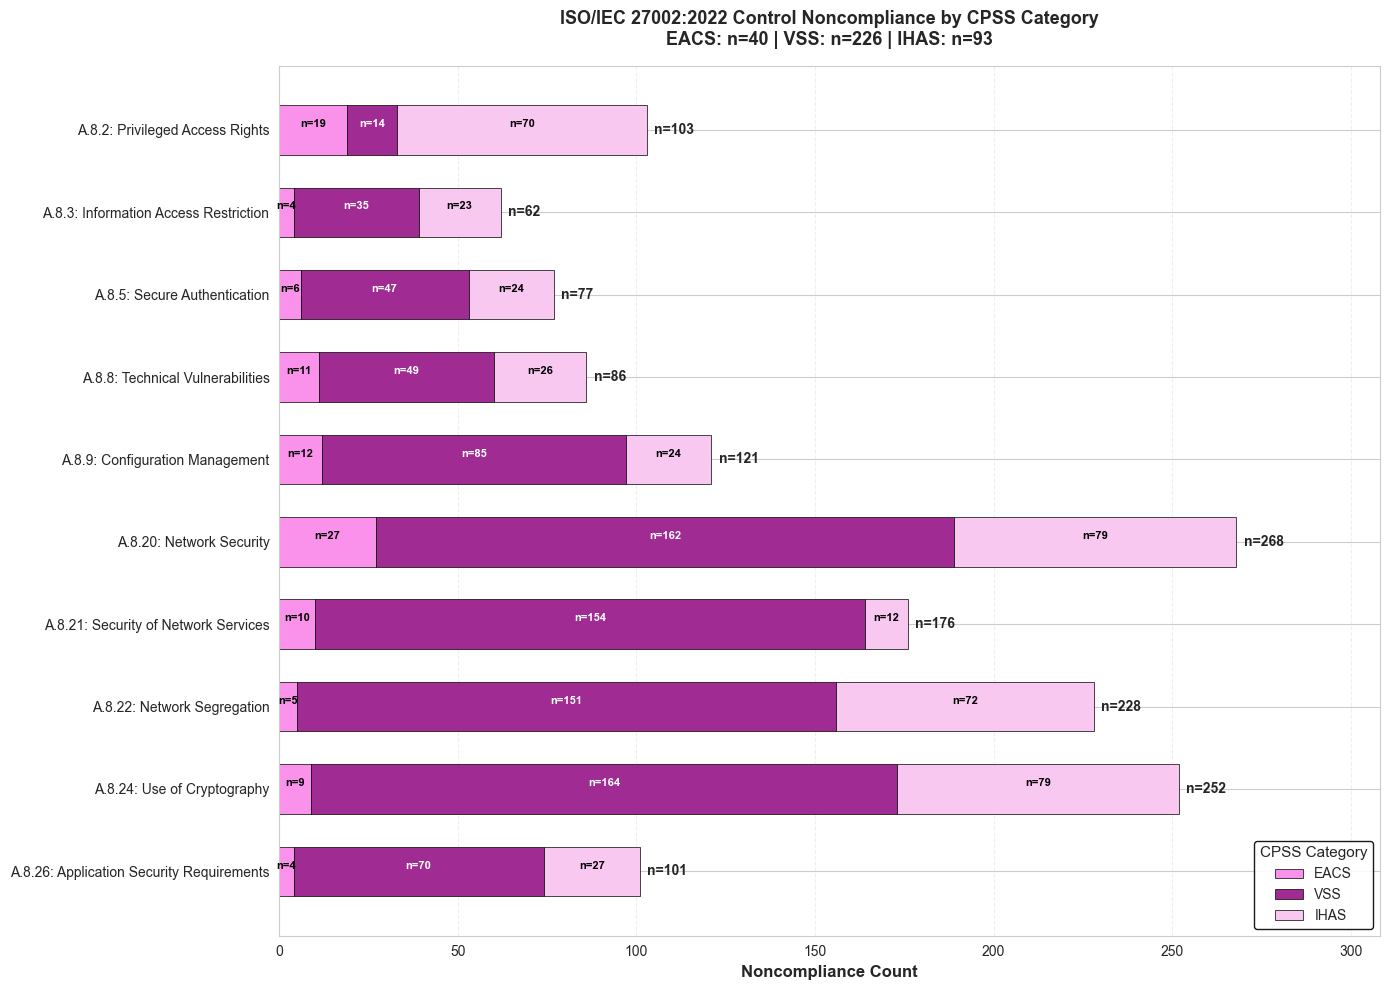


3. Generating resilience domain visualization (horizontal stacked)...
✓ Saved: ./output/3_iso27002_assessment/resilience_domains_by_cpss.png


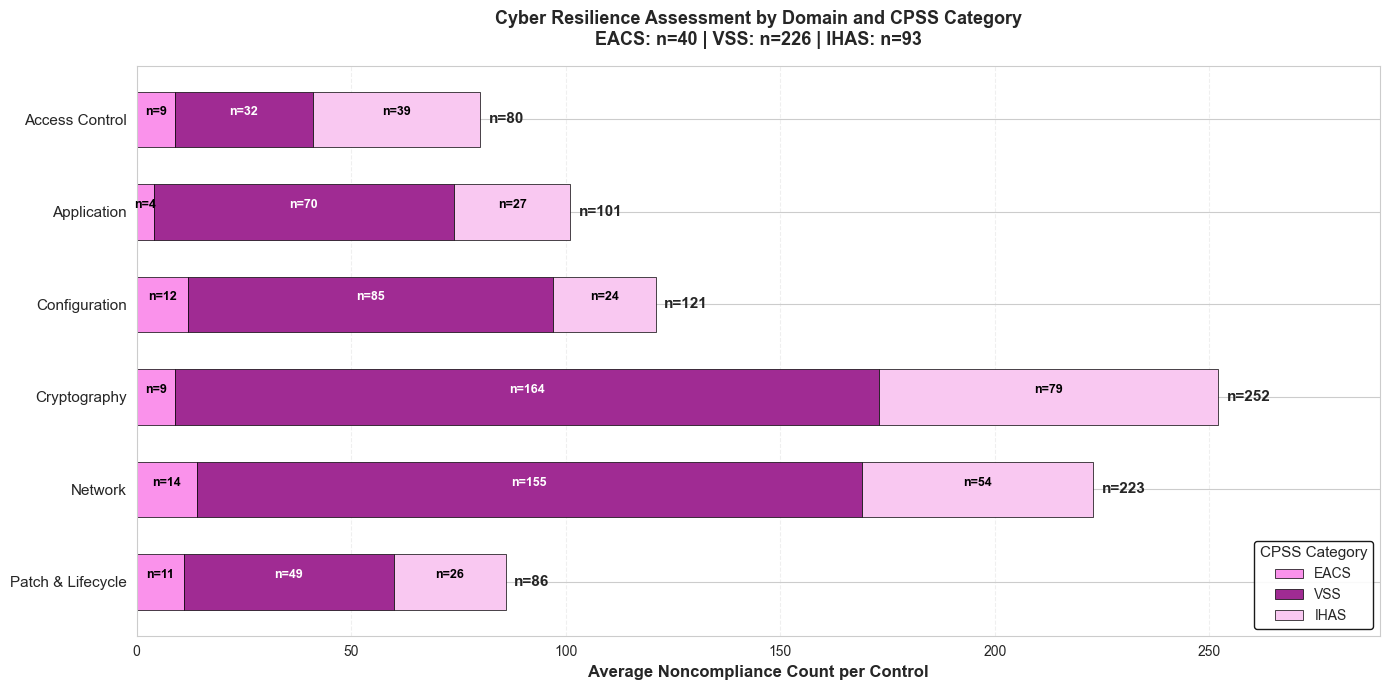


4. Generating heatmap...
✓ Saved: ./output/3_iso27002_assessment/control_heatmap.png


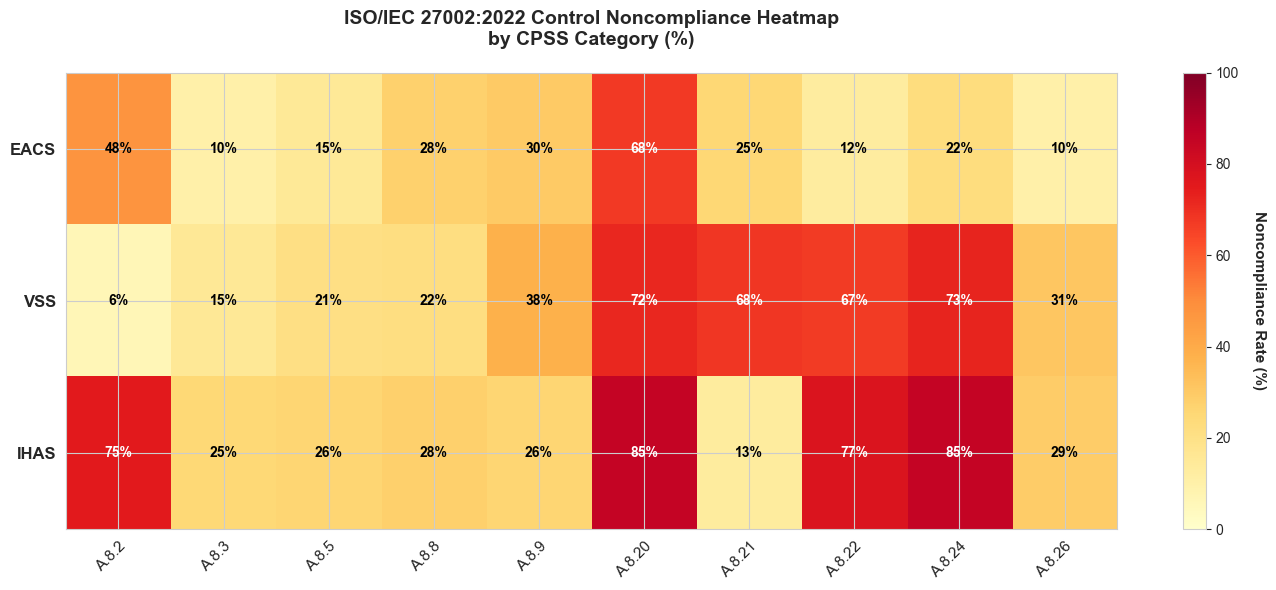


✓ ALL VISUALIZATIONS COMPLETE
✓ Files saved to: ./output/3_iso27002_assessment/


In [67]:
# Add cpss_category column from cpss_primary_category
results_df['cpss_category'] = results_df['cpss_primary_category']

# Check the categories
print("CPSS categories in dataset:")
print(results_df['cpss_category'].value_counts())

# Now generate visualizations
viz_data = generate_all_visualizations(results_df)